In [1]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
# plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_german_credit.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# Number of errors
display(len(raw_data.loc[raw_data['errors']==1]))
display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

63

106

### Utils

In [3]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware KMeans Clustering 

In [4]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
}

In [5]:
full_data = initialize_dataset(raw_data)
full_data.head()

# pca_plot(full_data, 'Compas', 0.6)

Age       Job  Credit amount  Duration  Purpose_car  \
136 -0.736682  0.222911       2.097685  0.541581     1.659987   
76  -0.098692  0.222911       0.299478  1.760861    -0.602414   
280 -1.101248  0.222911       0.068512 -0.433842     1.659987   
319 -0.736682 -1.346756       0.174903 -0.433842    -0.602414   
174 -0.827824  0.222911       0.086308  0.053870    -0.602414   

     Purpose_domestic appliances  Purpose_education  \
136                    -0.077152          -0.250785   
76                     -0.077152          -0.250785   
280                    -0.077152          -0.250785   
319                    -0.077152          -0.250785   
174                    -0.077152           3.987480   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  ...  \
136                    -0.547723         -0.620682        -0.109435  ...   
76                     -0.547723          1.611131        -0.109435  ...   
280                    -0.547723         -0.620682        -0.109435  ...   
319                     1.825742         -0.620682        -0.109435  ...   
174                    -0.547723         -0.620682        -0.109435  ...   

     Check_rich  Age_cat_Young  Age_cat_Adult  Age_cat_Senior  scaled_errors  \
136   -0.250785       1.249242      -0.761209       -0.191859            0.0   
76    -0.250785       1.249242      -0.761209       -0.191859            0.8   
280   -0.250785      -0.800485      -0.761209       -0.191859            0.0   
319   -0.250785       1.249242      -0.761209       -0.191859            0.0   
174   -0.250785       1.249242      -0.761209       -0.191859            0.8   

     predicted_class  true_class  errors  clusters  new_clusters  
136                0         0.0     0.0         0            -1  
76                 0         1.0     1.0         0            -1  
280                0         0.0     0.0         0            -1  
319                0         0.0     0.0         0            -1  
174                0         1.0     1.0         0            -1  

[5 rows x 30 columns]

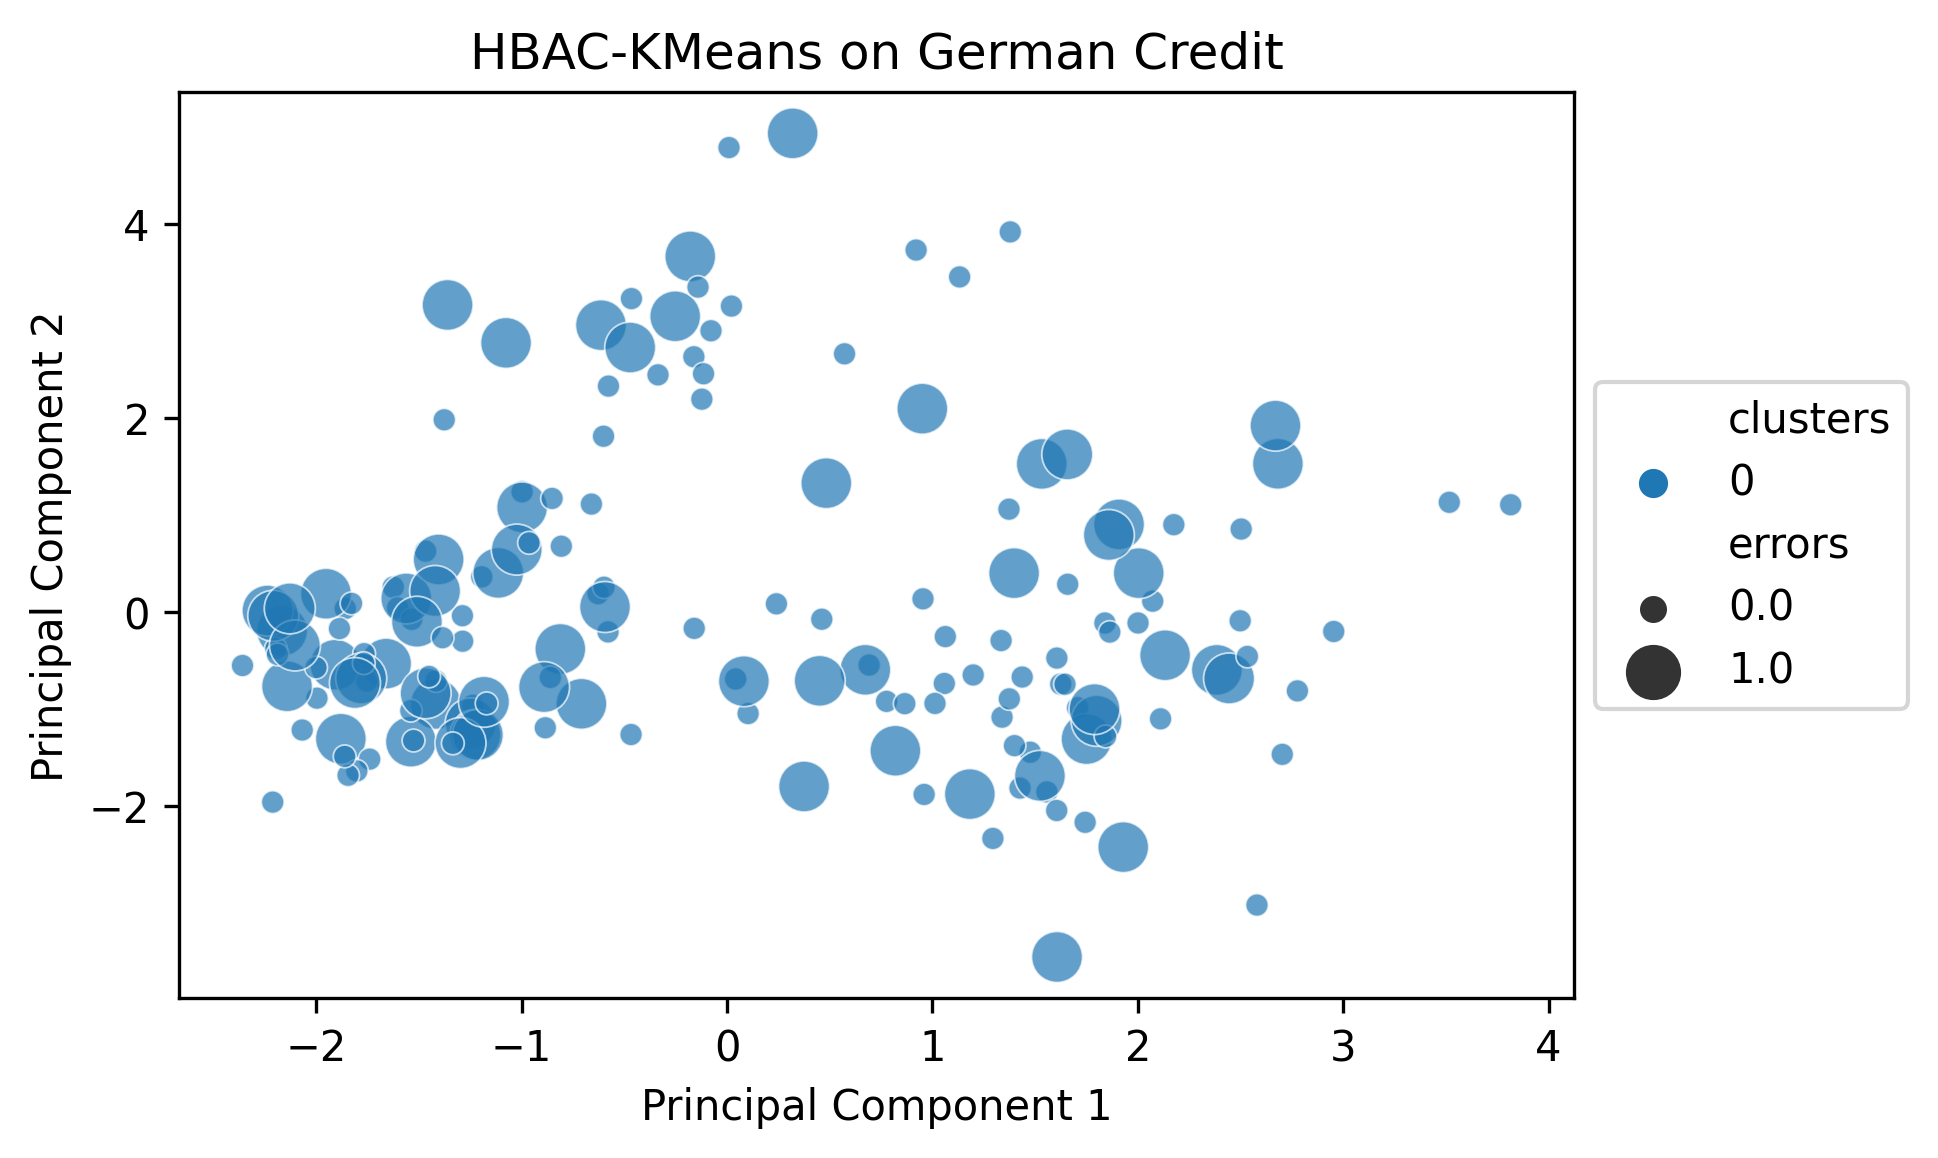

average_accuracy is:  0.6272189349112426
discriminating bias is: -999999


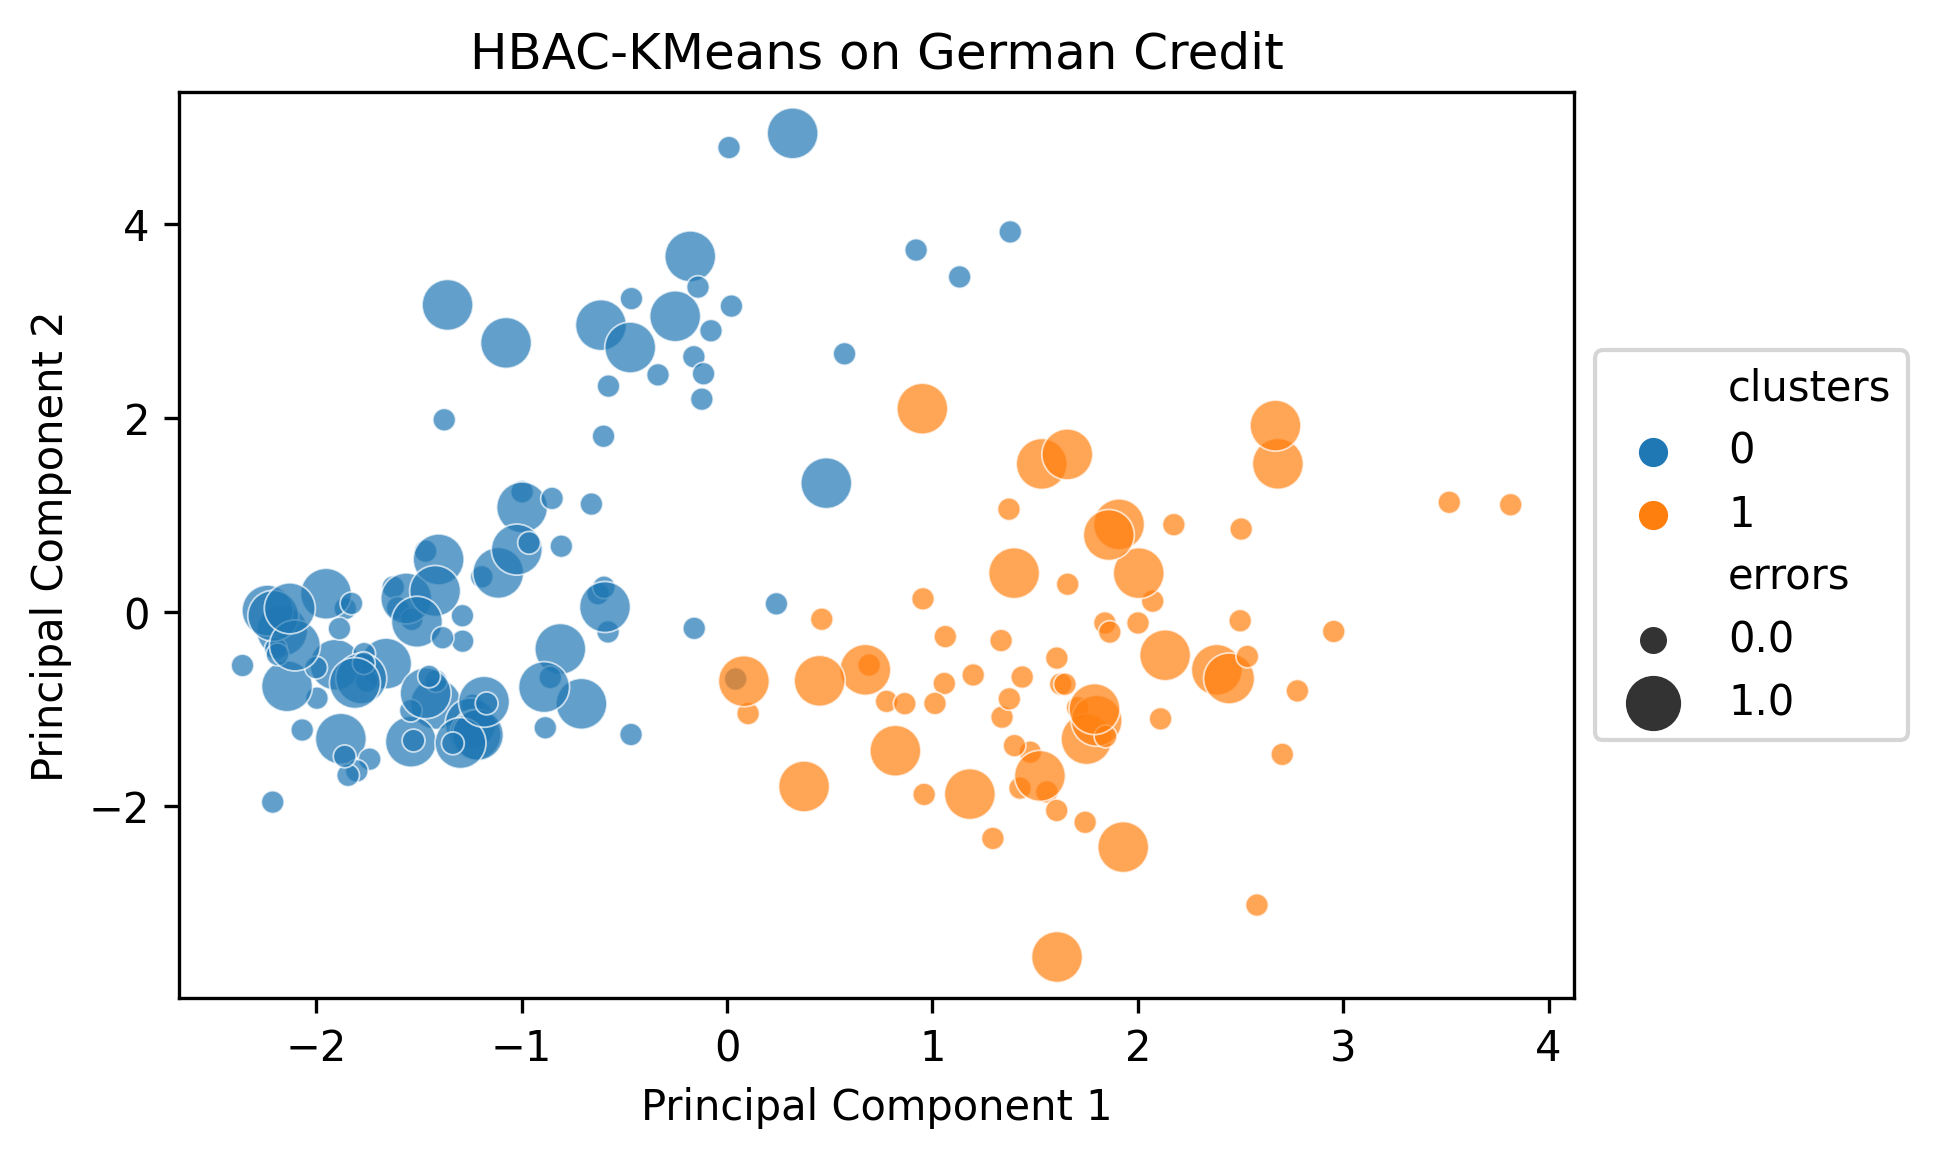

--> Cluster with the highest variance: 0
discriminating bias is: -999999


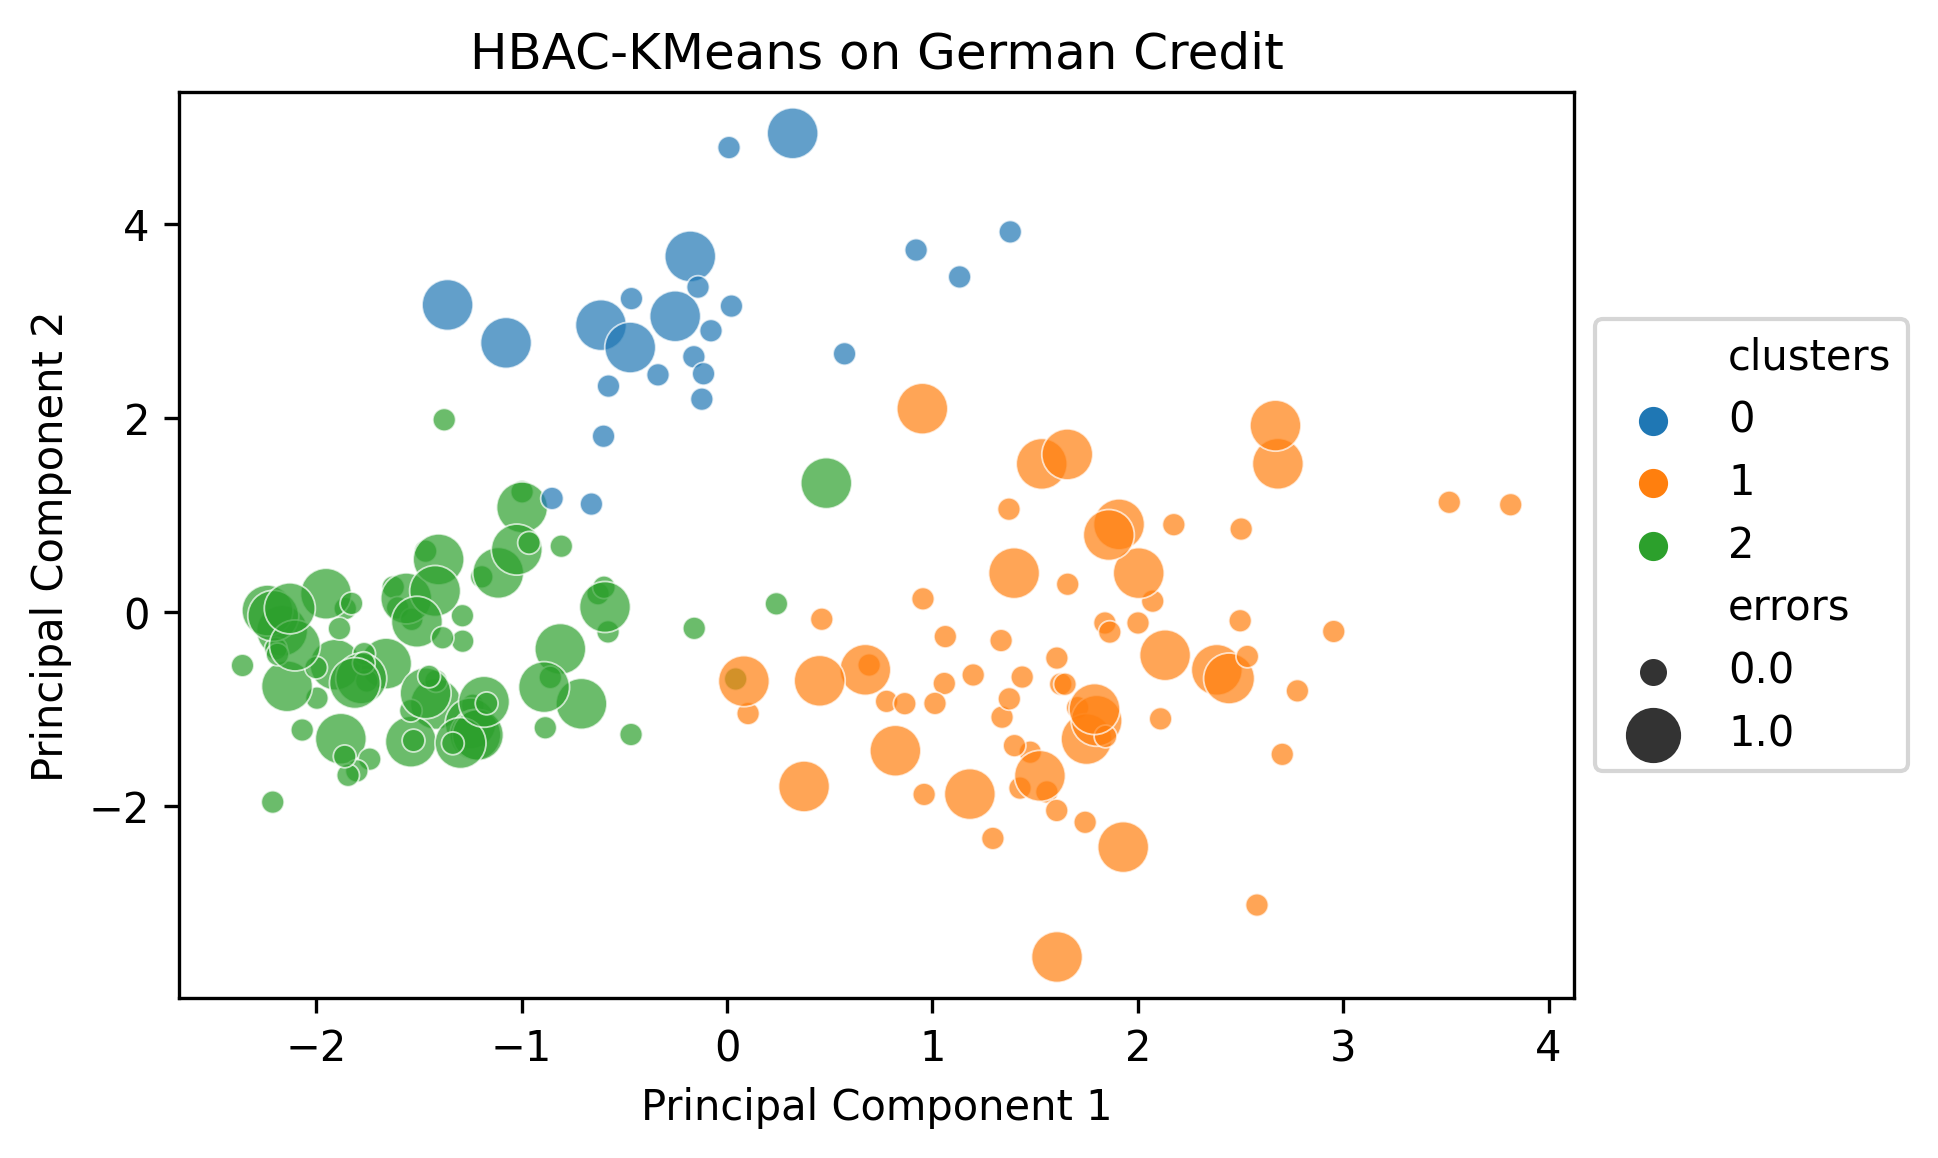

--> Cluster with the highest variance: 2
discriminating bias is: -999999


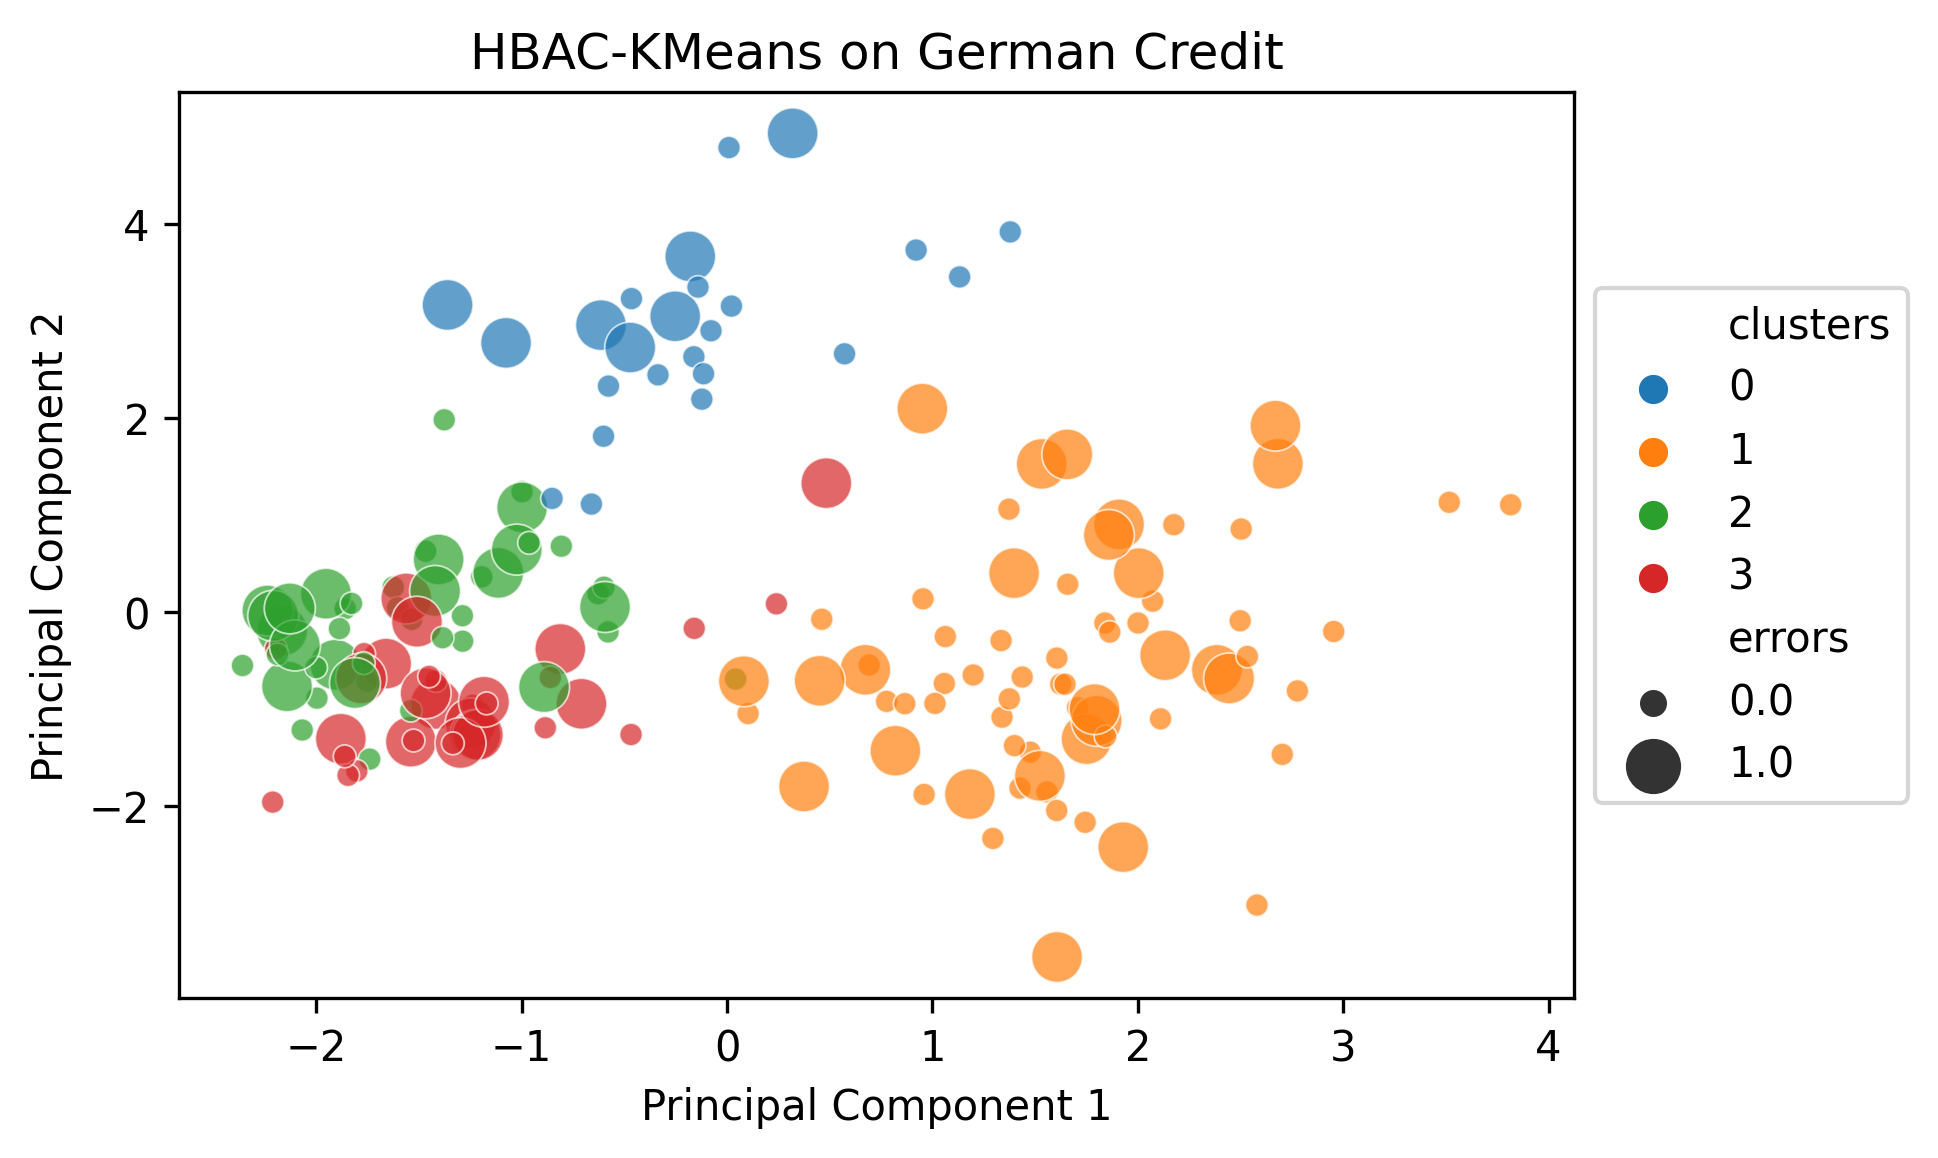

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 3
discriminating bias is: -999999


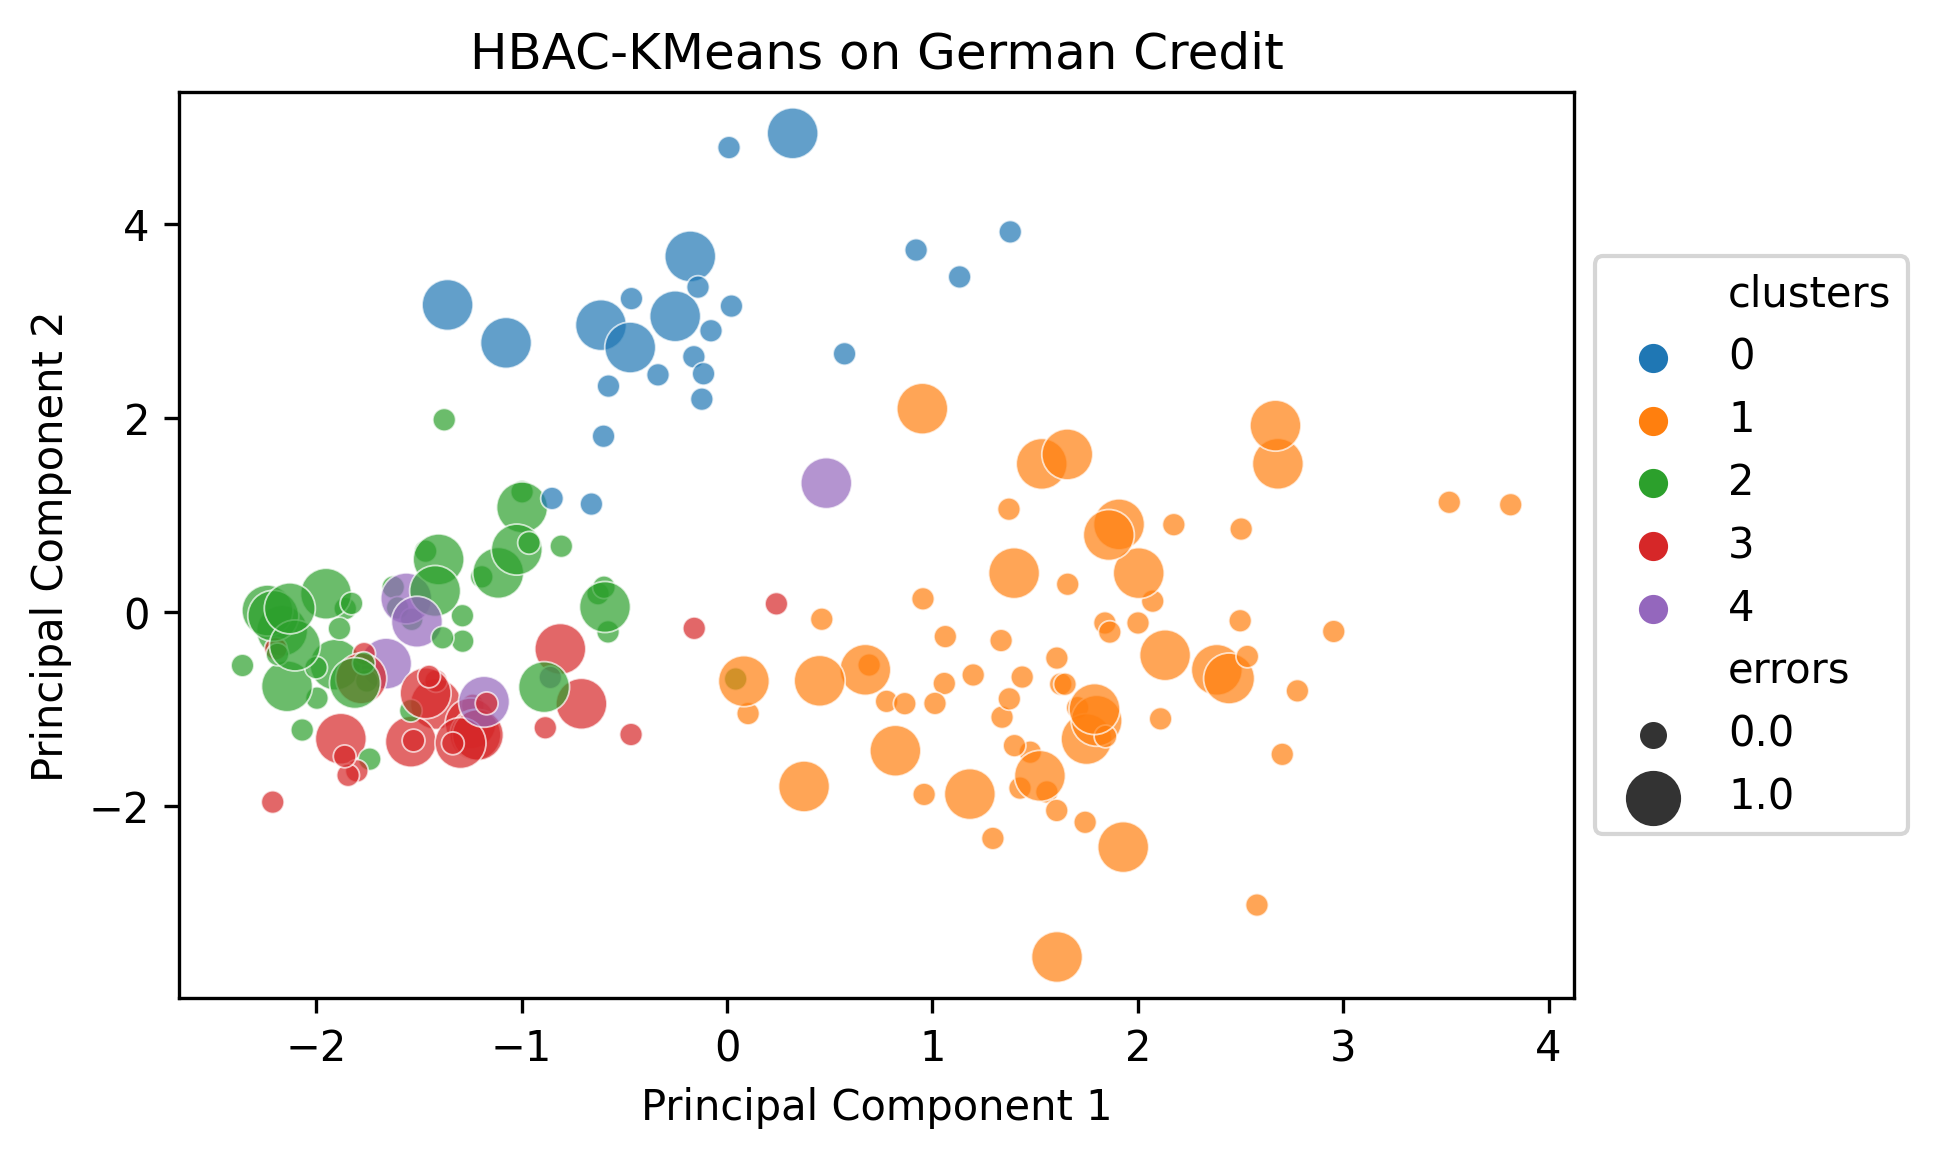

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 3
discriminating bias is: -999999


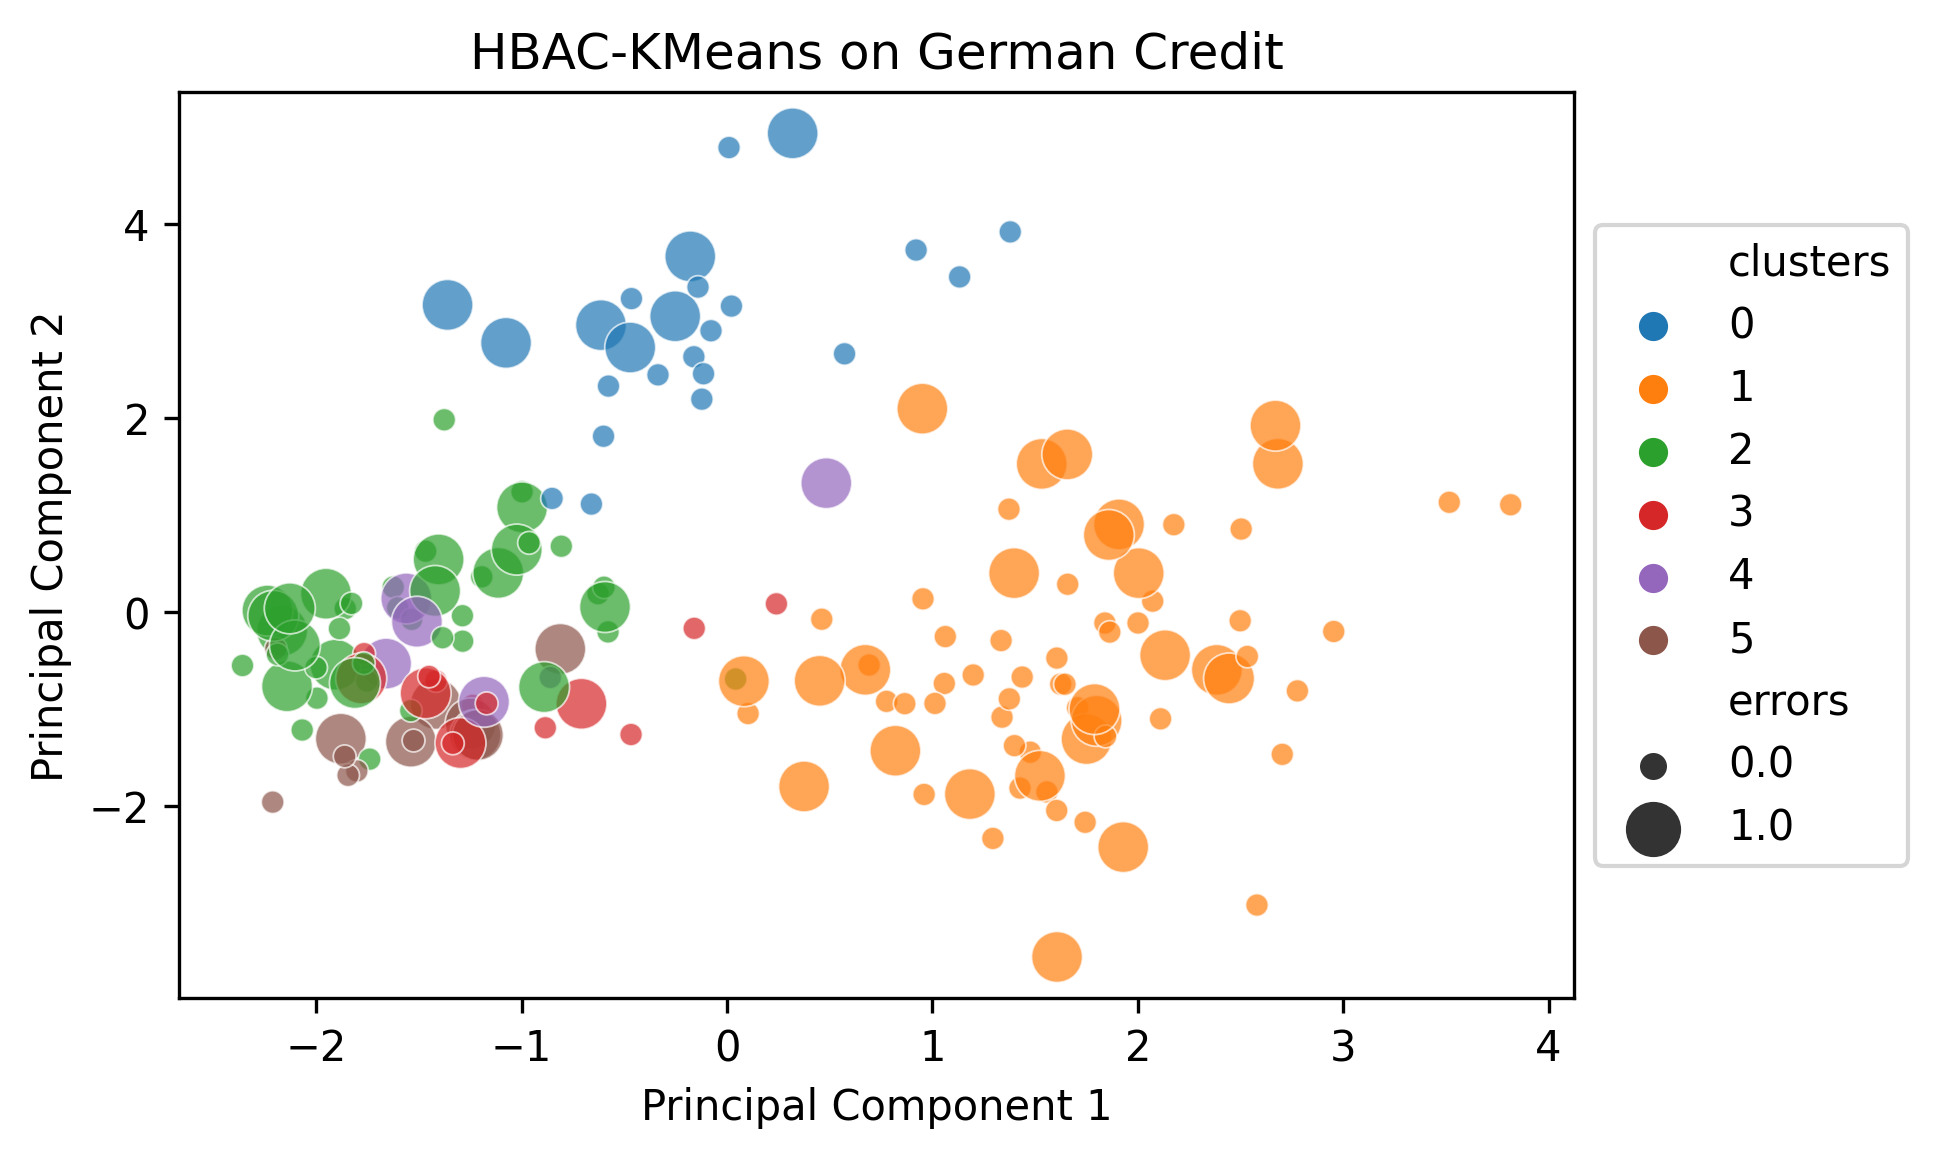

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 5
discriminating bias is: -999999


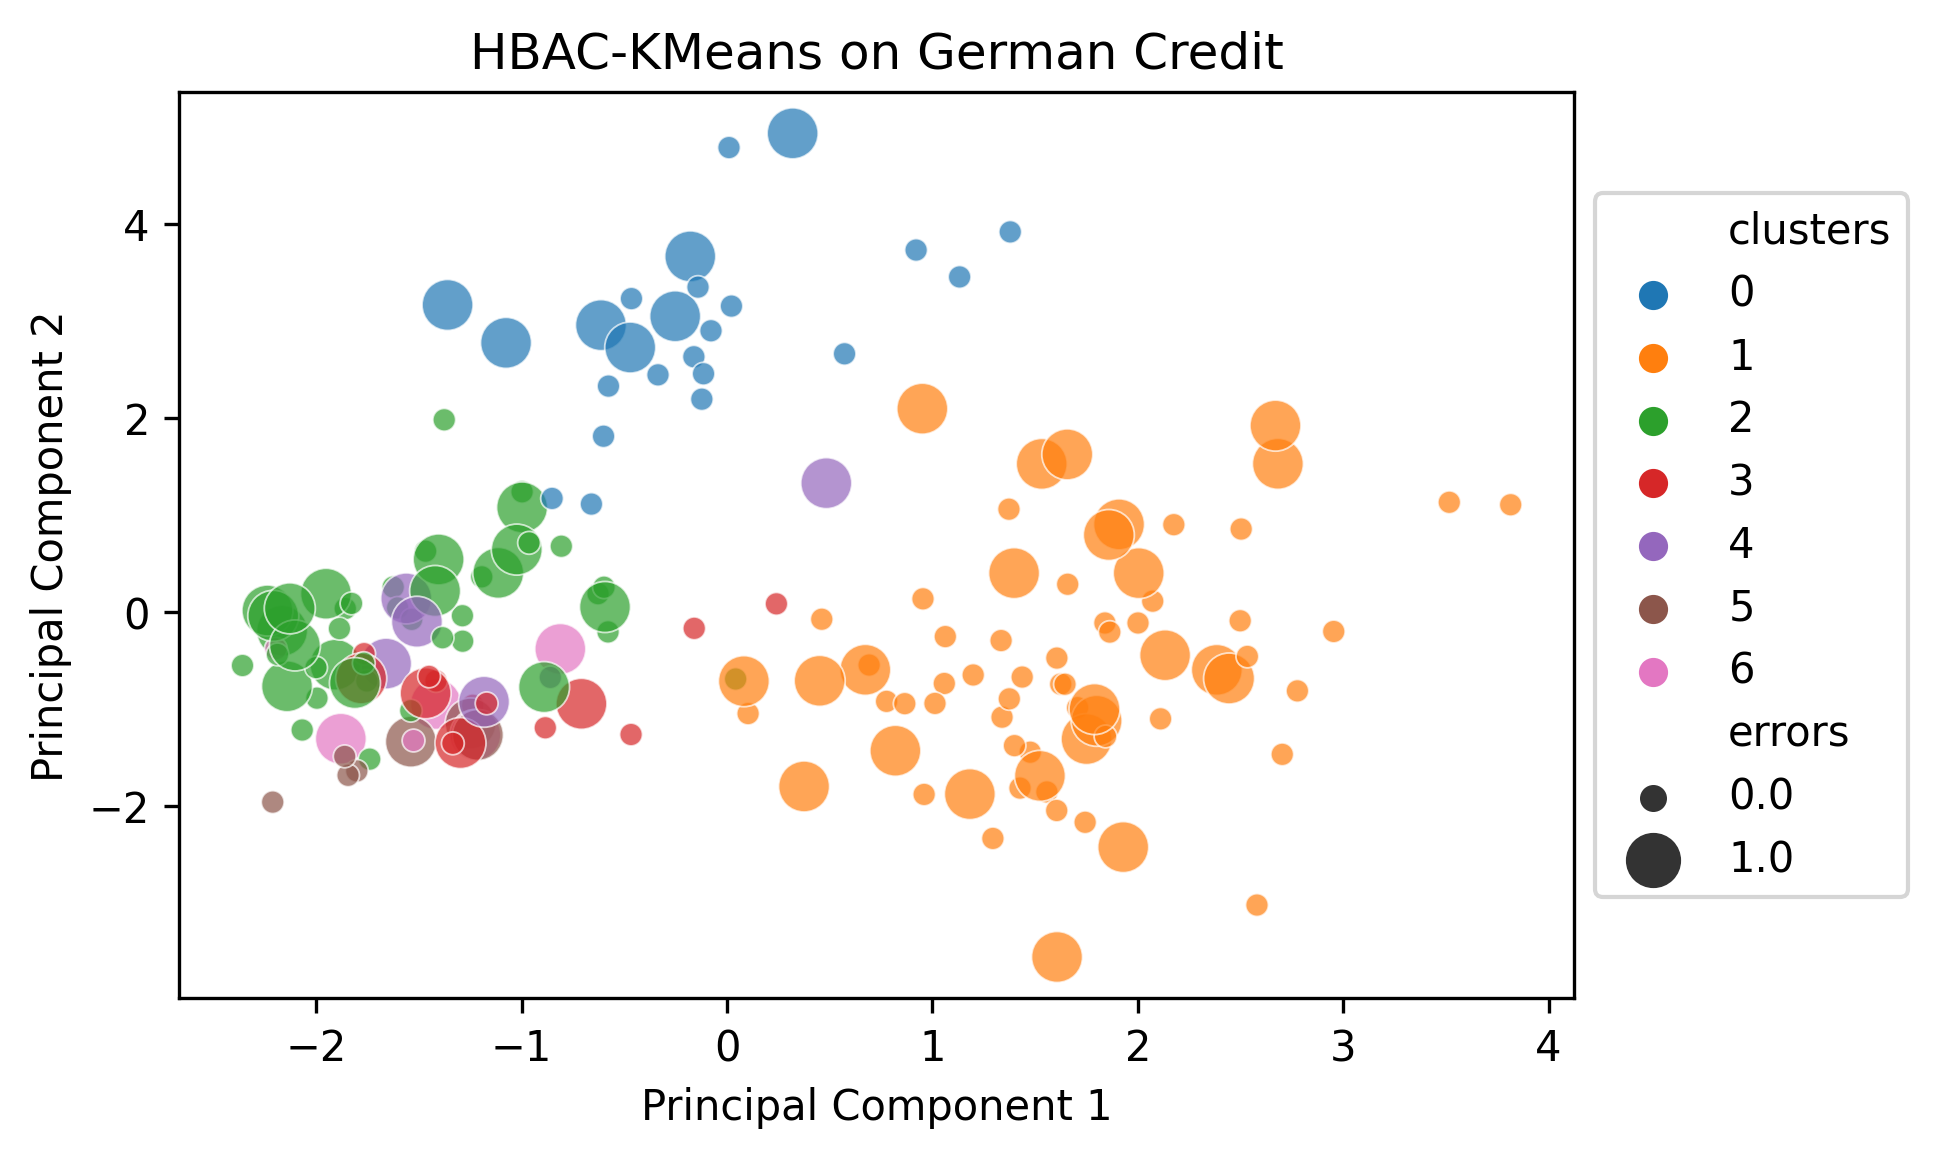

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 5
This is the random cluster we have picked: 5
This is the random cluster we have picked: 5
This is the random cluster we have picked: 1
discriminating bias is: -999999


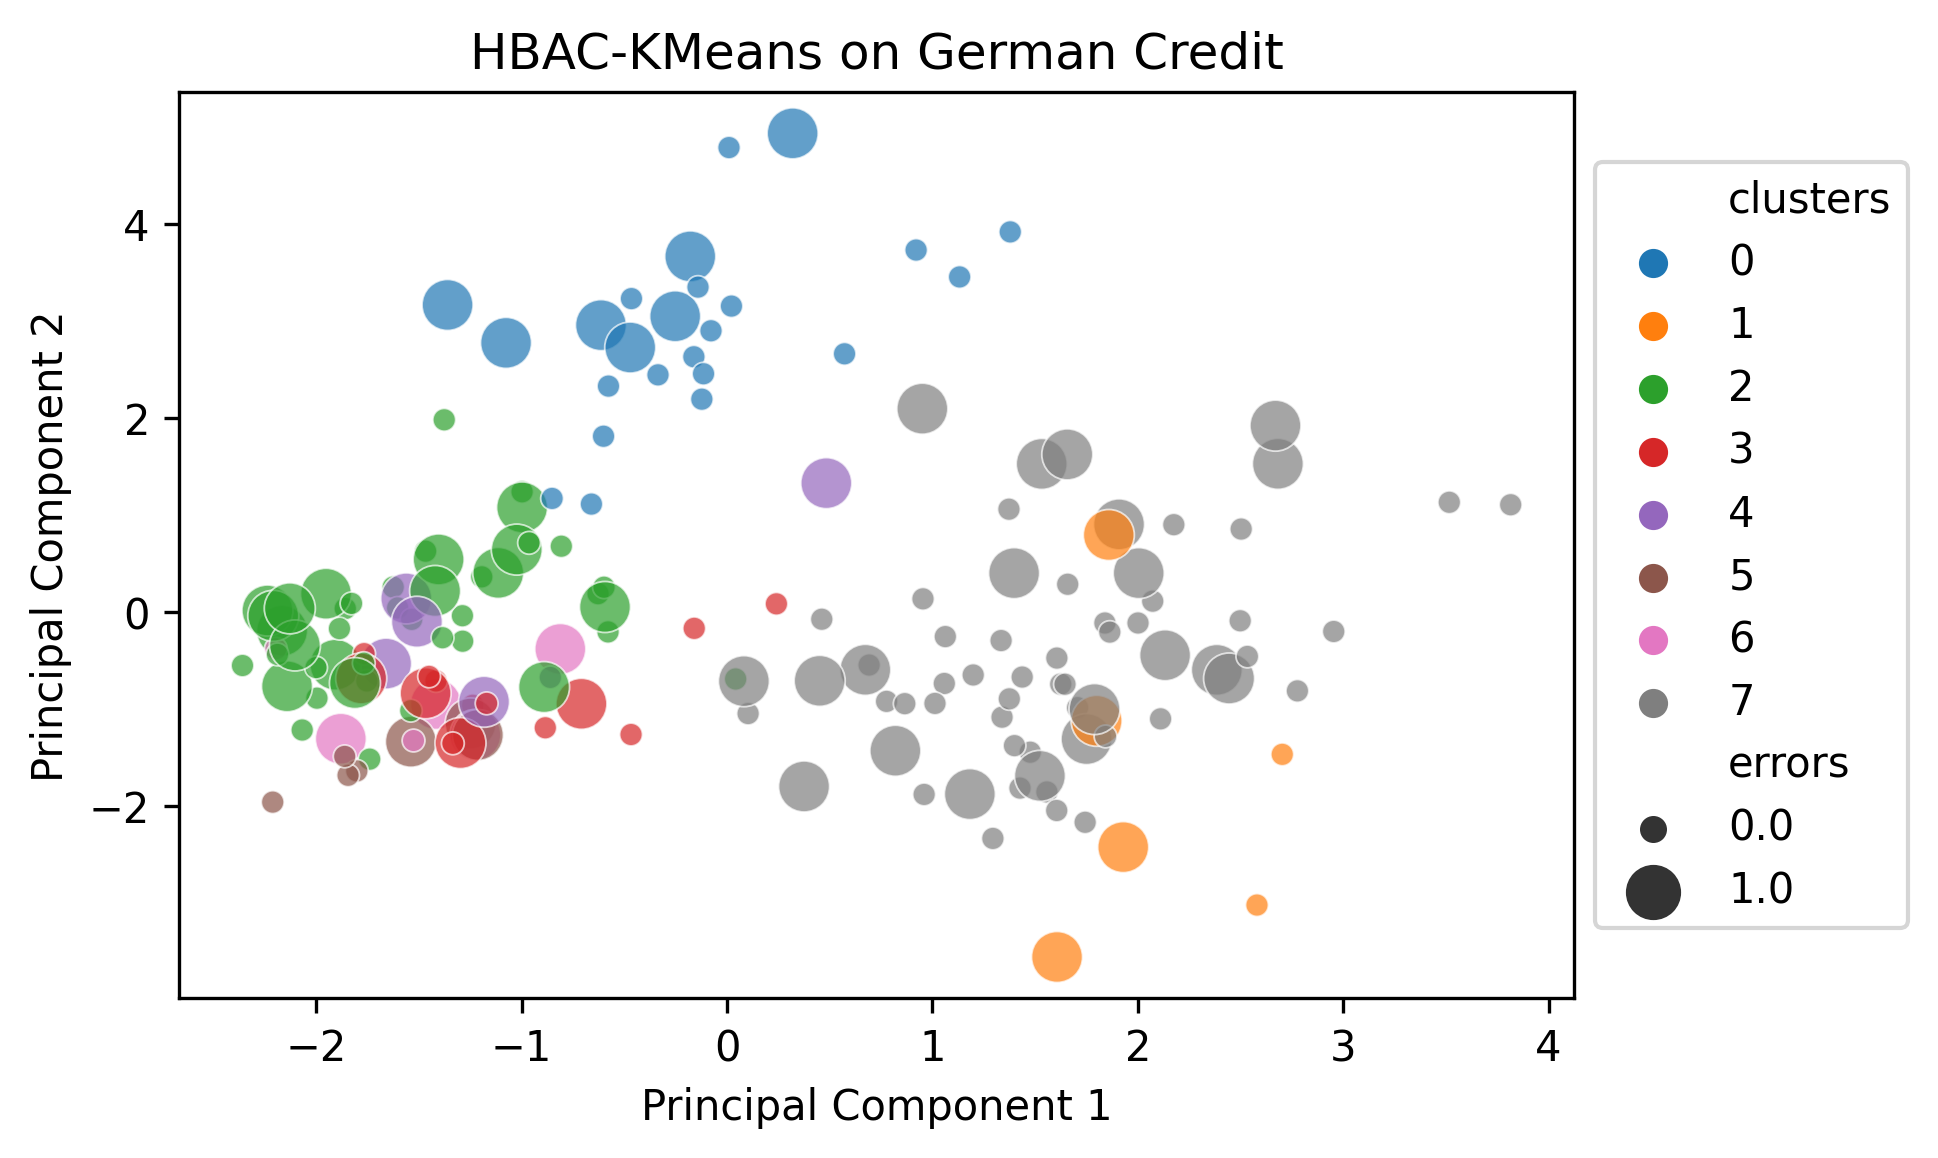

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 5
This is the random cluster we have picked: 8
This is the random cluster we have picked: 5
This is the random cluster we have picked: 6
This is the random cluster we have picked: 7
discriminating bias is: -999999
This is the random cluster we have picked: 1
This is the random cluster we have picked: 5
This is the random cluster we have picked: 0
discriminating bias is: -999999
This is the random cluster we have picked: 6
This is the random cluster we have picked: 5
This is the random cluster we have picked: 7
discriminating bias is: -999999
This is the random cluster we have picked: 0
discriminating bias is: -999999
This is the random cluster we have picked: 2
discriminating bias is: -999999


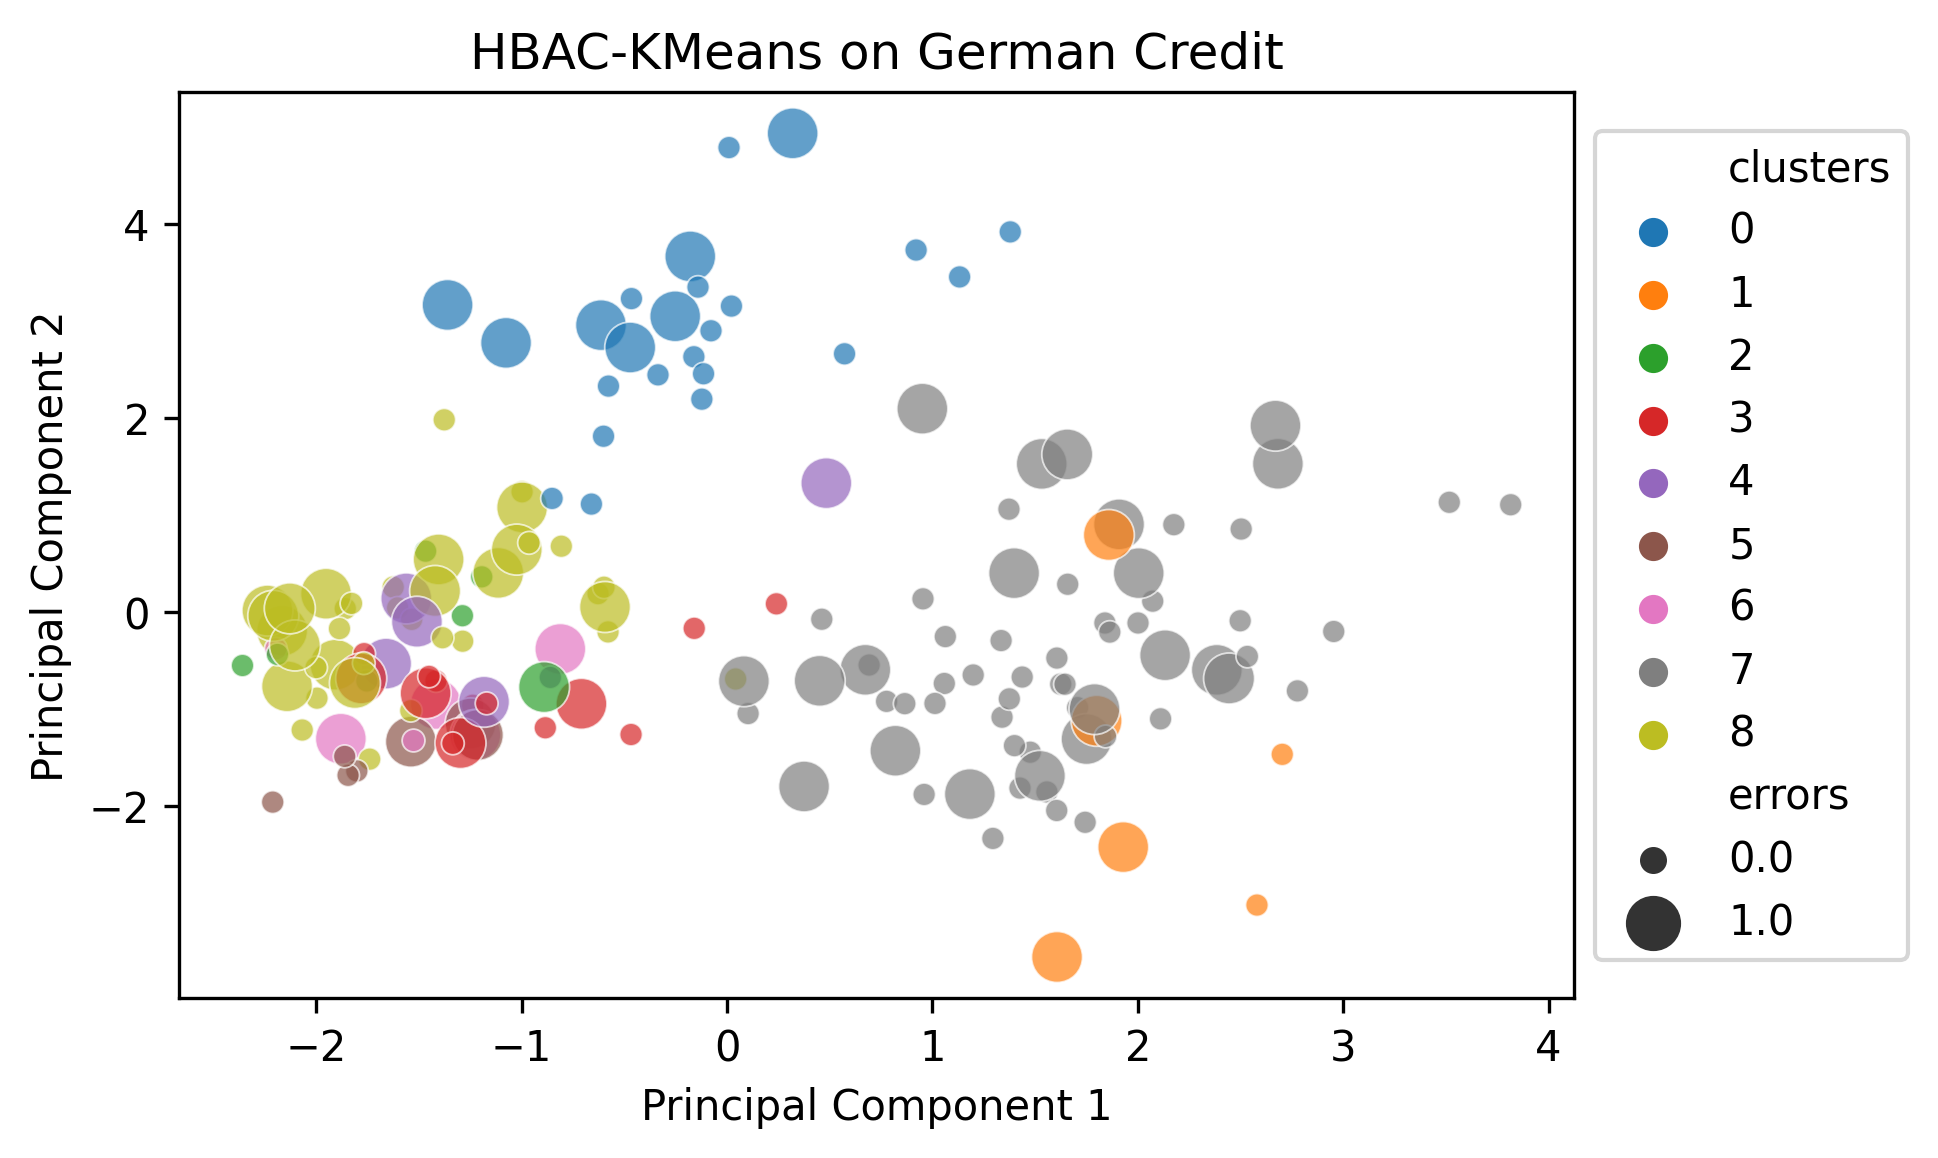

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 8
--> Cluster with the highest variance: 5
This is the random cluster we have picked: 0
discriminating bias is: -999999
This is the random cluster we have picked: 2
This is the random cluster we have picked: 1
This is the random cluster we have picked: 1
This is the random cluster we have picked: 7
discriminating bias is: -999999
This is the random cluster we have picked: 4
MAX_ITER
[0.0011020698493159496, 0.005139449108148971, 0.0073965061707797035, 0.04224649644565977, 0.041626063245417844, 0.04158468652205754, 0.04158468652205754, 0.04158468652205754, 0.04158468652205754, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.0435207944212418, 0.04994272509326164, 0.04994272509326

In [6]:
# original code
MAX_ITER = 30
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-KMeans on German Credit', 0.7)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data))
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x]

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply KMeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data, 'HBAC-KMeans on German Credit', 0.7)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

## Analysing the biased cluster

In [7]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

2 has bias 0.23985890652557318
6 has bias -0.3047034764826176
0 has bias 0.0945402298850575
8 has bias -0.041769041769041726
4 has bias -0.4775051124744376
3 has bias 0.09493087557603686
5 has bias -0.05820105820105825
7 has bias 0.07928851371721435
1 has bias -0.3047034764826176
cluster with the highest discriminating bias: 4
General accuracy of classifier on this dataset: 0.6272189349112426
cluster 4 has the highest discrimination bias
-0.4775051124744376


Number of instances in discriminated cluster: 6
Number of errors in discriminated clusters:  5
found discriminated cluster:


Age       Job  Credit amount  Duration  Purpose_car  \
174 -0.827824  0.222911       0.086308  0.053870    -0.602414   
318 -0.280975  0.222911      -0.963291 -0.677698    -0.602414   
244 -0.007550 -1.346756       0.099075 -0.677698    -0.602414   
331 -0.463258  0.222911      -0.513352 -0.189986    -0.602414   
5   -0.007550 -1.346756       2.268685  1.273149    -0.602414   
131 -0.554399  0.222911       1.429934  1.273149    -0.602414   

     Purpose_domestic appliances  Purpose_education  \
174                    -0.077152            3.98748   
318                    -0.077152            3.98748   
244                    -0.077152            3.98748   
331                    -0.077152            3.98748   
5                      -0.077152            3.98748   
131                    -0.077152            3.98748   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  ...  \
174                    -0.547723         -0.620682        -0.109435  ...   
318                    -0.547723         -0.620682        -0.109435  ...   
244                    -0.547723         -0.620682        -0.109435  ...   
331                    -0.547723         -0.620682        -0.109435  ...   
5                      -0.547723         -0.620682        -0.109435  ...   
131                    -0.547723         -0.620682        -0.109435  ...   

     Check_rich  Age_cat_Young  Age_cat_Adult  Age_cat_Senior  scaled_errors  \
174   -0.250785       1.249242      -0.761209       -0.191859            0.8   
318   -0.250785       1.249242      -0.761209       -0.191859            0.8   
244   -0.250785       1.249242      -0.761209       -0.191859            0.0   
331   -0.250785       1.249242      -0.761209       -0.191859            0.8   
5     -0.250785       1.249242      -0.761209       -0.191859            0.8   
131   -0.250785       1.249242      -0.761209       -0.191859            0.8   

     predicted_class  true_class  errors  clusters  new_clusters  
174                0         1.0     1.0         4          -1.0  
318                1         0.0     1.0         4          -1.0  
244                0         0.0     0.0         4          -1.0  
331                0         1.0     1.0         4          -1.0  
5                  1         0.0     1.0         4          -1.0  
131                0         1.0     1.0         4          -1.0  

[6 rows x 30 columns]

Age
this is the t-statistic -2.401377484813781
this is the p-value: 0.03903093350888523
Job
this is the t-statistic -0.9151513551000888
this is the p-value: 0.3978895590273149
Credit amount
this is the t-statistic 0.8255824822727758
this is the p-value: 0.4449354995939907
Duration
this is the t-statistic 0.48706611090249763
this is the p-value: 0.6450843725571911
Purpose_car
this is the t-statistic -7.860003881484356
this is the p-value: 5.064739463099155e-13
Purpose_domestic appliances
this is the t-statistic -1.0000000000000002
this is the p-value: 0.318801846932817
Purpose_education
this is the t-statistic 80.24649525057154
this is the p-value: 2.40715655855165e-132
Purpose_furniture/equipment
this is the t-statistic -7.138039850212787
this is the p-value: 3.012892894859323e-11
Purpose_radio/TV
this is the t-statistic -8.10172395447307
this is the p-value: 1.2420783712705122e-13
Purpose_repairs
this is the t-statistic -1.418598731230381
this is the p-value: 0.1579369920973178
Purpos

unscaled_discriminated  unscaled_remaining  \
Age                                       31.166667           35.226994   
Job                                        1.666667            1.865031   
Credit amount                           4228.000000         3152.736196   
Duration                                  22.500000           20.257669   
Purpose_car                                0.000000            0.276074   
Purpose_domestic appliances                0.000000            0.006135   
Purpose_education                          1.000000            0.024540   
Purpose_furniture/equipment                0.000000            0.239264   
Purpose_radio/TV                           0.000000            0.288344   
Purpose_repairs                            0.000000            0.012270   
Purpose_vacation/others                    0.000000            0.012270   
Sex_male                                   0.666667            0.723926   
Housing_own                                0.833333            0.748466   
Housing_rent                               0.000000            0.177914   
Savings_moderate                           0.166667            0.092025   
Savings_no_inf                             0.166667            0.190184   
Savings_quite rich                         0.166667            0.067485   
Savings_rich                               0.000000            0.067485   
Check_moderate                             0.000000            0.312883   
Check_no_inf                               0.666667            0.380368   
Check_rich                                 0.000000            0.061350   
Age_cat_Young                              1.000000            0.368098   
Age_cat_Adult                              0.000000            0.380368   
Age_cat_Senior                             0.000000            0.036810   
predicted_class                            0.333333            0.171779   
true_class                                 0.500000            0.257669   
errors                                     0.833333            0.355828   

                              difference  
Age                            -4.060327  
Job                            -0.198364  
Credit amount                1075.263804  
Duration                        2.242331  
Purpose_car                    -0.276074  
Purpose_domestic appliances    -0.006135  
Purpose_education               0.975460  
Purpose_furniture/equipment    -0.239264  
Purpose_radio/TV               -0.288344  
Purpose_repairs                -0.012270  
Purpose_vacation/others        -0.012270  
Sex_male                       -0.057260  
Housing_own                     0.084867  
Housing_rent                   -0.177914  
Savings_moderate                0.074642  
Savings_no_inf                 -0.023517  
Savings_quite rich              0.099182  
Savings_rich                   -0.067485  
Check_moderate                 -0.312883  
Check_no_inf                    0.286299  
Check_rich                     -0.061350  
Age_cat_Young                   0.631902  
Age_cat_Adult                  -0.380368  
Age_cat_Senior                 -0.036810  
predicted_class                 0.161554  
true_class                      0.242331  
errors                          0.477505

Age       Job  Credit amount   Duration  \
unscaled_discriminated  31.166667  1.666667    4228.000000  22.500000   
unscaled_remaining      35.226994  1.865031    3152.736196  20.257669   

                        Purpose_car  Purpose_domestic appliances  \
unscaled_discriminated     0.000000                     0.000000   
unscaled_remaining         0.276074                     0.006135   

                        Purpose_education  Purpose_furniture/equipment  \
unscaled_discriminated            1.00000                     0.000000   
unscaled_remaining                0.02454                     0.239264   

                        Purpose_radio/TV  Purpose_repairs  ...  \
unscaled_discriminated          0.000000          0.00000  ...   
unscaled_remaining              0.288344          0.01227  ...   

                        Check_moderate  Check_no_inf  Check_rich  \
unscaled_discriminated        0.000000      0.666667     0.00000   
unscaled_remaining            0.312883      0.380368     0.06135   

                        Age_cat_Young  Age_cat_Adult  Age_cat_Senior  \
unscaled_discriminated       1.000000       0.000000         0.00000   
unscaled_remaining           0.368098       0.380368         0.03681   

                        predicted_class  true_class    errors  \
unscaled_discriminated         0.333333    0.500000  0.833333   
unscaled_remaining             0.171779    0.257669  0.355828   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining  

[2 rows x 28 columns]

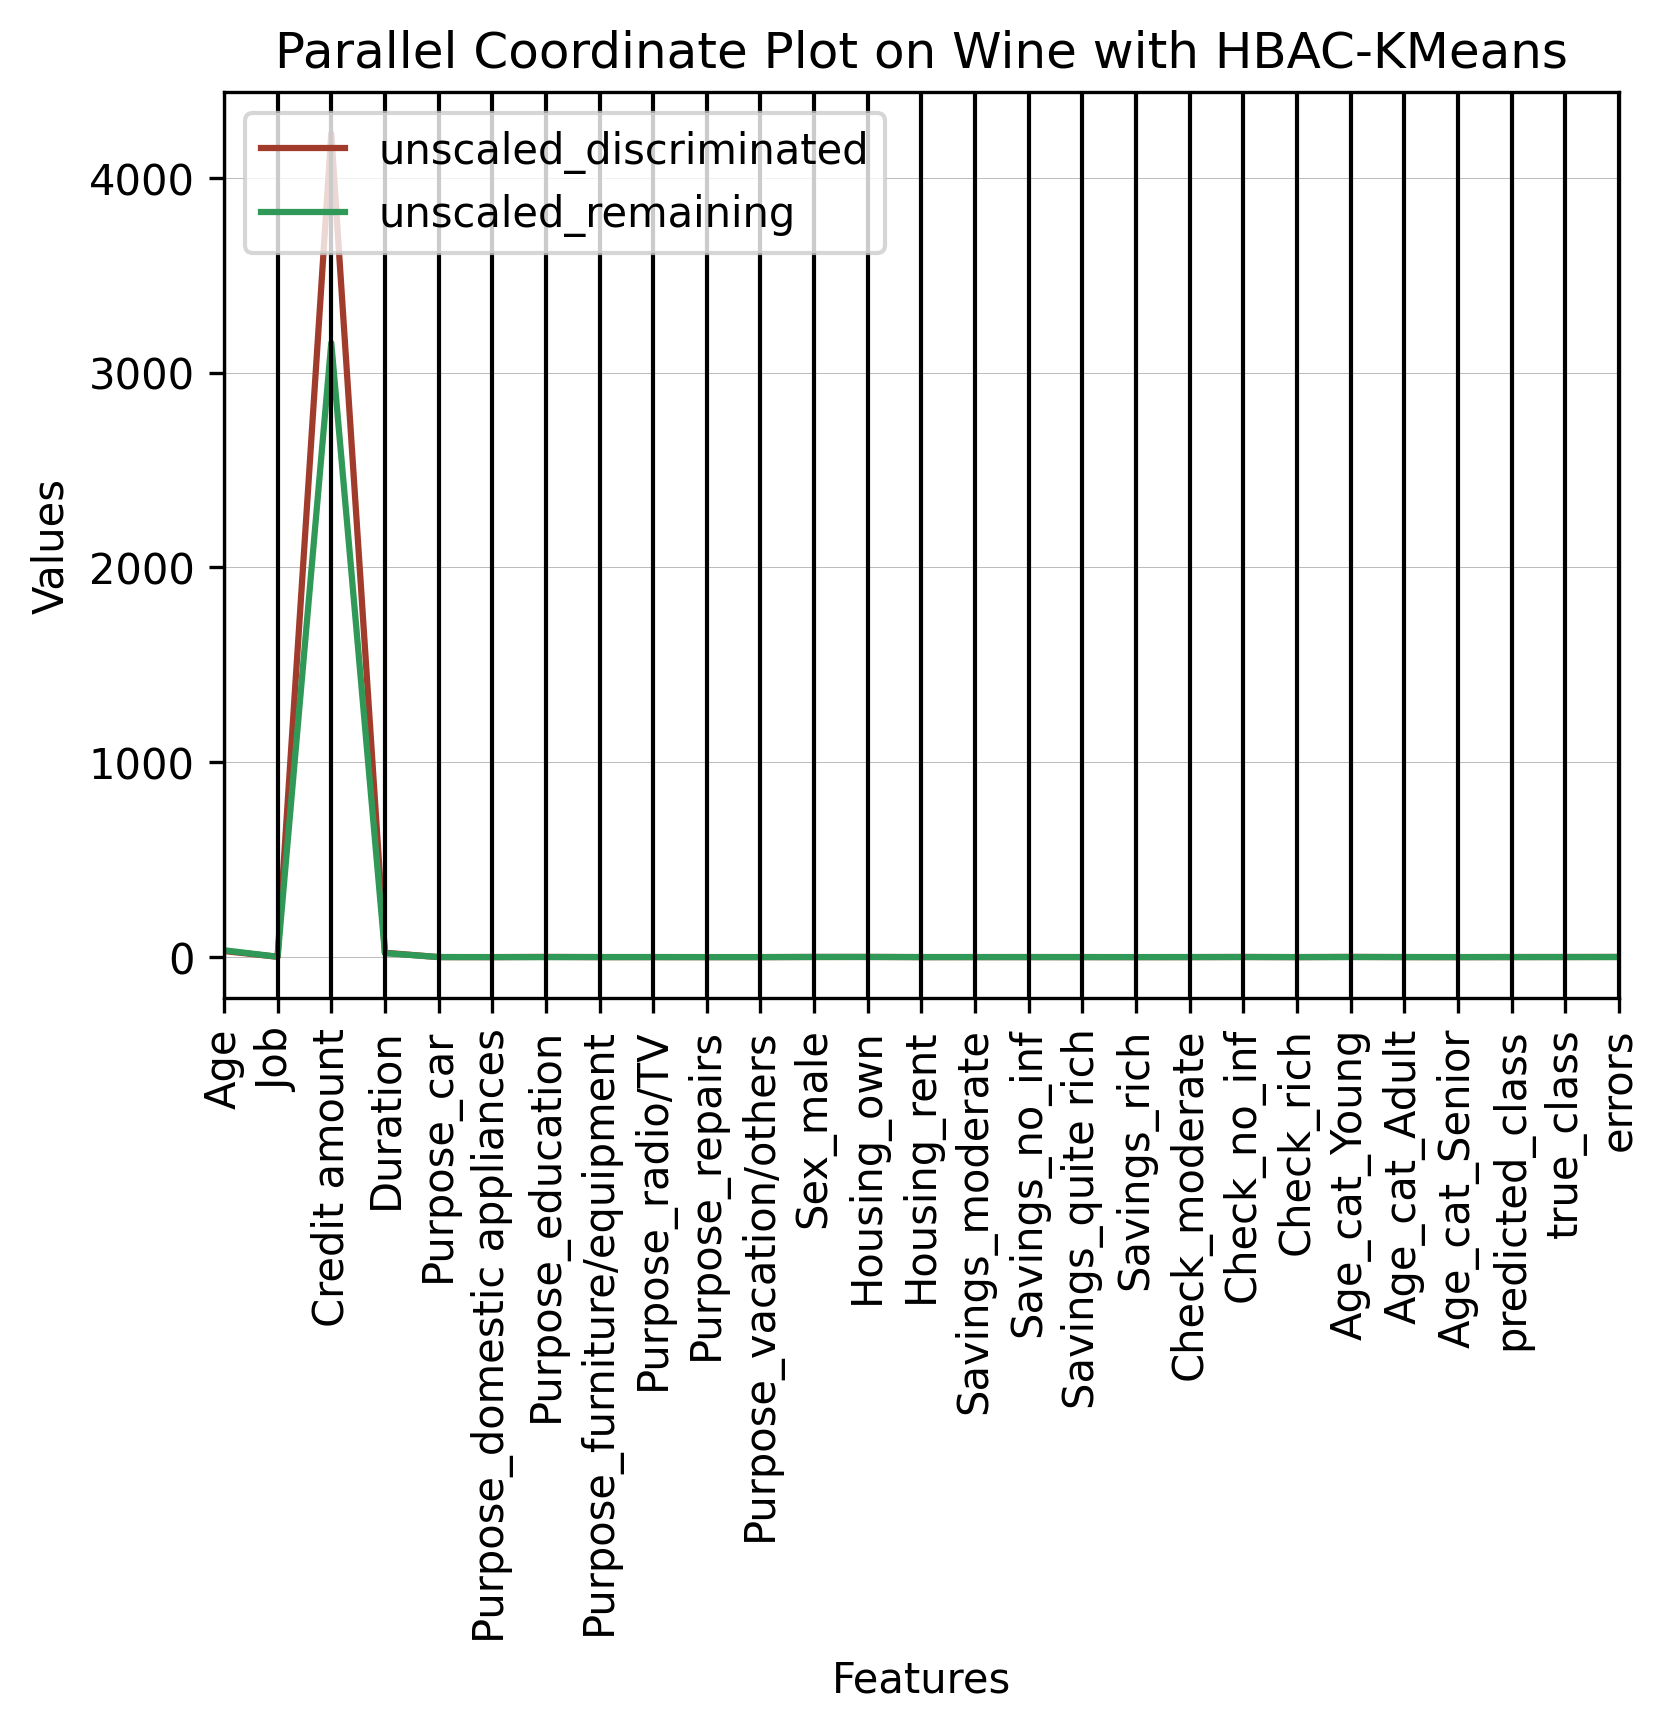

In [8]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on Wine with HBAC-KMeans")

In [12]:
unscal

unscaled_discriminated  unscaled_remaining
alcohol                            12.576667           13.078030
malic_acid                          1.703333            2.332879
ash                                 2.231667            2.332424
alcalinity_of_ash                  17.750000           18.959091
magnesium                          97.833333          102.409091
total_phenols                       1.746667            2.335606
flavanoids                          1.368333            2.131212
nonflavanoid_phenols                0.471667            0.344848
proanthocyanins                     0.908333            1.678485
color_intensity                     3.753333            5.342121
hue                                 1.016667            0.951818
od280/od315                         1.826667            2.667273
proline                           497.000000          769.545455
predicted_class                     1.166667            0.924242
true_class                          1.166667            0.893939
errors                              0.333333            0.060606

Number of instances in discriminated cluster: 6
Number of errors in discriminated clusters:  2
found discriminated cluster:


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
61  -0.503792   -0.804659 -1.031151          -0.578489  -0.114775   
92  -0.440222   -0.656039 -0.217159           0.517596  -1.246801   
64  -1.101350   -0.725978  0.698583           0.039815   0.111630   
60  -0.897926   -1.031959 -0.149326          -0.803327  -0.058174   
130 -0.224084   -0.813401 -0.013661          -0.241232   1.130454   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
118      -0.988536   -0.762724              0.599286        -1.234524   
61       -0.401312   -0.613470              1.402798        -1.565071   
92       -1.364962   -0.566828              1.804554         0.008963   
64       -0.597053   -0.296305              0.759988        -0.919717   
60       -0.356141   -0.911977              2.206310        -1.895618   
130      -1.169221   -0.762724             -1.168440        -1.061380   

     color_intensity       hue  od280/od315   proline  scaled_errors  \
118        -0.817815 -1.122366    -0.664518 -1.130778            0.8   
61          0.244152  0.099389    -1.402527 -0.895472            0.0   
92         -0.975980  0.012121    -0.748066 -0.759718            0.0   
64         -1.021170  2.150191    -0.511346 -1.182063            0.0   
60         -0.876562  1.277509    -1.291129 -0.201619            0.0   
130        -0.501484 -0.860561    -1.820268 -0.352457            0.8   

     predicted_class  true_class  errors  clusters  new_clusters  
118                2           1       1         6           0.0  
61                 1           1       0         6           1.0  
92                 1           1       0         6           1.0  
64                 1           1       0         6           1.0  
60                 1           1       0         6           1.0  
130                1           2       1         6           0.0

alcohol
this is the t-statistic -3.380130082877604
this is the p-value: 0.00384608818391232
malic_acid
this is the t-statistic -1.6628280448586503
this is the p-value: 0.14153385267284355
ash
this is the t-statistic -1.1037265169779444
this is the p-value: 0.30525115004544723
alcalinity_of_ash
this is the t-statistic -1.3646073774792051
this is the p-value: 0.20510016306279494
magnesium
this is the t-statistic -0.6650212042704724
this is the p-value: 0.529912596710967
total_phenols
this is the t-statistic -4.173690583722591
this is the p-value: 0.001437282234640718
flavanoids
this is the t-statistic -4.626535780882898
this is the p-value: 4.628820698760244e-05
nonflavanoid_phenols
this is the t-statistic 2.02822253379394
this is the p-value: 0.09232472661522861
proanthocyanins
this is the t-statistic -4.147803193773148
this is the p-value: 0.004036641855787382
color_intensity
this is the t-statistic -3.0893321650510397
this is the p-value: 0.011605780065237705
hue
this is the t-statist

unscaled_discriminated  unscaled_remaining  difference
alcohol                            12.576667           13.078030   -0.501364
malic_acid                          1.703333            2.332879   -0.629545
ash                                 2.231667            2.332424   -0.100758
alcalinity_of_ash                   3.550000            3.791818   -0.241818
magnesium                           9.783333           10.240909   -0.457576
total_phenols                       1.746667            2.335606   -0.588939
flavanoids                          1.368333            2.131212   -0.762879
nonflavanoid_phenols                0.471667            0.344848    0.126818
proanthocyanins                     0.908333            1.678485   -0.770152
color_intensity                     3.753333            5.342121   -1.588788
hue                                 1.016667            0.951818    0.064848
od280/od315                         1.826667            2.667273   -0.840606
proline                             4.970000            7.695455   -2.725455
predicted_class                     1.166667            0.924242    0.242424
true_class                          1.166667            0.893939    0.272727
errors                              0.333333            0.060606    0.272727

alcohol  malic_acid       ash  alcalinity_of_ash  \
unscaled_discriminated  12.576667    1.703333  2.231667           3.550000   
unscaled_remaining      13.078030    2.332879  2.332424           3.791818   

                        magnesium  total_phenols  flavanoids  \
unscaled_discriminated   9.783333       1.746667    1.368333   
unscaled_remaining      10.240909       2.335606    2.131212   

                        nonflavanoid_phenols  proanthocyanins  \
unscaled_discriminated              0.471667         0.908333   
unscaled_remaining                  0.344848         1.678485   

                        color_intensity       hue  od280/od315   proline  \
unscaled_discriminated         3.753333  1.016667     1.826667  4.970000   
unscaled_remaining             5.342121  0.951818     2.667273  7.695455   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining

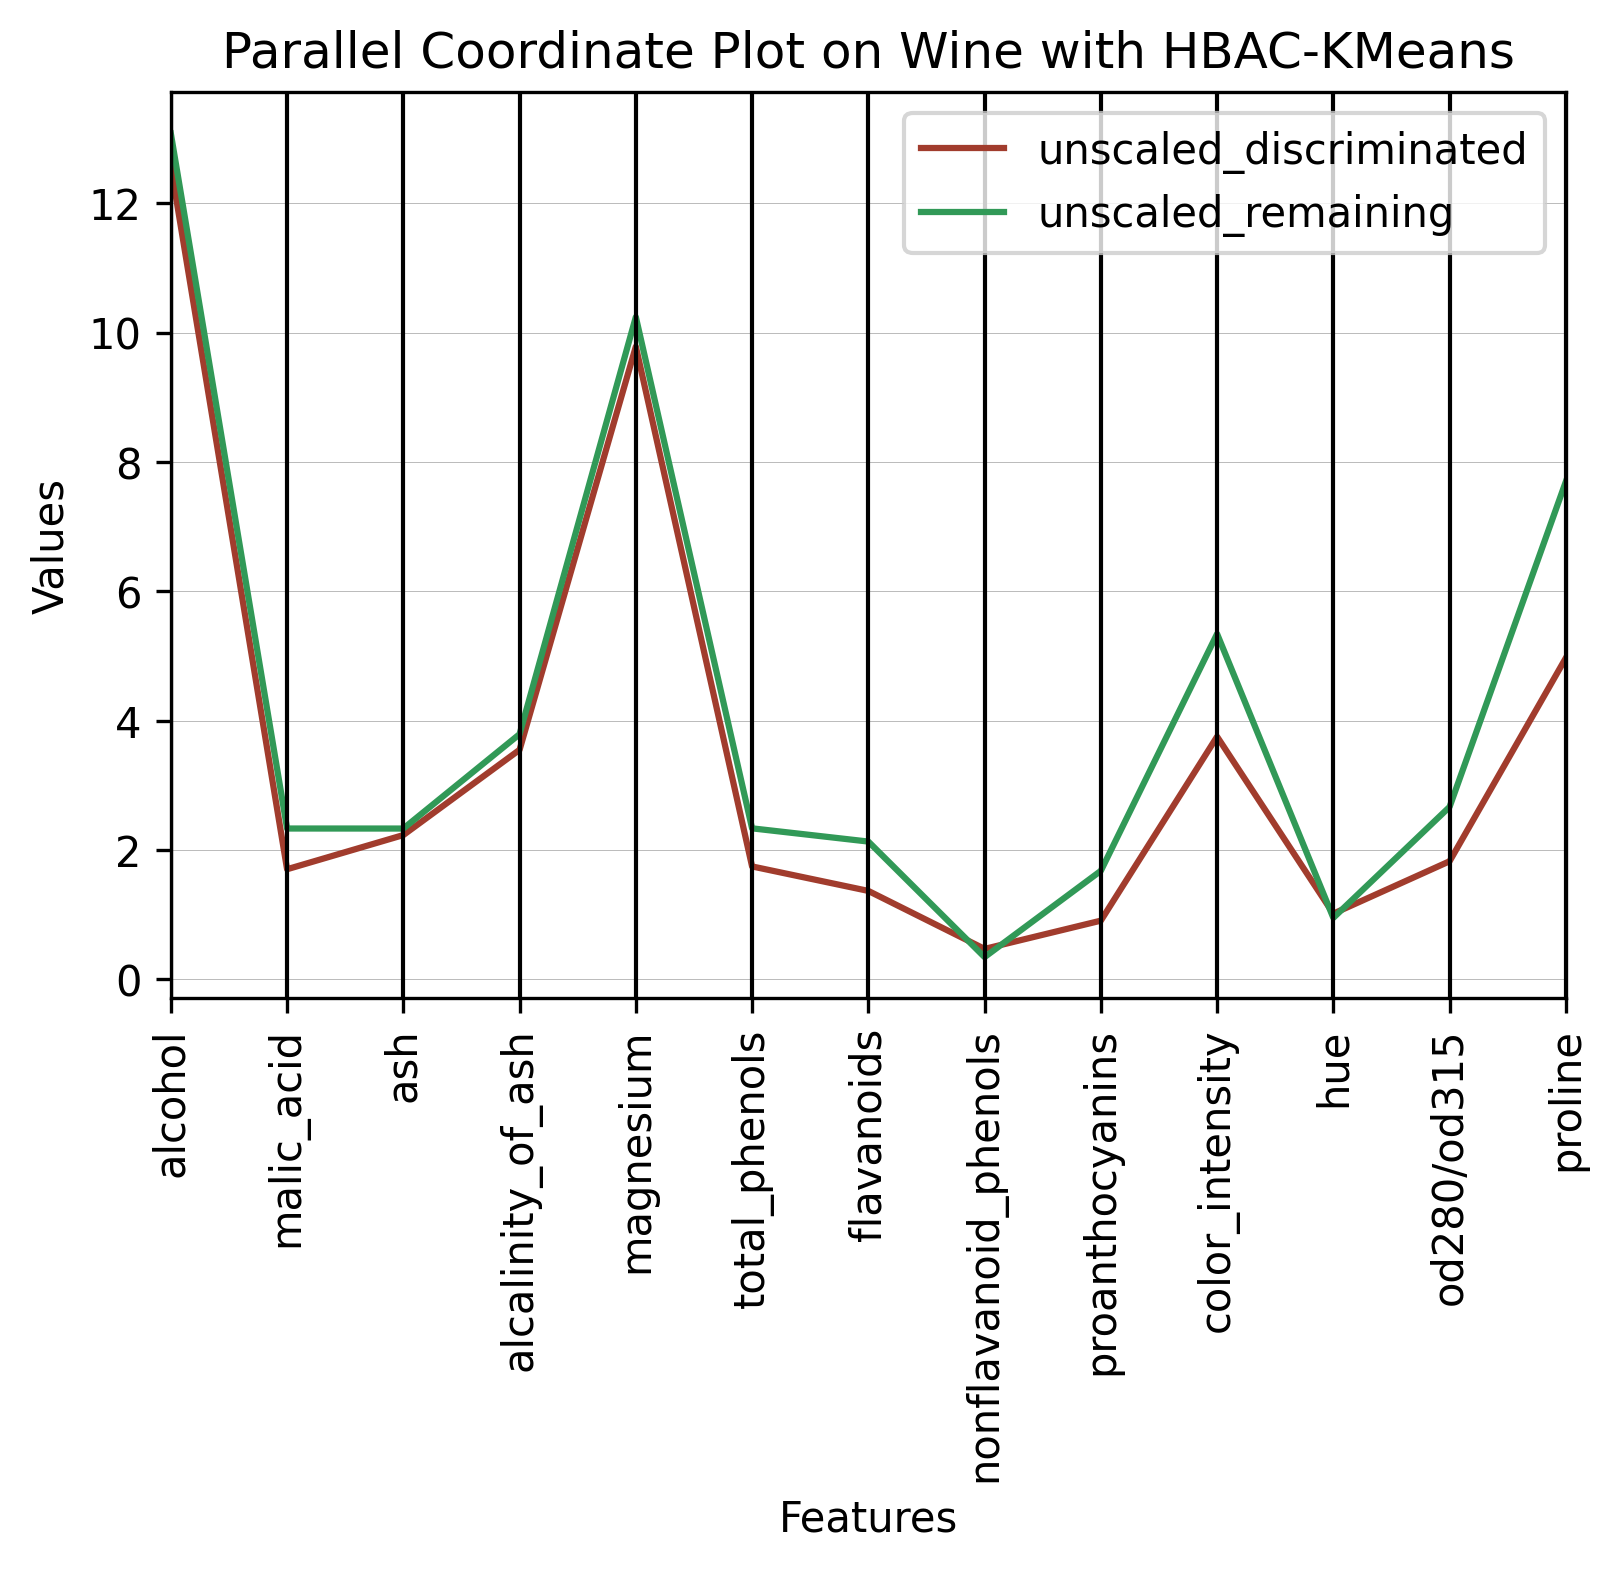

In [22]:
# altered for wine
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# wine alterations
unscaled_remaining['proline'] = unscaled_remaining['proline'].div(100).round(2)
unscaled_discriminated['proline'] = unscaled_discriminated['proline'].div(100).round(2)
unscaled_remaining['magnesium'] = unscaled_remaining['magnesium'].div(10).round(2)
unscaled_discriminated['magnesium'] = unscaled_discriminated['magnesium'].div(10).round(2)
unscaled_remaining['alcalinity_of_ash'] = unscaled_remaining['alcalinity_of_ash'].div(5).round(2)
unscaled_discriminated['alcalinity_of_ash'] = unscaled_discriminated['alcalinity_of_ash'].div(5).round(2)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welcthe h_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
df_parallel = df_parallel.drop(['true_class', 'predicted_class', 'errors'])
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on Wine with HBAC-KMeans")

## Ridgeline / Density plot

In [9]:
column_names = unscaled_discriminated.iloc[: , : 12].columns
# column_names = unscaled_remaining.iloc[: , : ].columns
# full_data.iloc[: , : 24]
column_names

# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on COMPAS: Discriminated Cluster distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

## Plotly 

In [18]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


In [19]:
df_all

Age  Job  Credit amount  Duration  Purpose_car  \
136   27    2           8613        27            1   
76    34    2           3965        42            0   
280   23    2           3368        15            1   
319   27    1           3643        15            0   
174   26    2           3414        21            0   
..   ...  ...            ...       ...          ...   
132   27    1           2708        15            0   
185   31    2           1360        15            0   
41    26    2           1158        12            0   
108   30    2           7721        24            0   
56    52    3           6468        12            0   

     Purpose_domestic appliances  Purpose_education  \
136                            0                  0   
76                             0                  0   
280                            0                  0   
319                            0                  0   
174                            0                  1   
..                           ...                ...   
132                            0                  0   
185                            0                  0   
41                             0                  0   
108                            0                  0   
56                             0                  0   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  ...  \
136                            0                 0                0  ...   
76                             0                 1                0  ...   
280                            0                 0                0  ...   
319                            1                 0                0  ...   
174                            0                 0                0  ...   
..                           ...               ...              ...  ...   
132                            1                 0                0  ...   
185                            0                 1                0  ...   
41                             0                 1                0  ...   
108                            1                 0                0  ...   
56                             0                 1                0  ...   

     Check_moderate  Check_no_inf  Check_rich  Age_cat_Young  Age_cat_Adult  \
136               0             1           0              1              0   
76                0             0           0              1              0   
280               0             1           0              0              0   
319               0             0           0              1              0   
174               0             0           0              1              0   
..              ...           ...         ...            ...            ...   
132               0             1           0              1              0   
185               0             1           0              1              0   
41                1             0           0              1              0   
108               0             0           0              1              0   
56                1             0           0              0              1   

     Age_cat_Senior  predicted_class  true_class  errors           bias  
136               0                0         0.0     0.0      remaining  
76                0                0         1.0     1.0      remaining  
280               0                0         0.0     0.0      remaining  
319               0                0         0.0     0.0      remaining  
174               0                0         1.0     1.0  discriminated  
..              ...              ...         ...     ...            ...  
132               0                0         0.0     0.0      remaining  
185               0                0         0.0     0.0      remaining  
41                0                0         0.0     0.0      remaining  
108               0                0         0.0     0.0      remaining  
56     

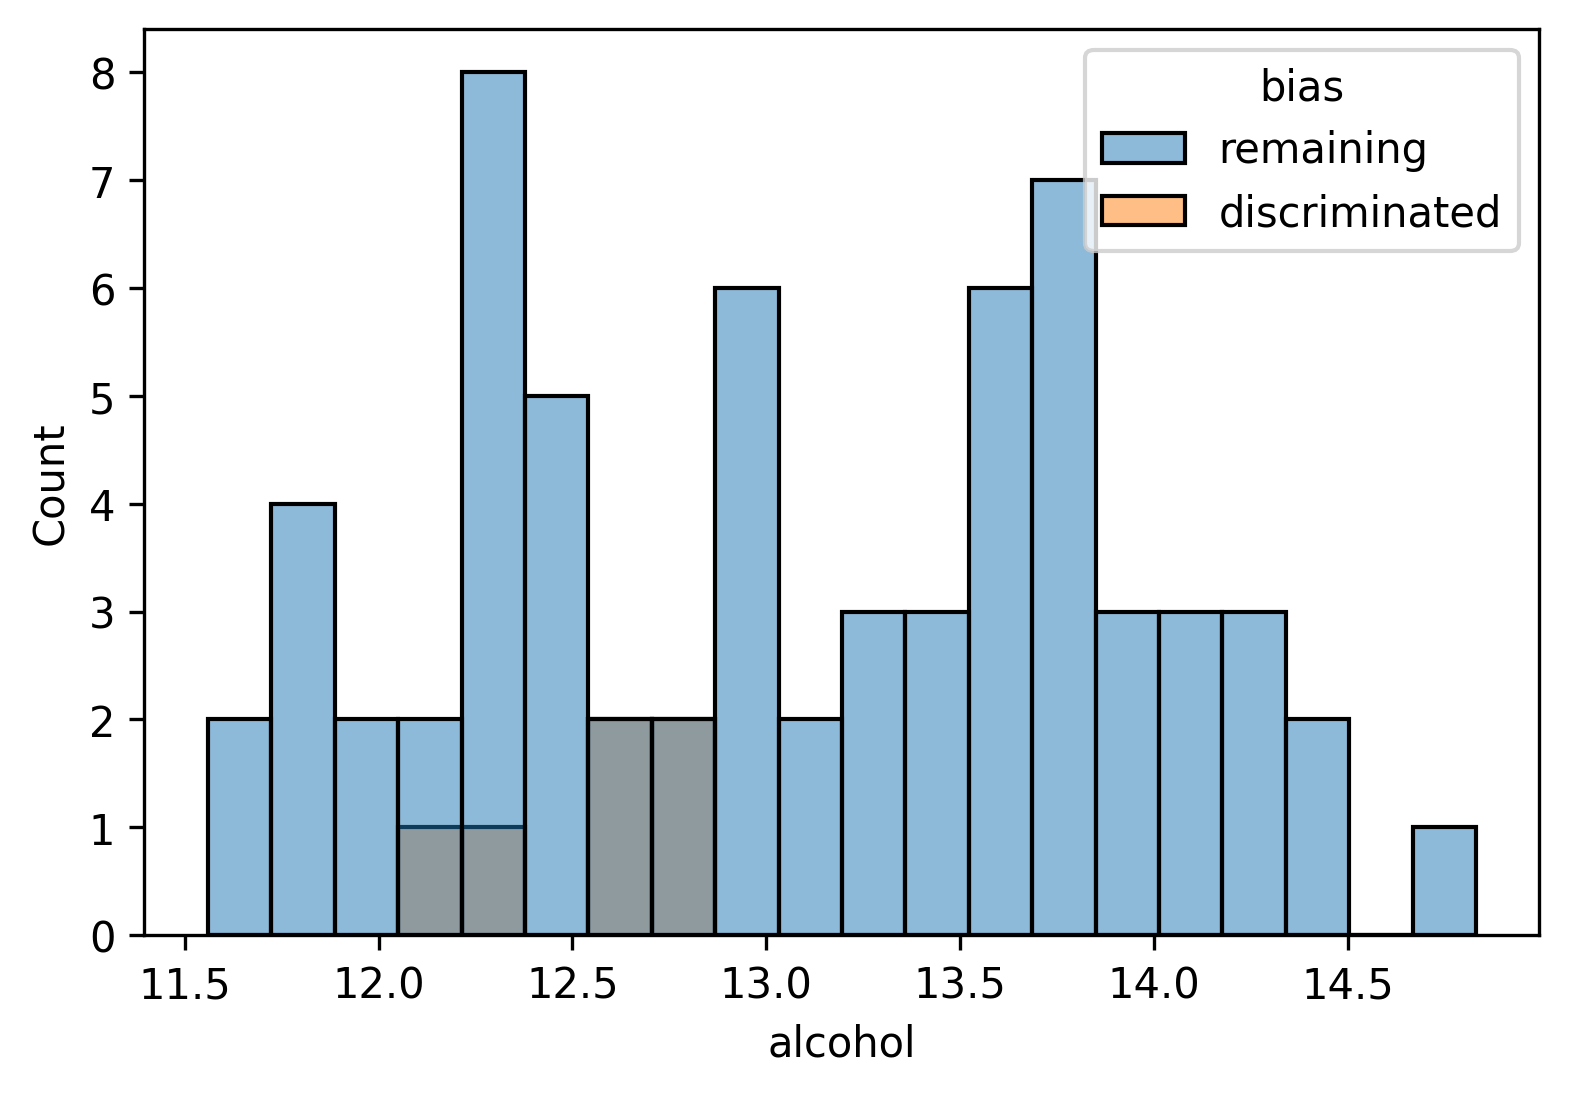

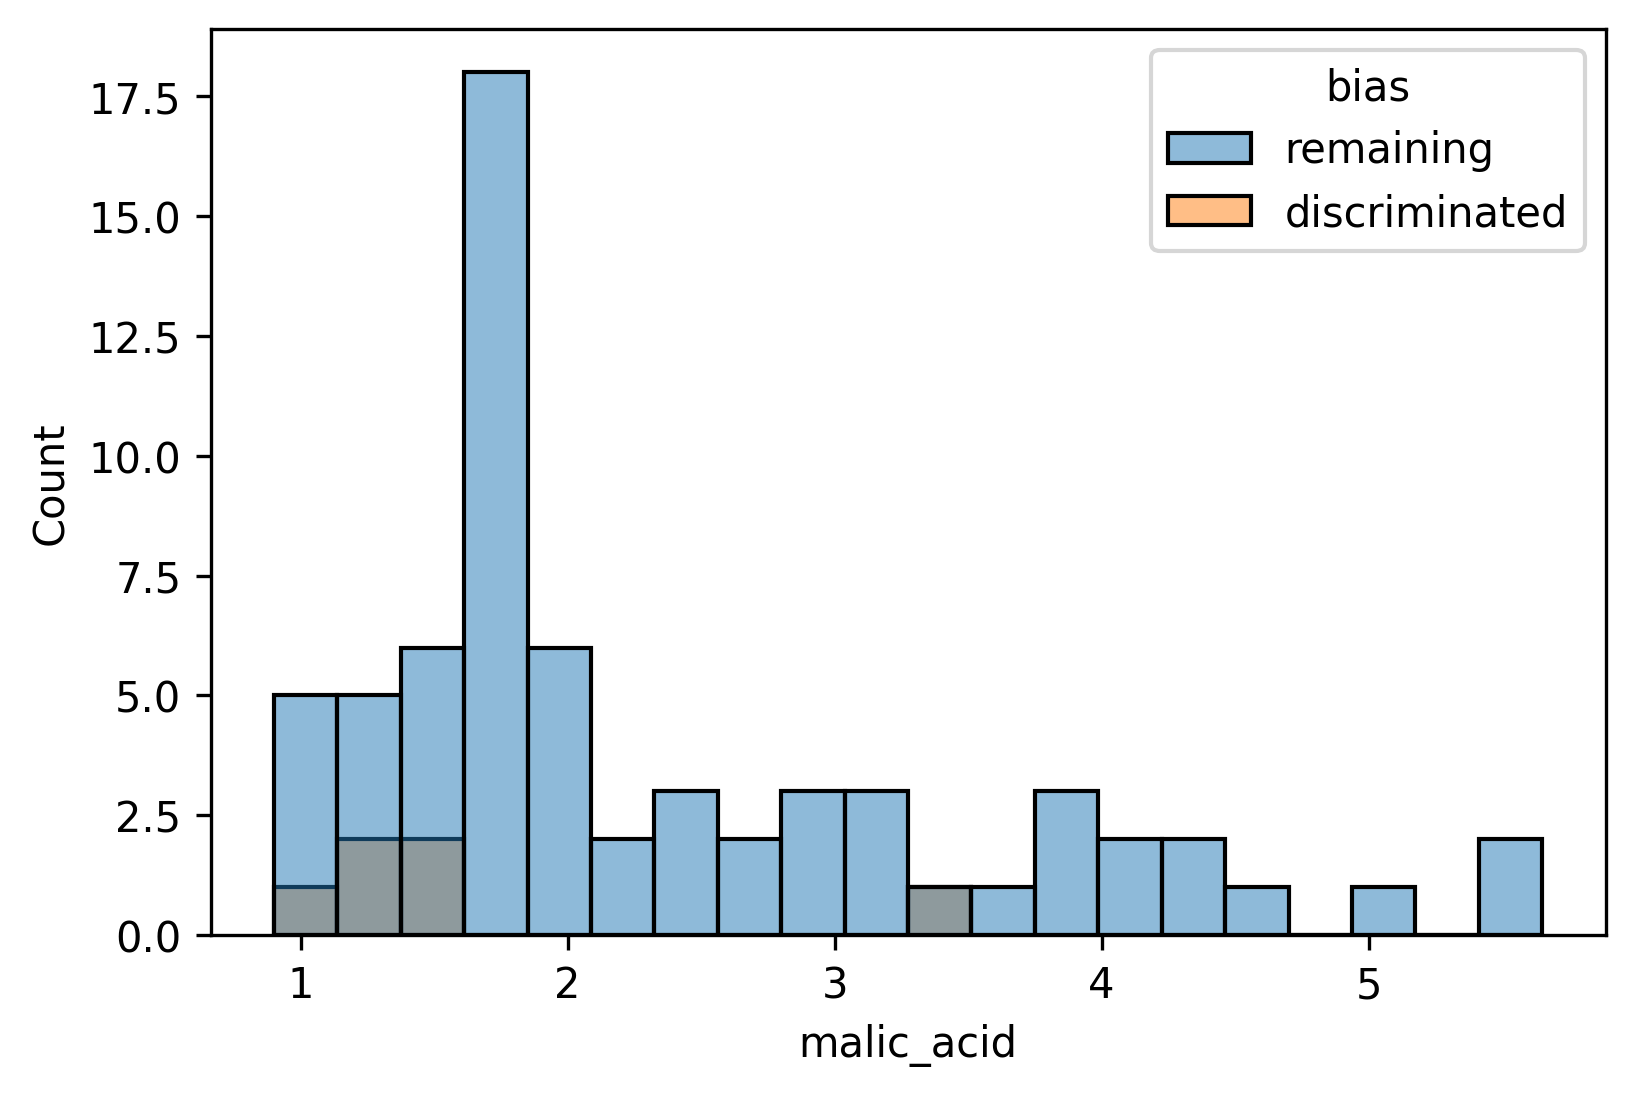

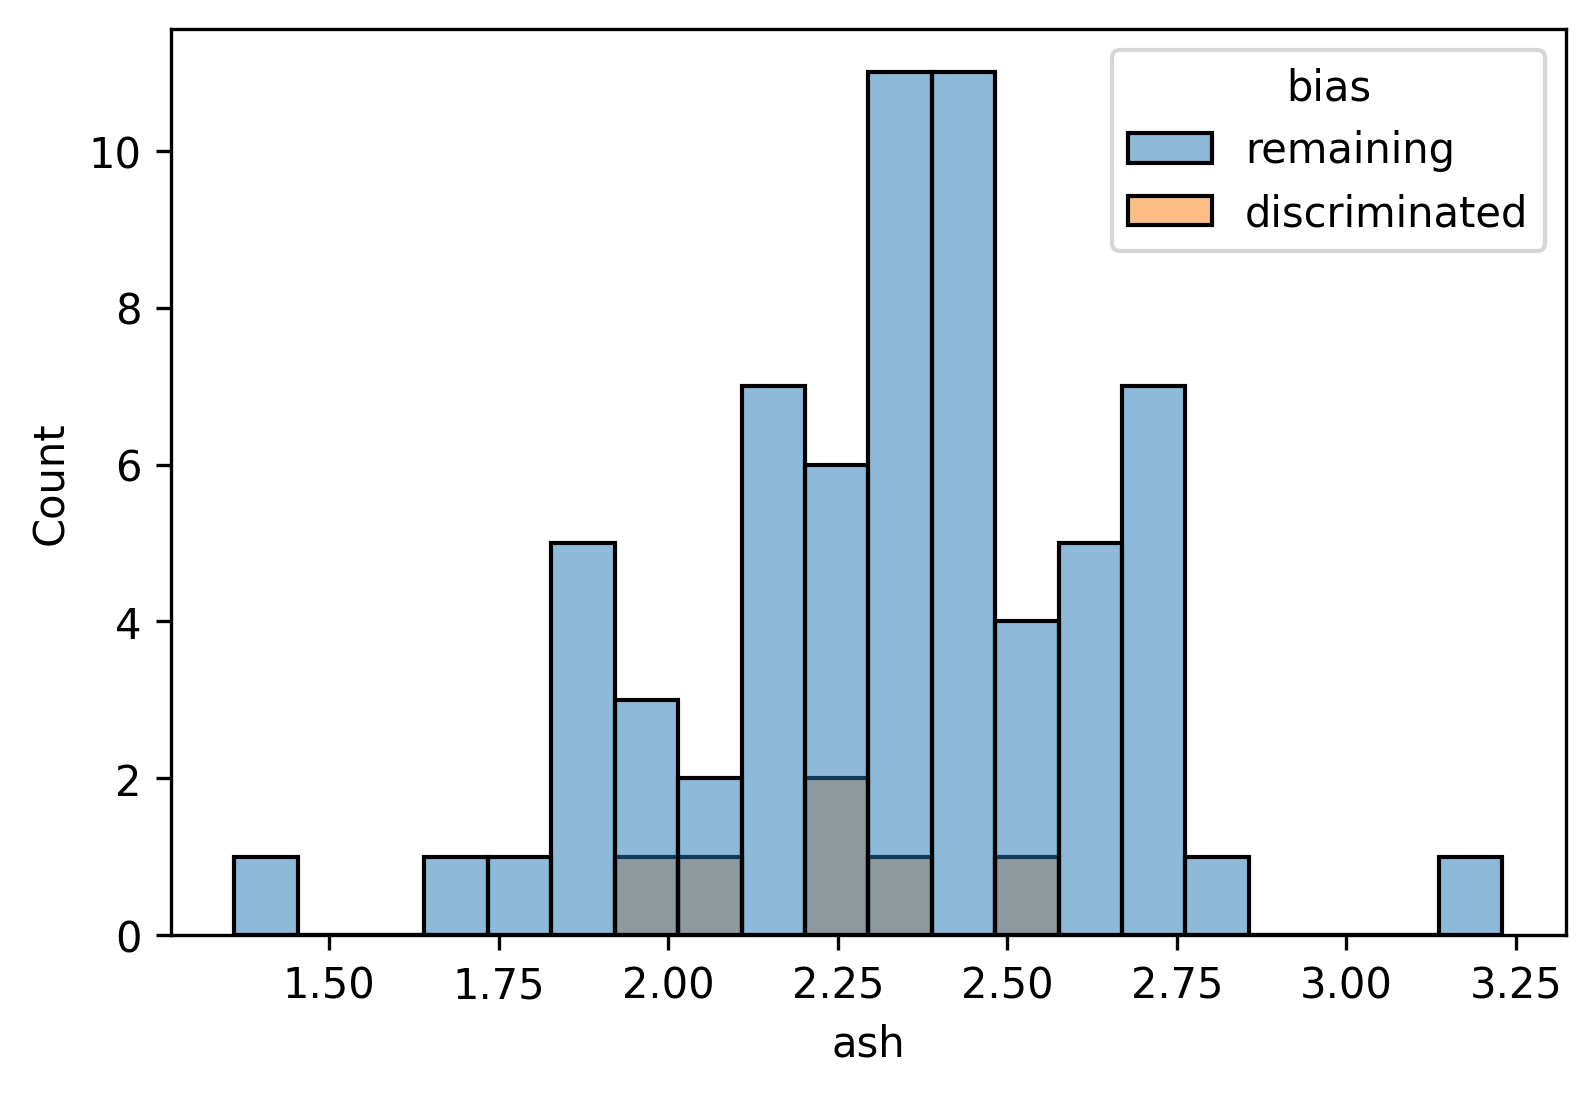

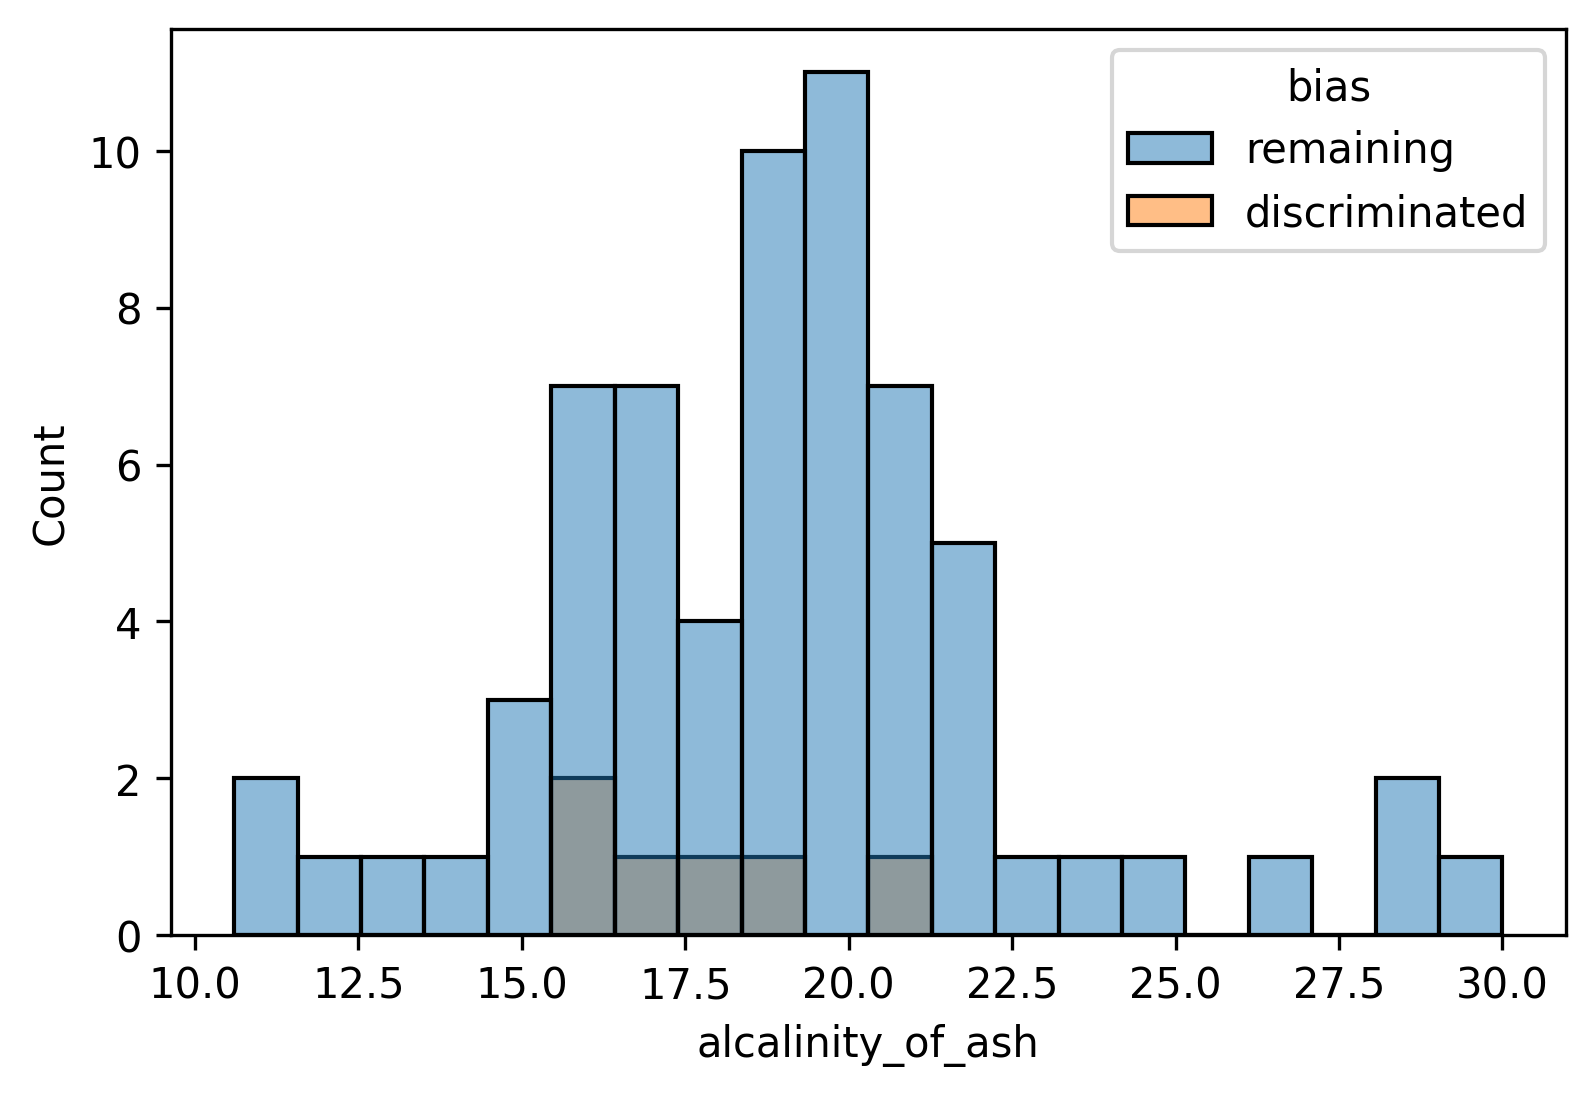

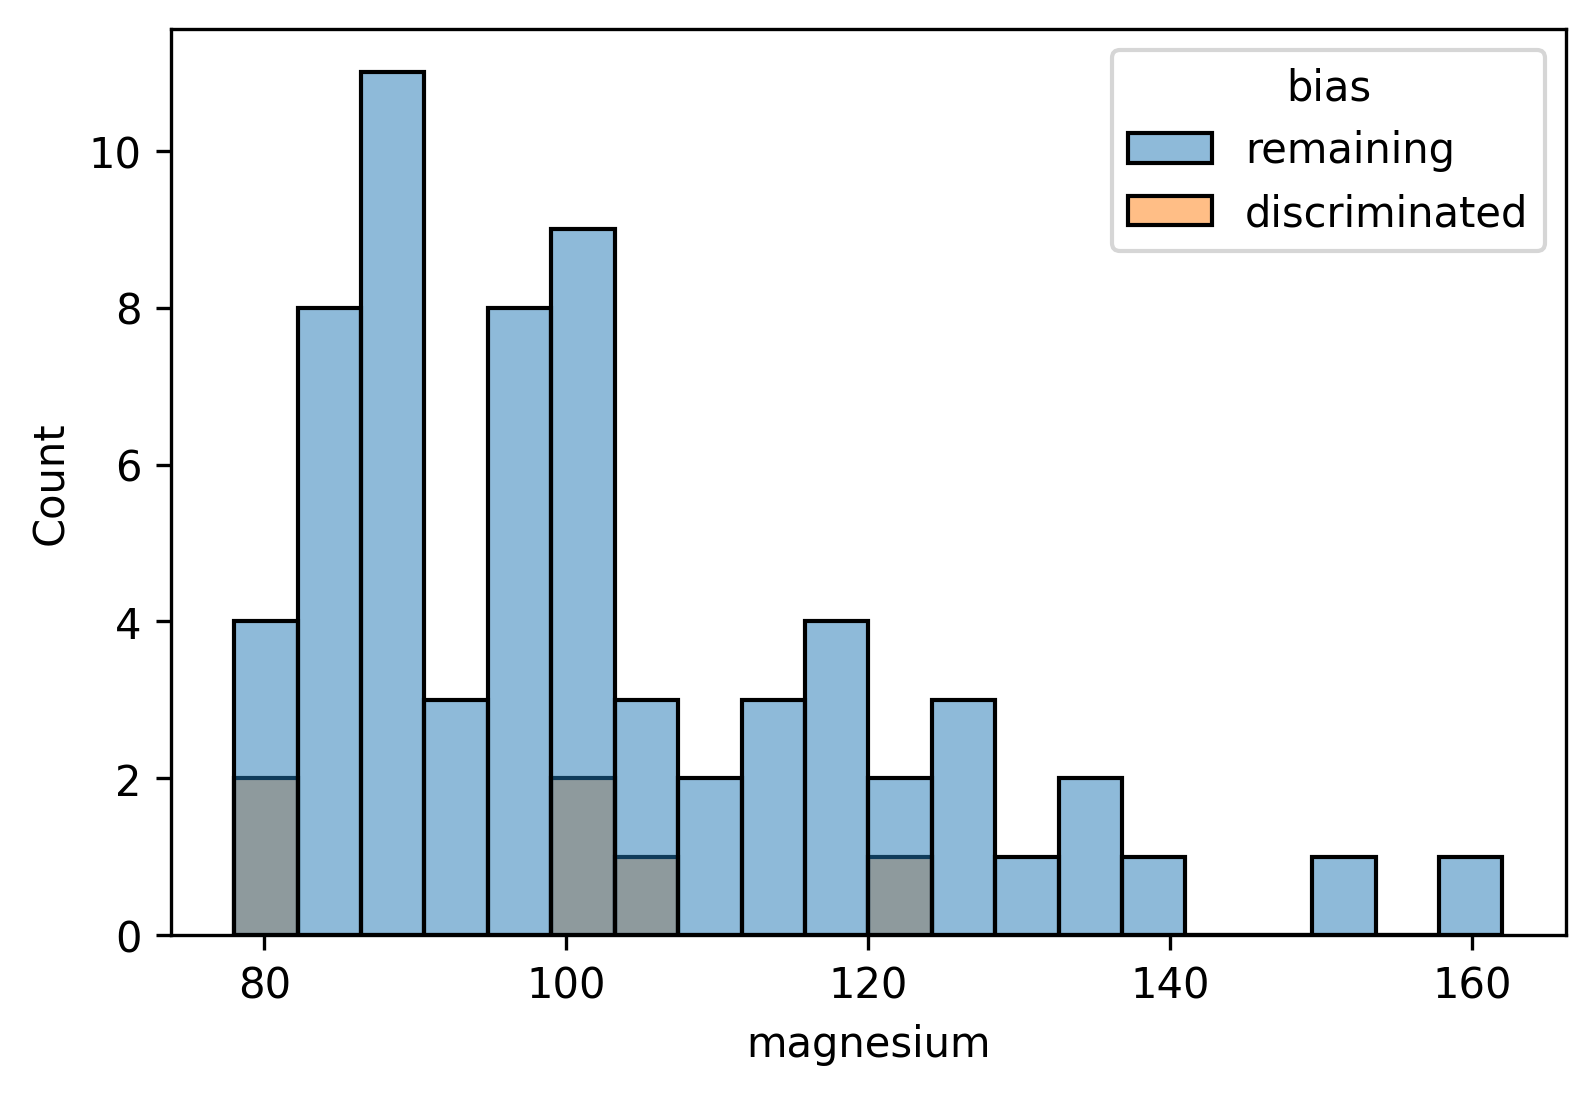

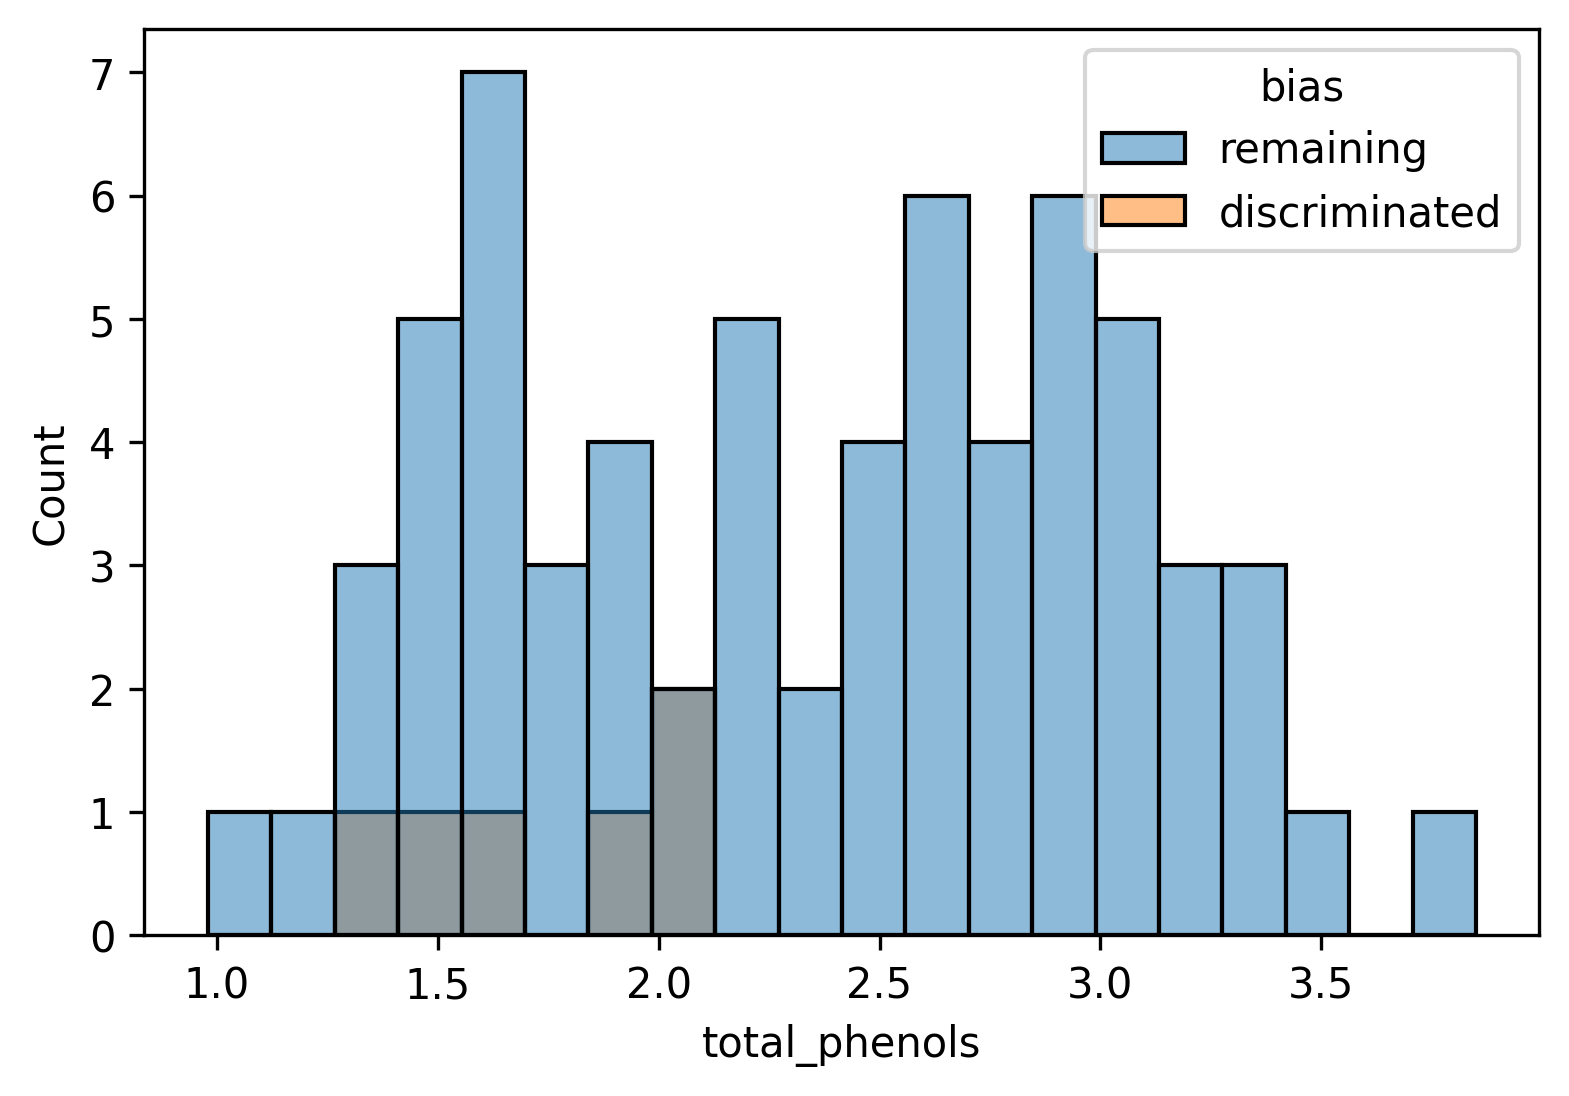

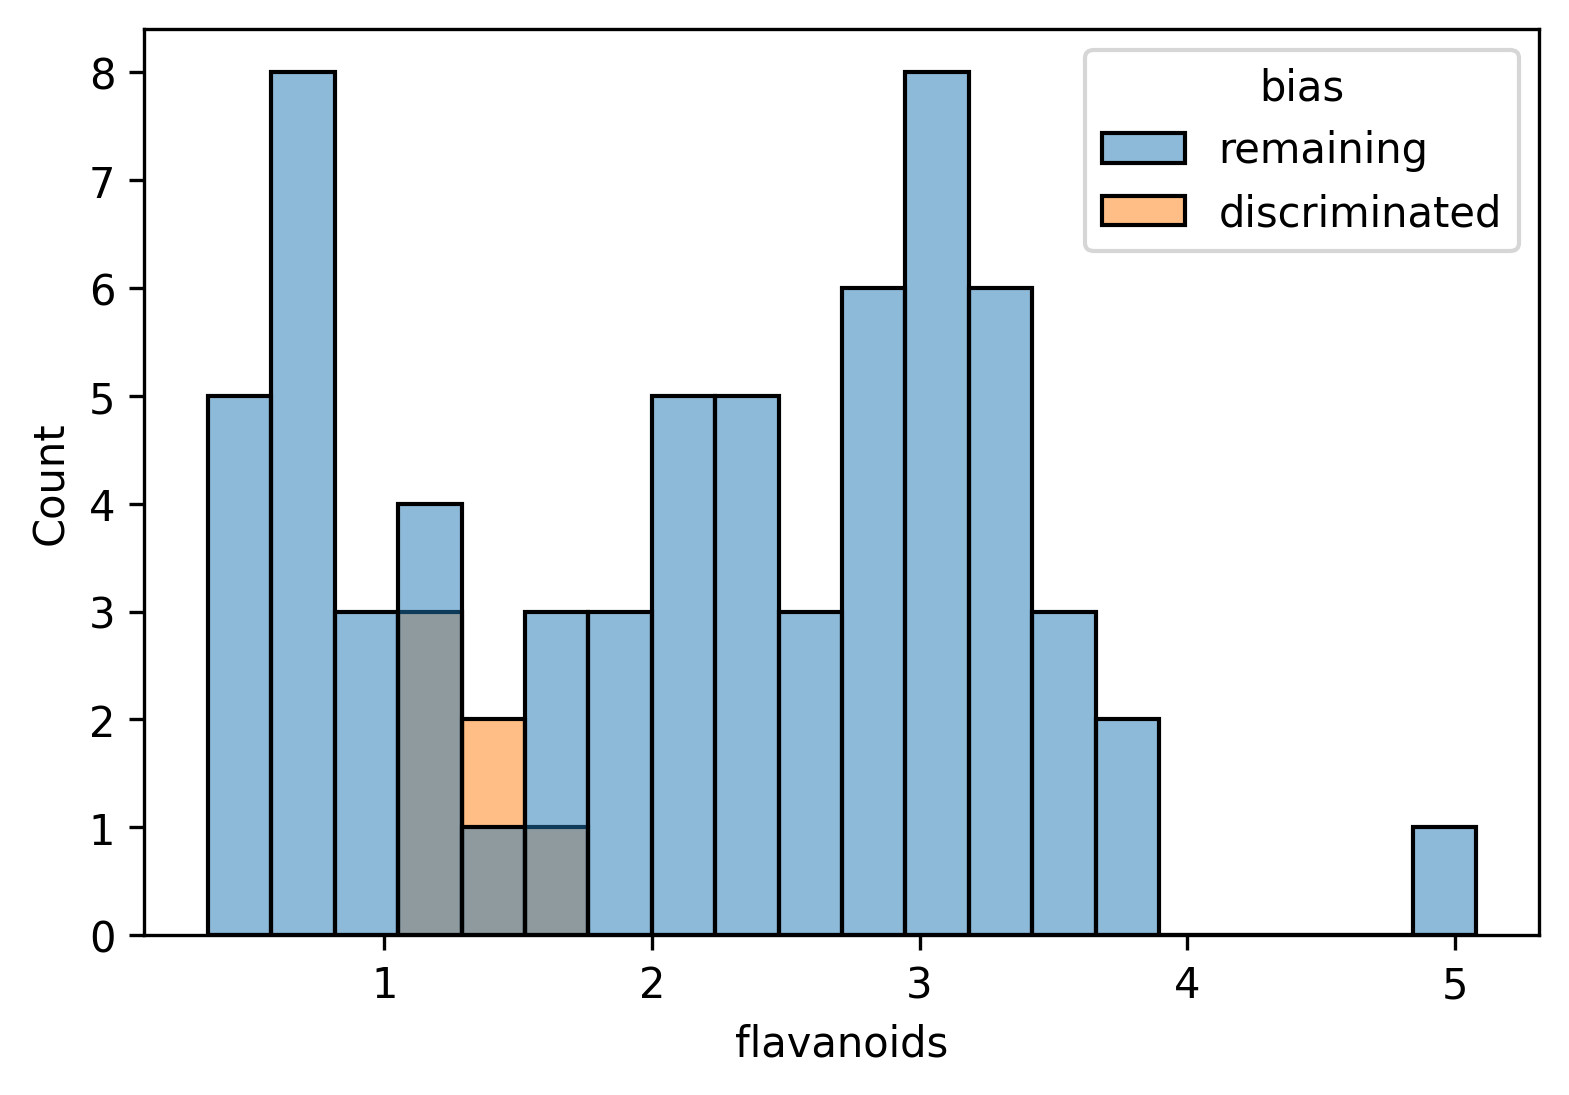

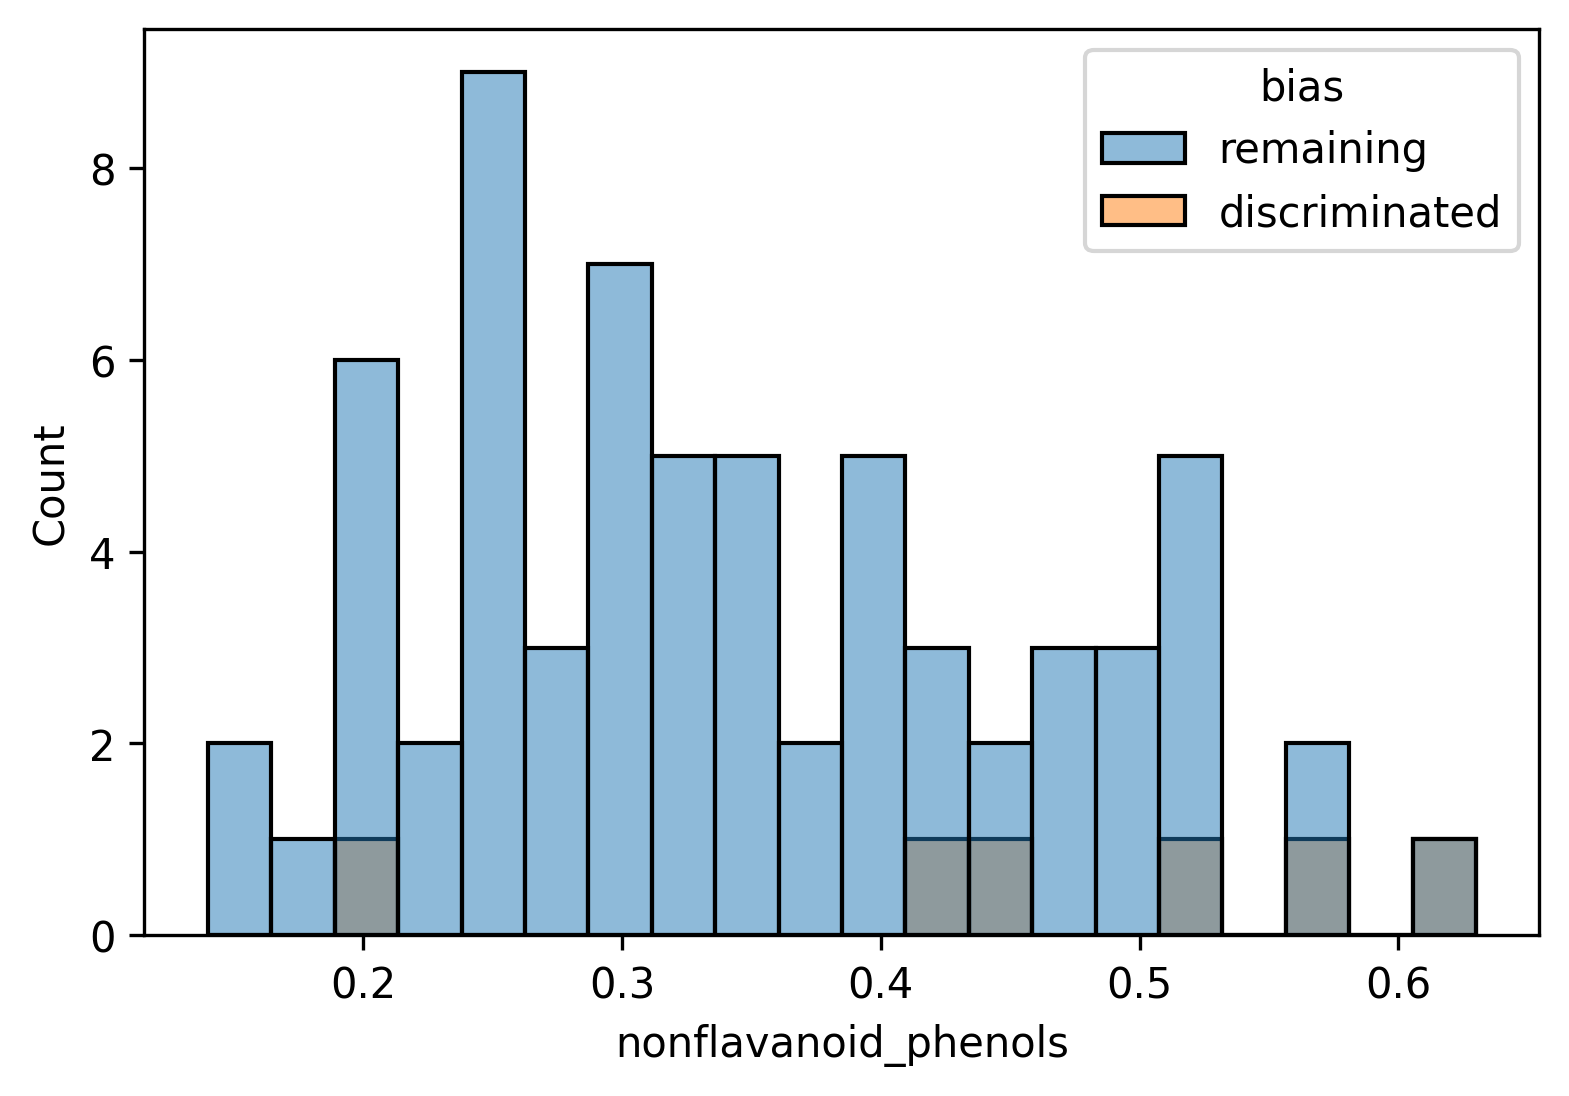

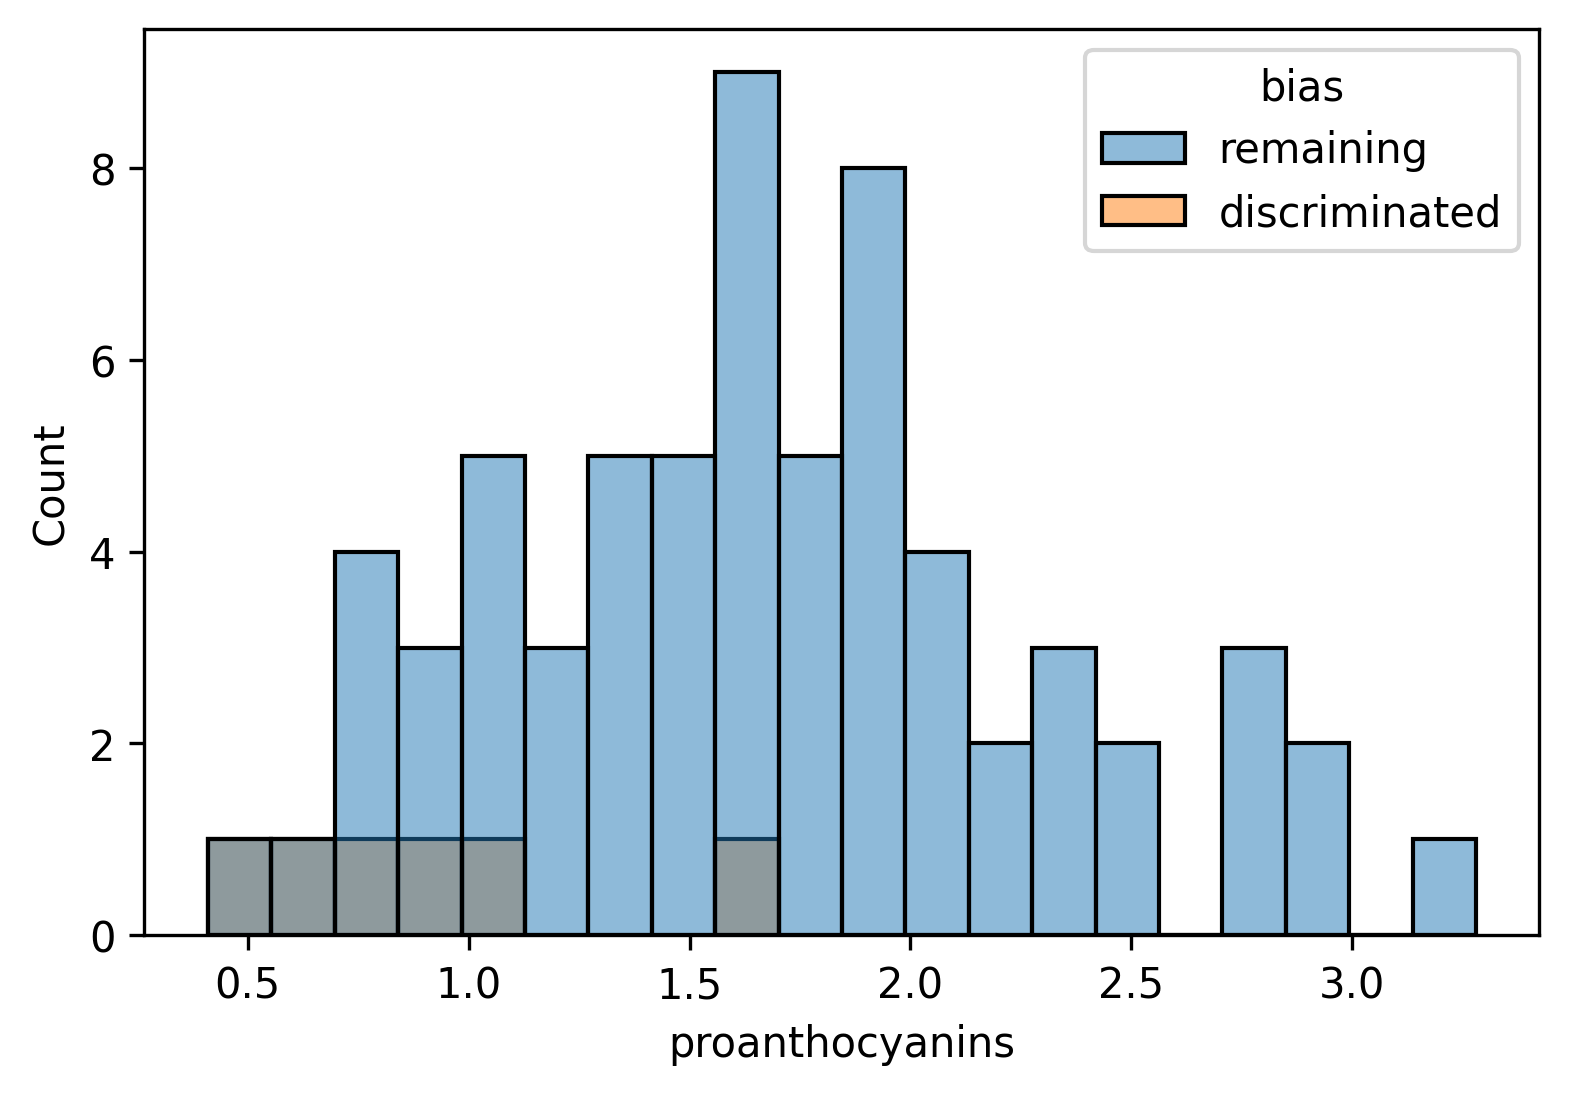

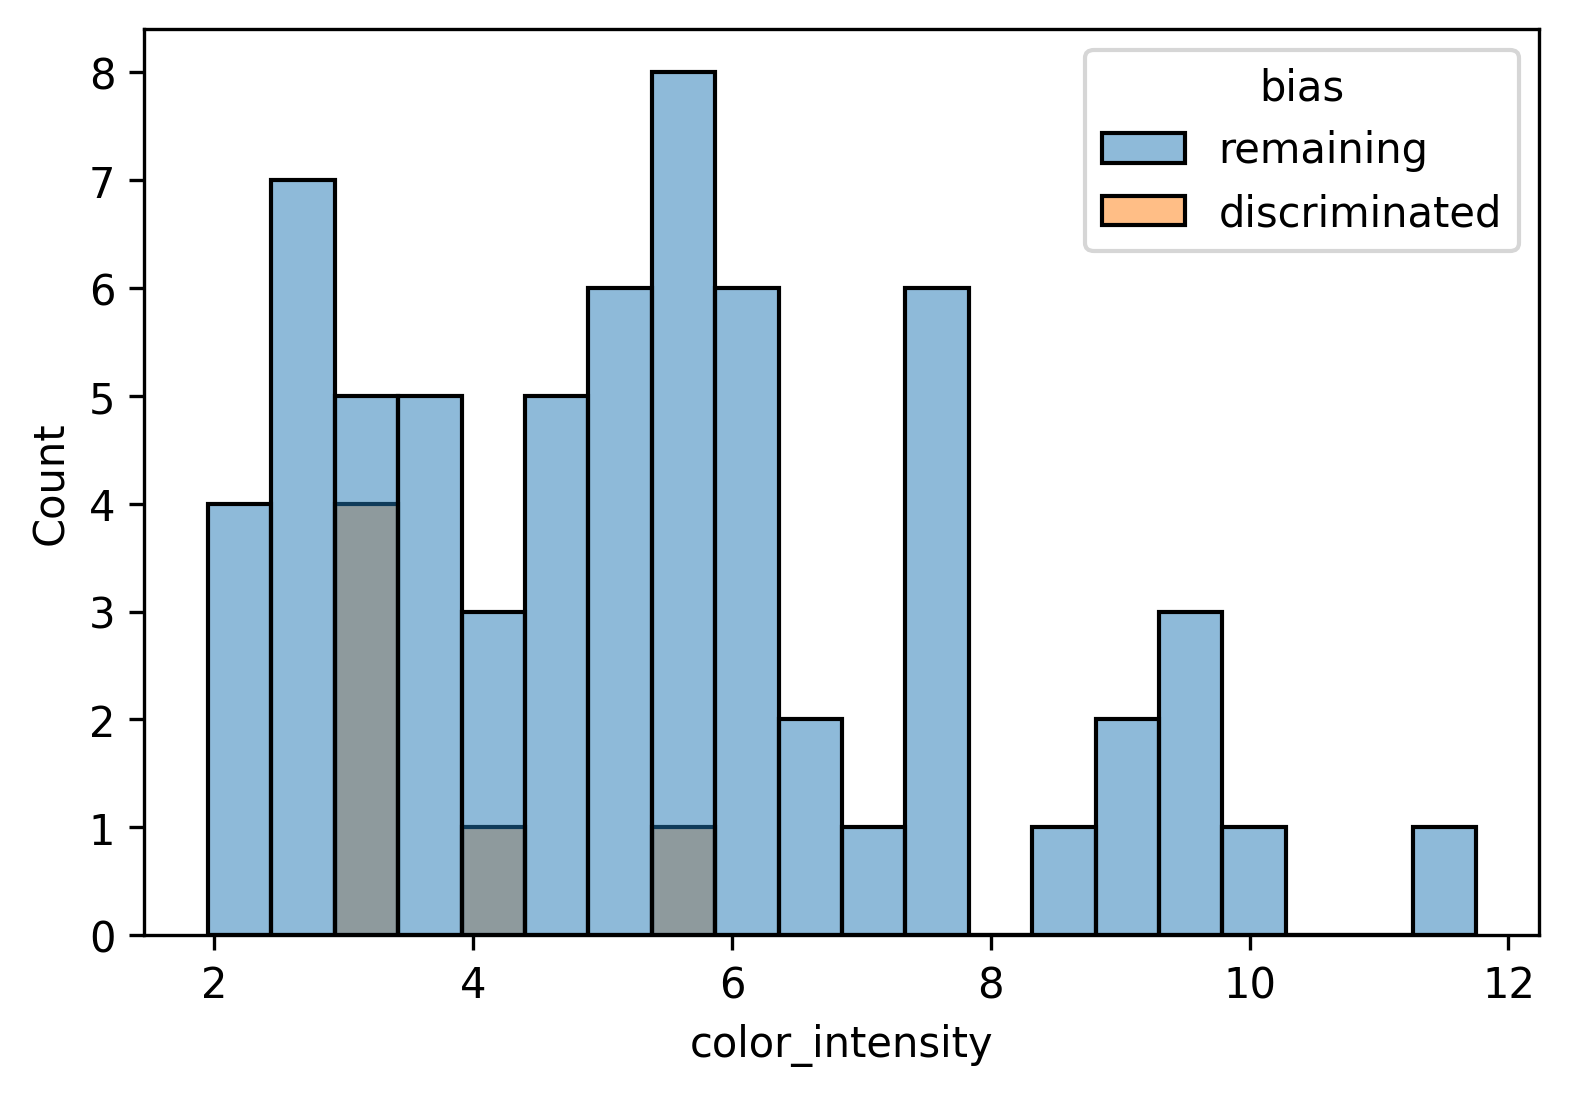

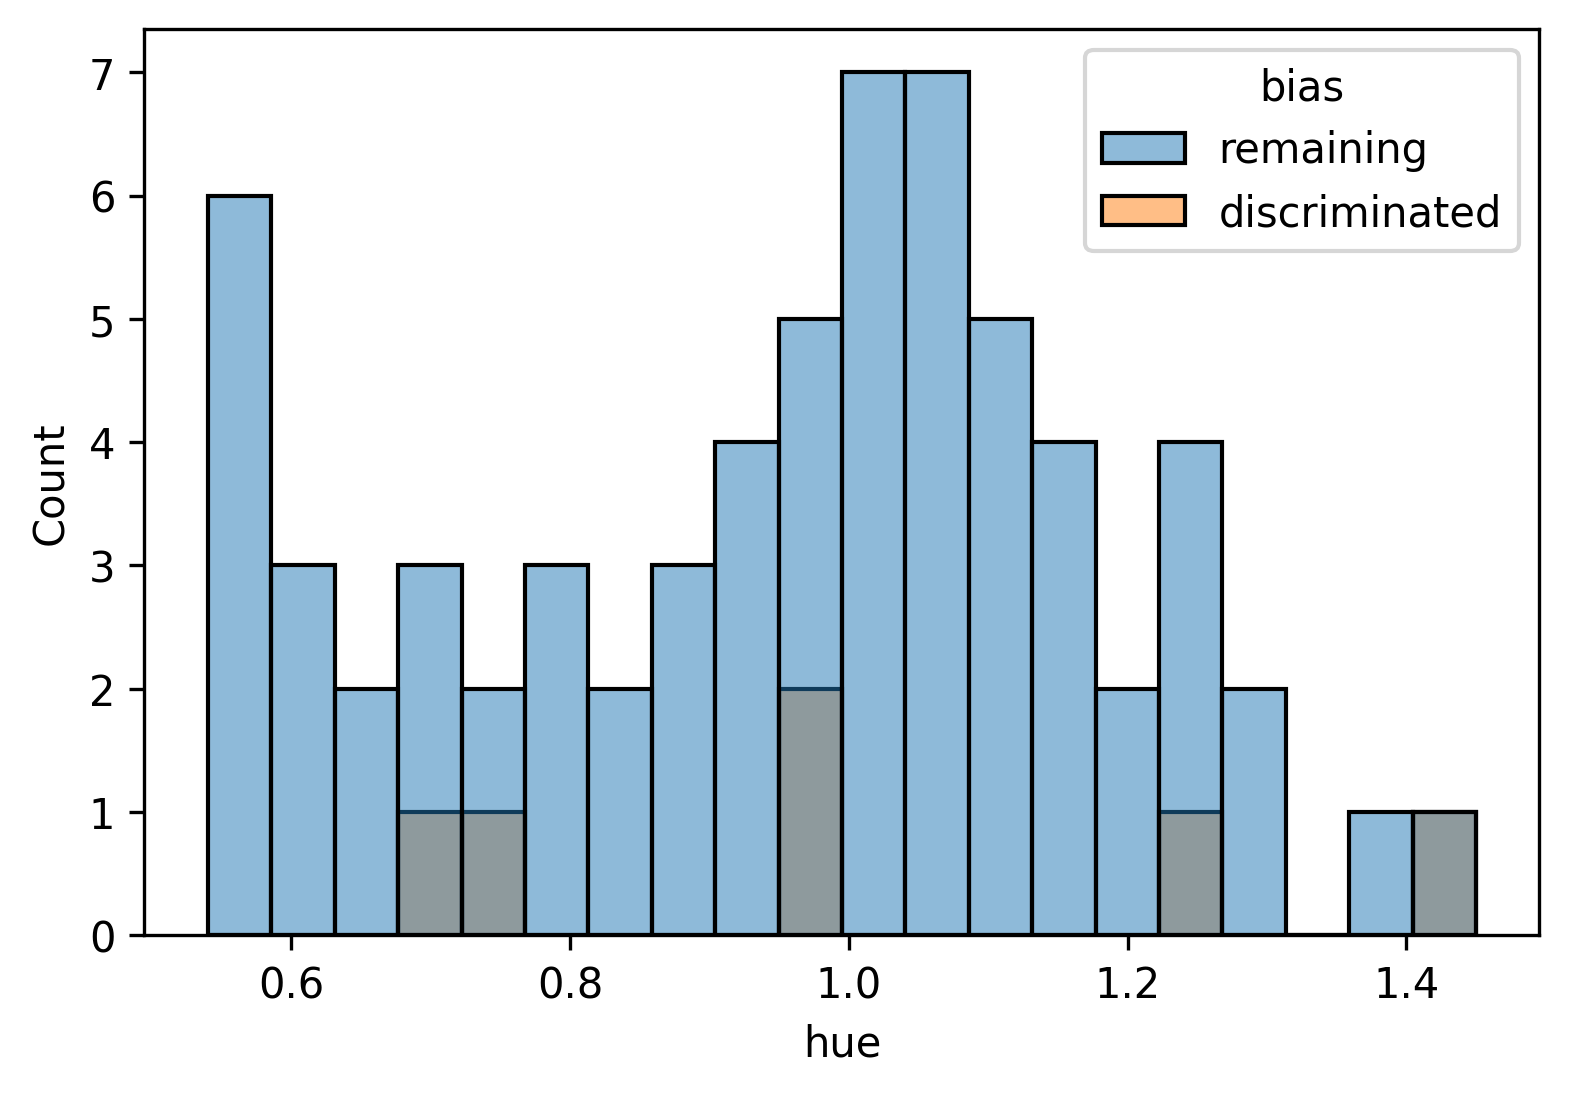

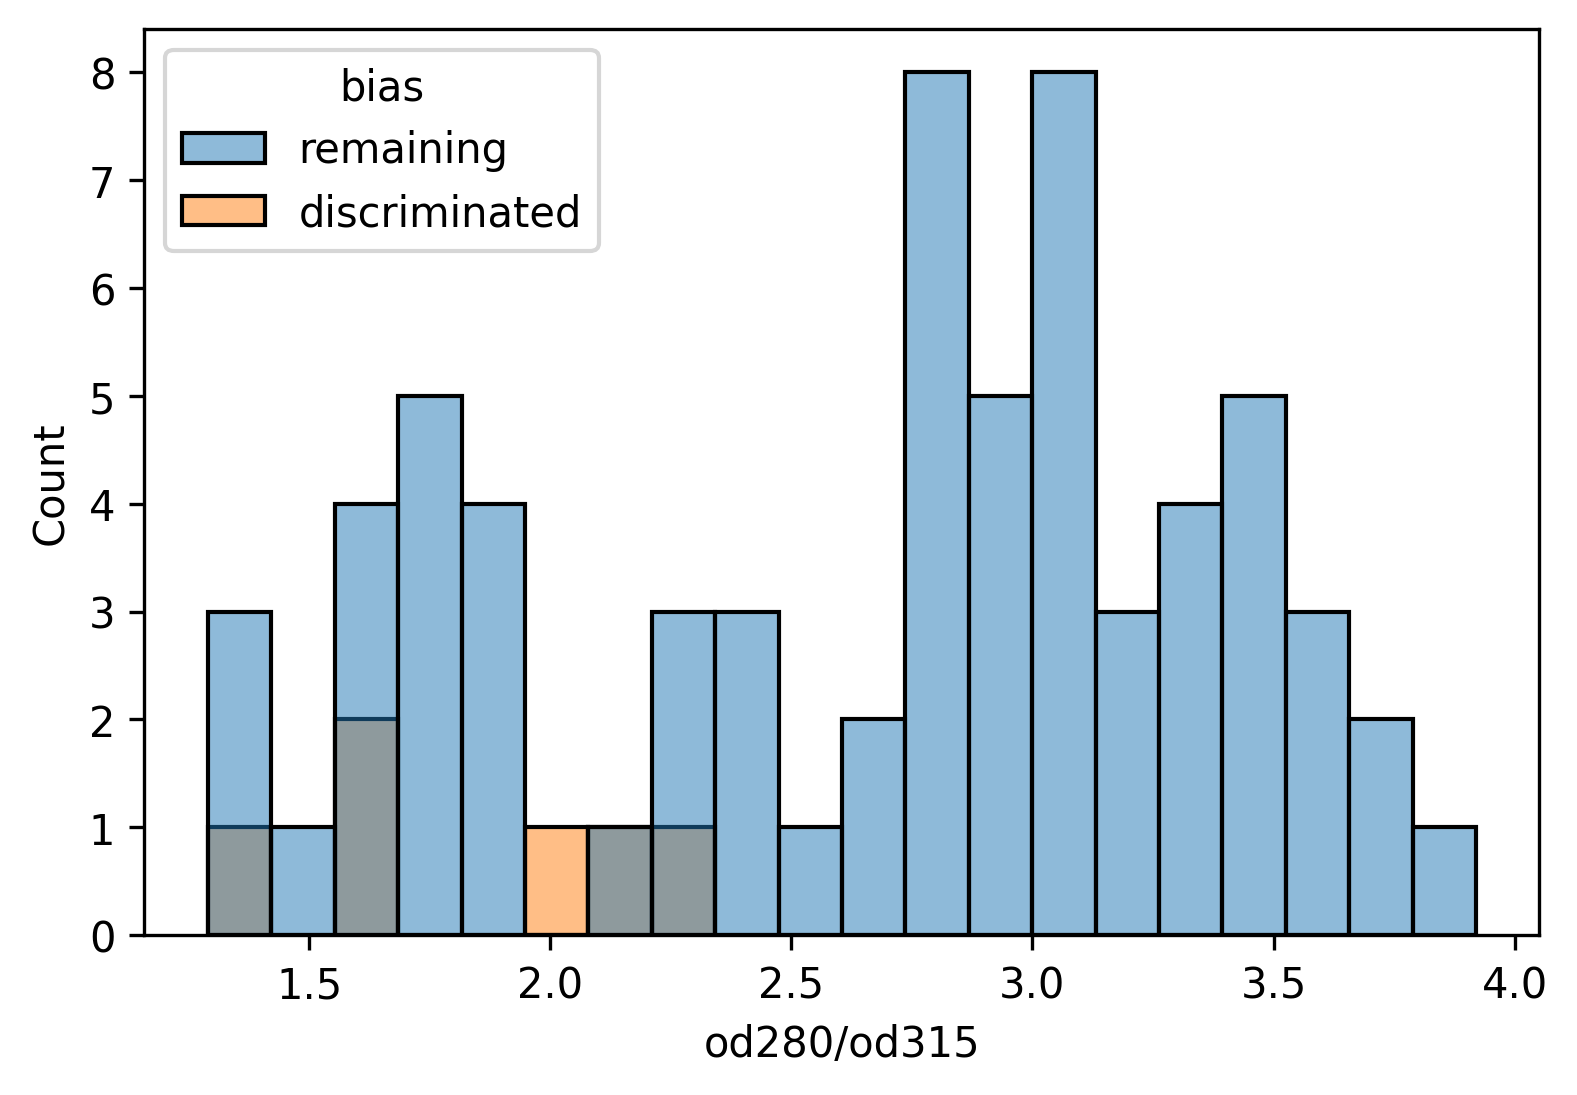

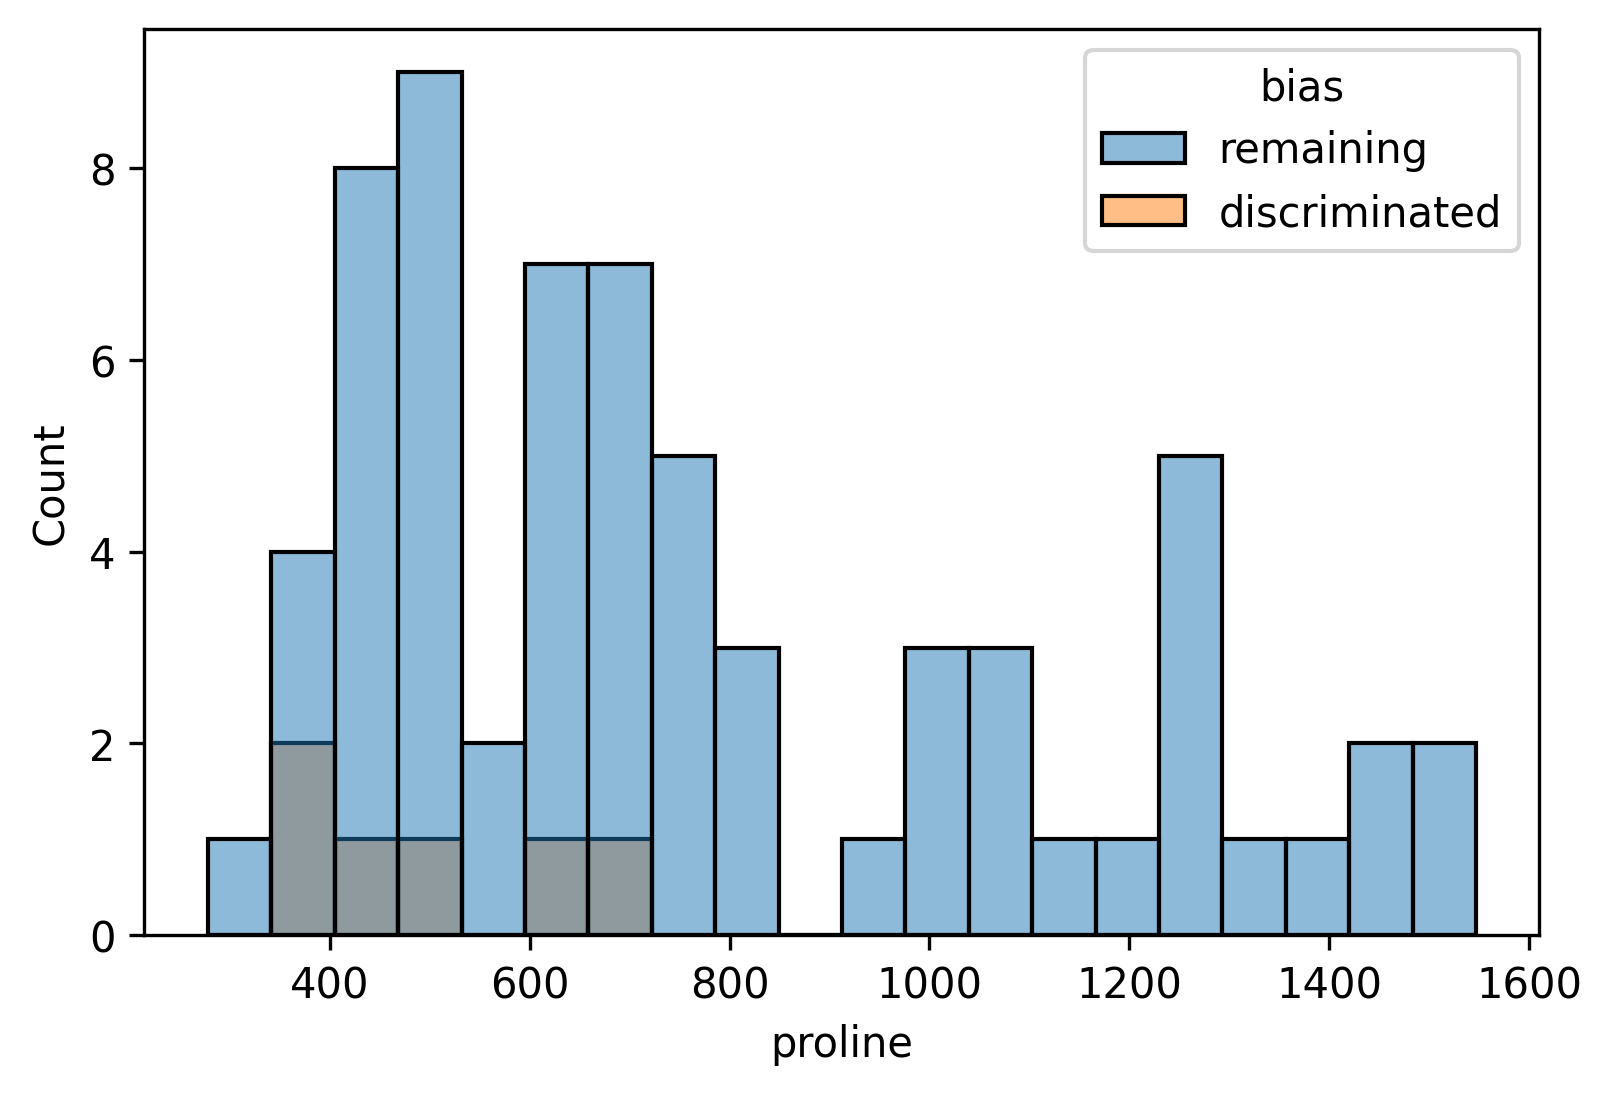

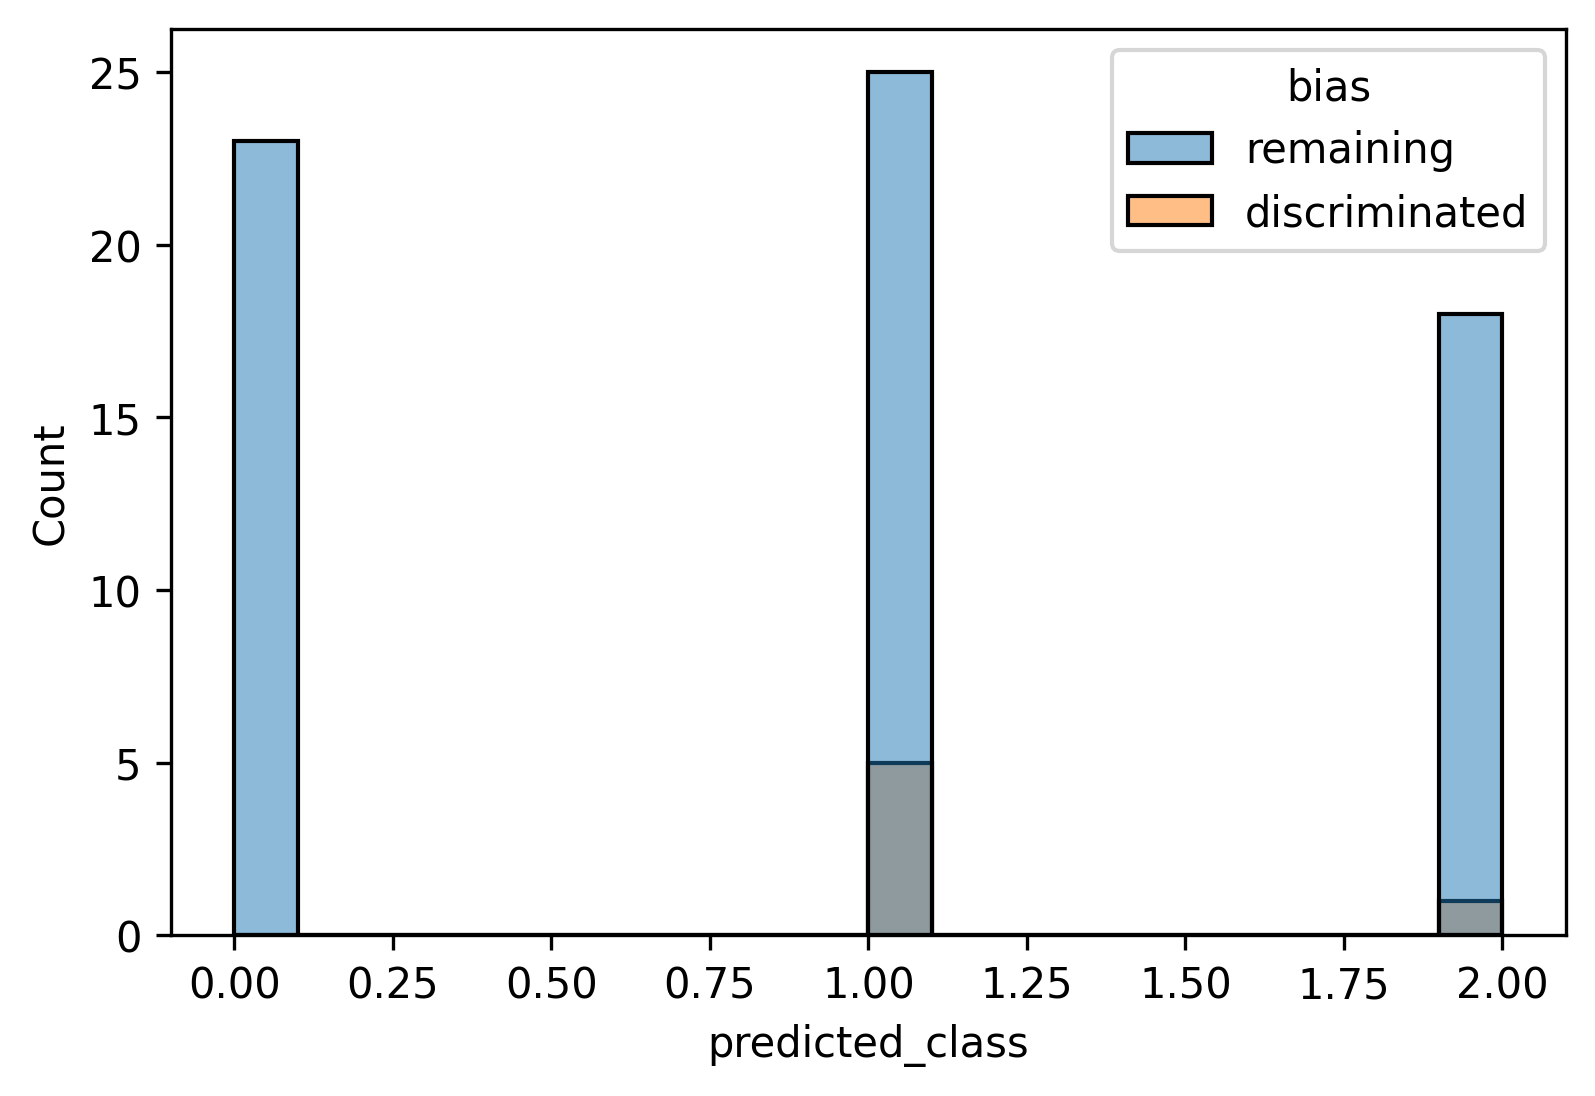

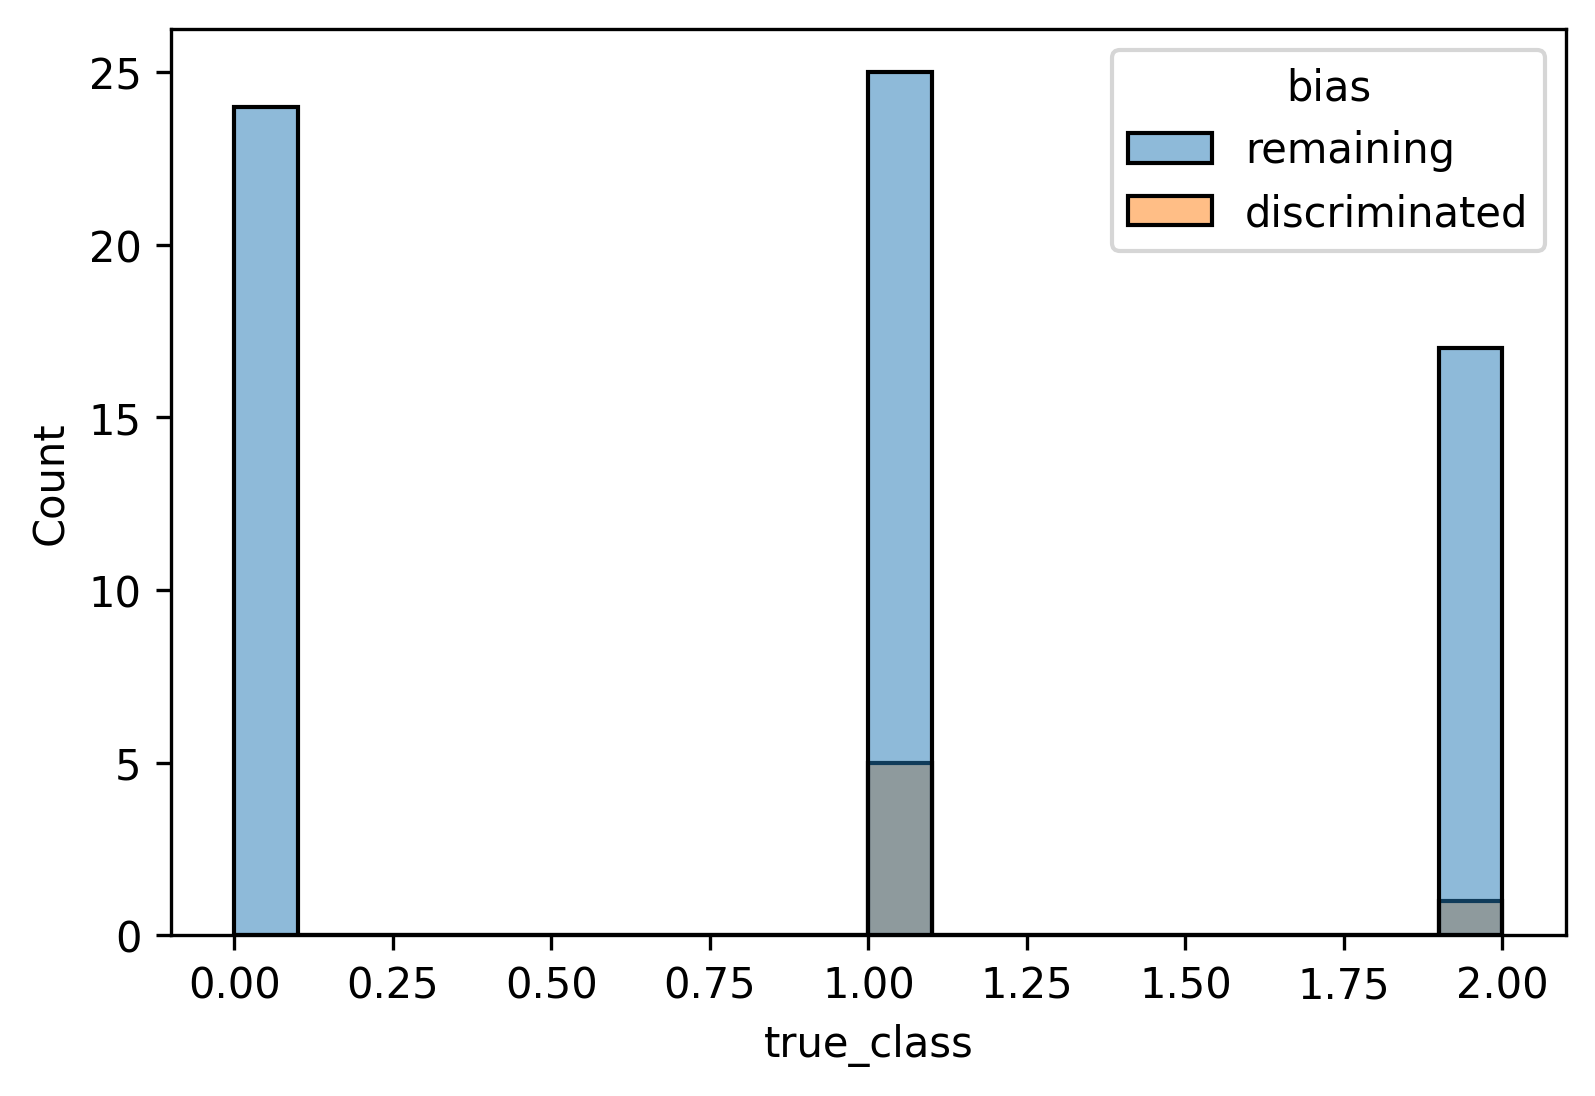

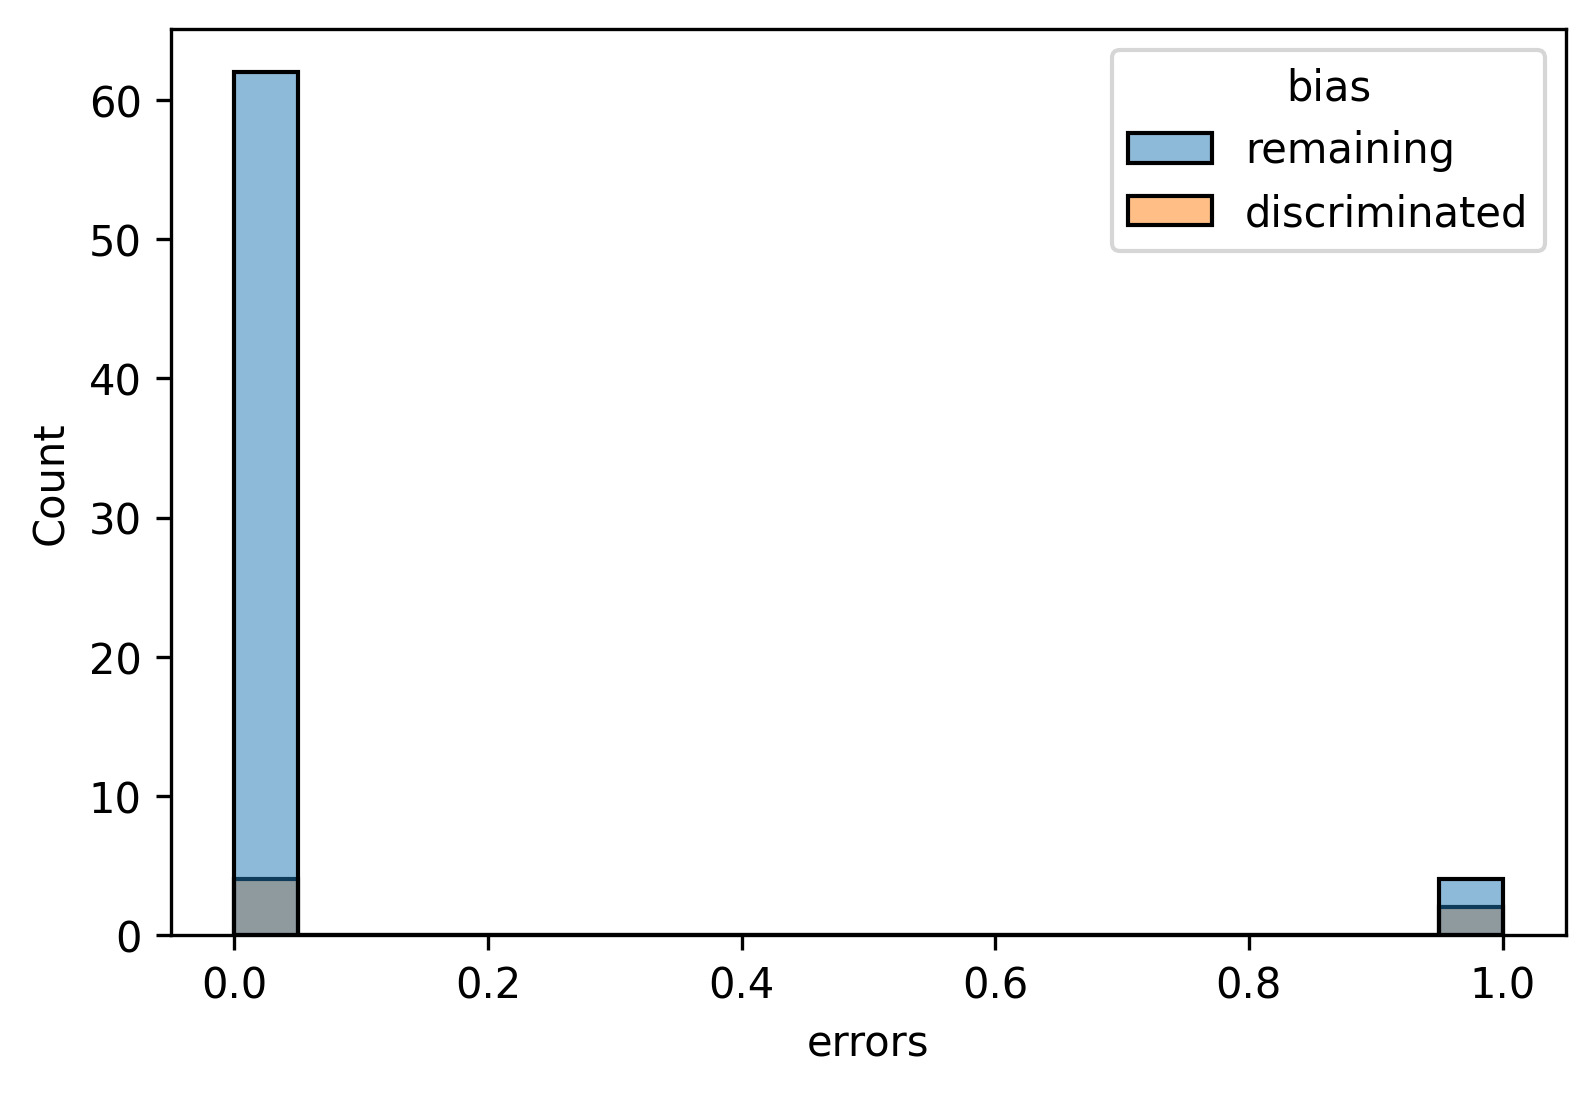

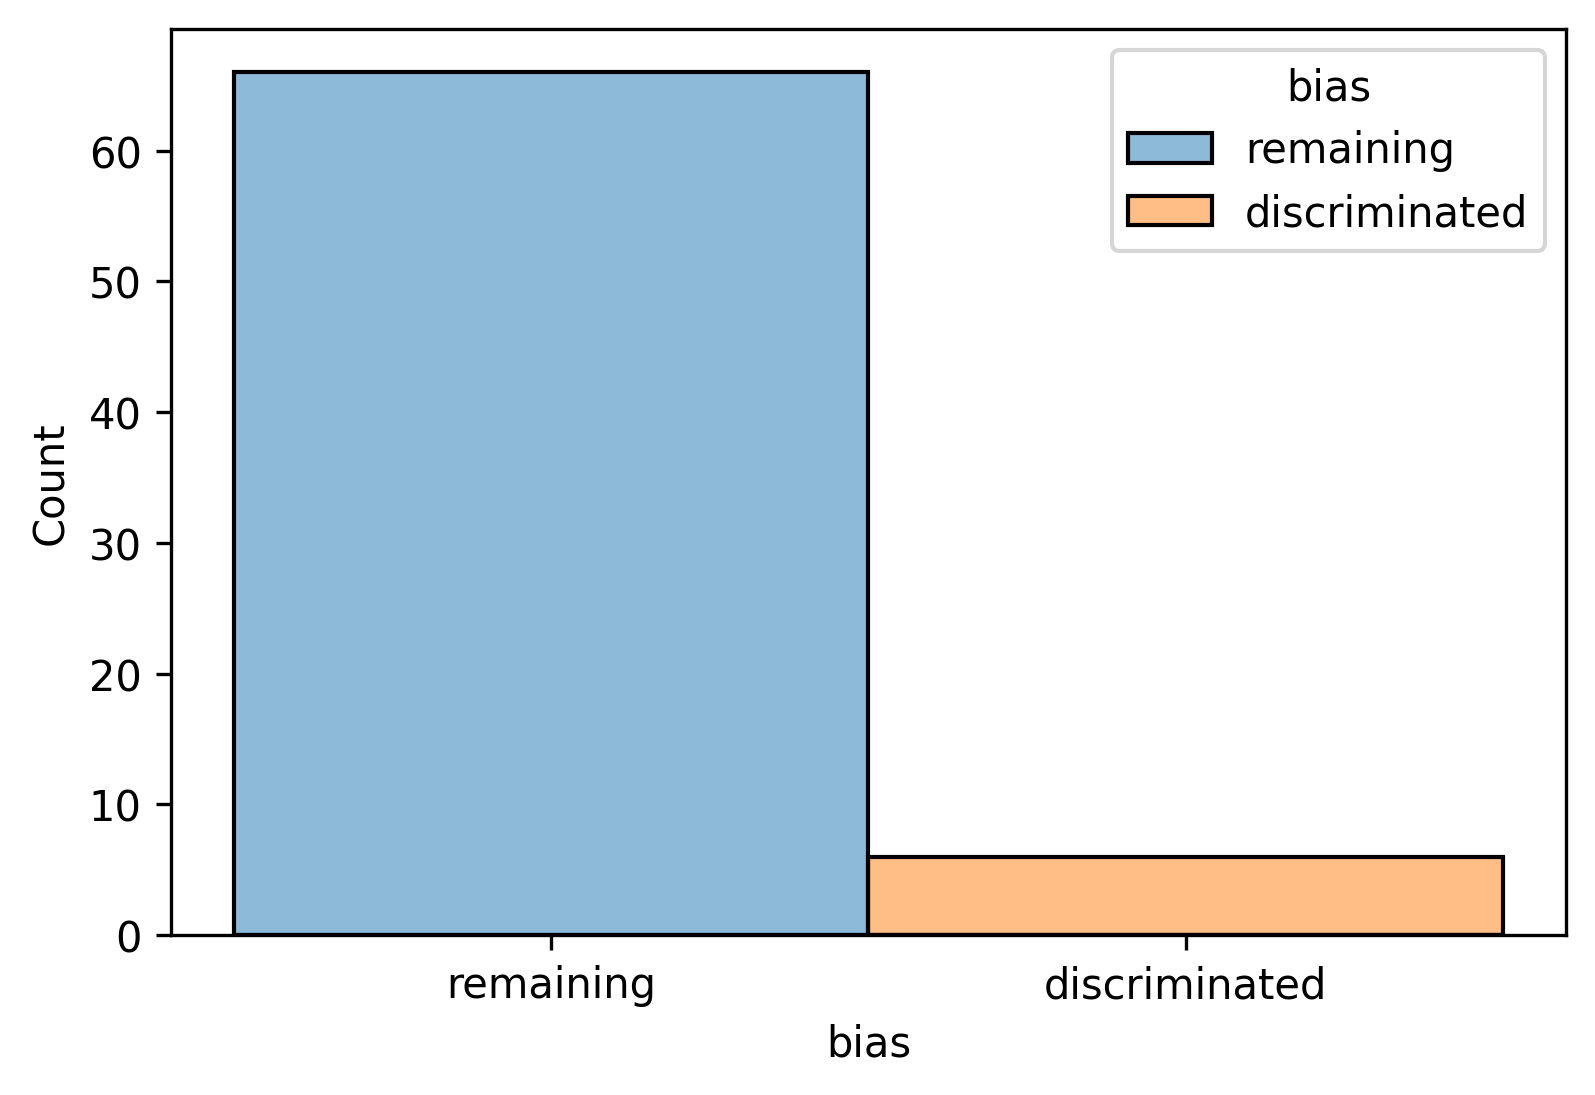

In [25]:
for i in df_all.columns:
    sns.histplot(data=df_all, x=i, hue='bias', bins=20)

    plt.show()

1
2
3
4
5


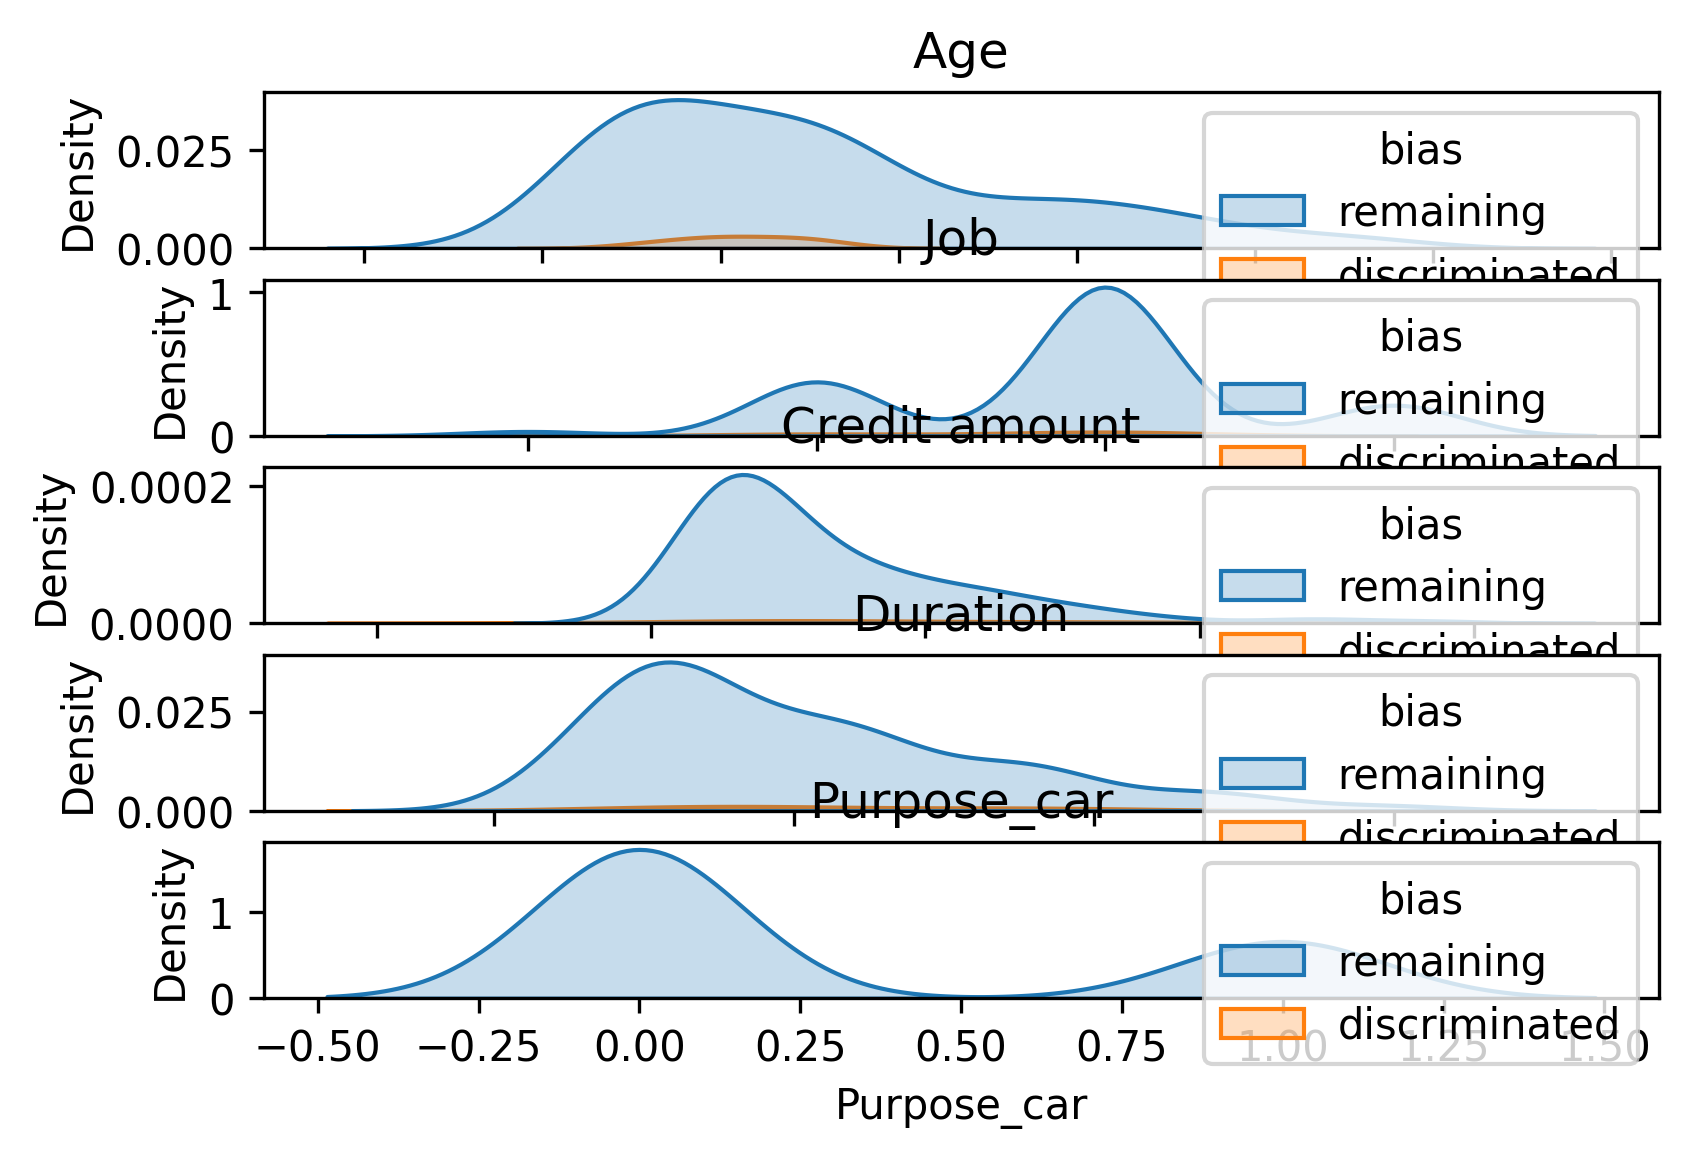

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=1)

i = 0
for col in df_all.columns:
    sns.kdeplot(data=df_all, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i]) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 5: 
        break

#plt.tight_layout()   
plt.show()



In [15]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all
# welchtest = df_all[['Age', 'Job', 'Credit amount', 'Duration', 'bias']]
# welchtest.to_csv('credit_kmeans_densplot')


AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

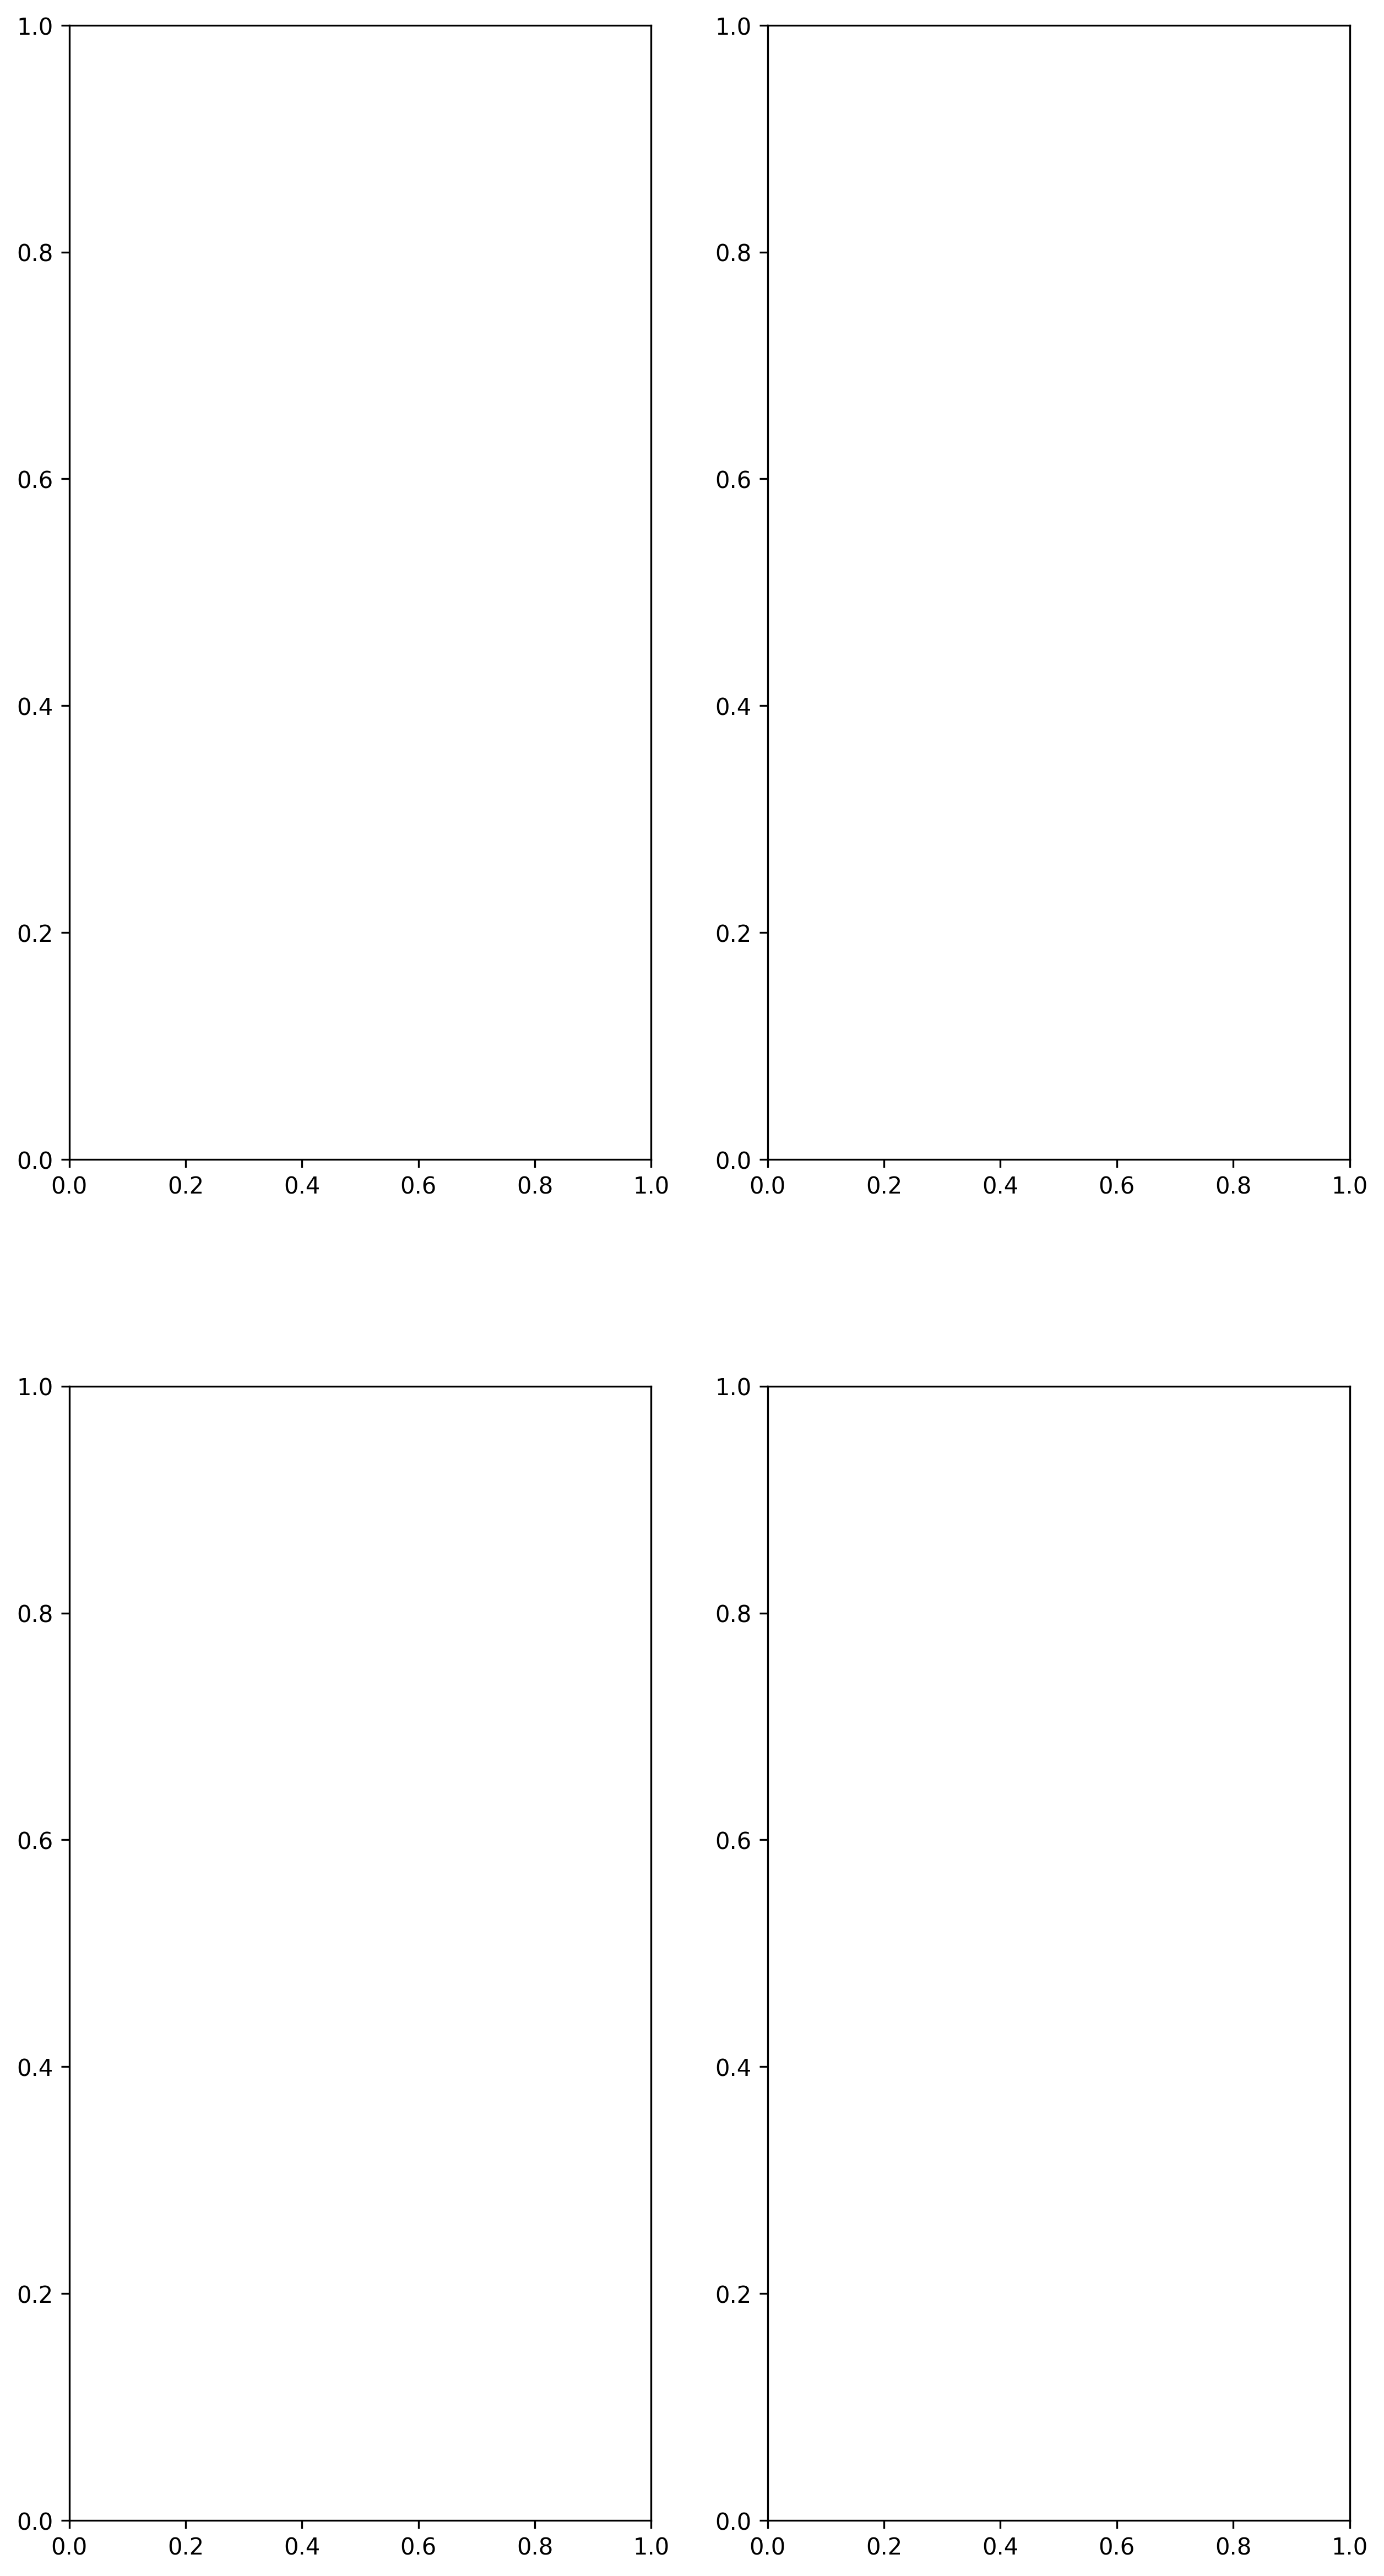

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 4: 
        break

# plt.tight_layout()

plt.show()



In [29]:
df_all

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
104    12.51        1.73  1.98               20.5       85.0           2.20   
67     12.37        1.17  1.92               19.6       78.0           2.11   
118    12.77        3.43  1.98               16.0       80.0           1.63   
39     14.22        3.99  2.51               13.2      128.0           3.00   
176    13.17        2.59  2.37               20.0      120.0           1.65   
..       ...         ...   ...                ...        ...            ...   
12     13.75        1.73  2.41               16.0       89.0           2.60   
47     13.90        1.68  2.12               16.0      101.0           3.10   
8      14.83        1.64  2.17               14.0       97.0           2.80   
124    11.87        4.31  2.39               21.0       82.0           2.86   
172    14.16        2.51  2.48               20.0       91.0           1.68   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
104        1.92                  0.32             1.48             2.94  1.04   
67         2.00                  0.27             1.04             4.68  1.12   
118        1.25                  0.43             0.83             3.40  0.70   
39         3.04                  0.20             2.08             5.10  0.89   
176        0.68                  0.53             1.46             9.30  0.60   
..          ...                   ...              ...              ...   ...   
12         2.76                  0.29             1.81             5.60  1.15   
47         3.39                  0.21             2.14             6.10  0.91   
8          2.98                  0.29             1.98             5.20  1.08   
124        3.03                  0.21             2.91             2.80  0.75   
172        0.70                  0.44             1.24             9.70  0.62   

     od280/od315  proline  predicted_class  true_class  errors           bias  
104         3.57    672.0                1           1       0      remaining  
67          3.48    510.0                1           1       0      remaining  
118         2.12    372.0                2           1       1  discriminated  
39          3.53    760.0                0           0       0      remaining  
176         1.62    840.0                2           2       0      remaining  
..           ...      ...              ...         ...     ...            ...  
12          2.90   1320.0                0           0       0      remaining  
47          3.33    985.0                0           0       0      remaining  
8           2.85   1045.0                0           0       0      remaining  
124         3.64    380.0                1           1       0      remaining  
172         1.71    660.0                2           2       0      remaining  

[72 rows x 17 columns]

AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

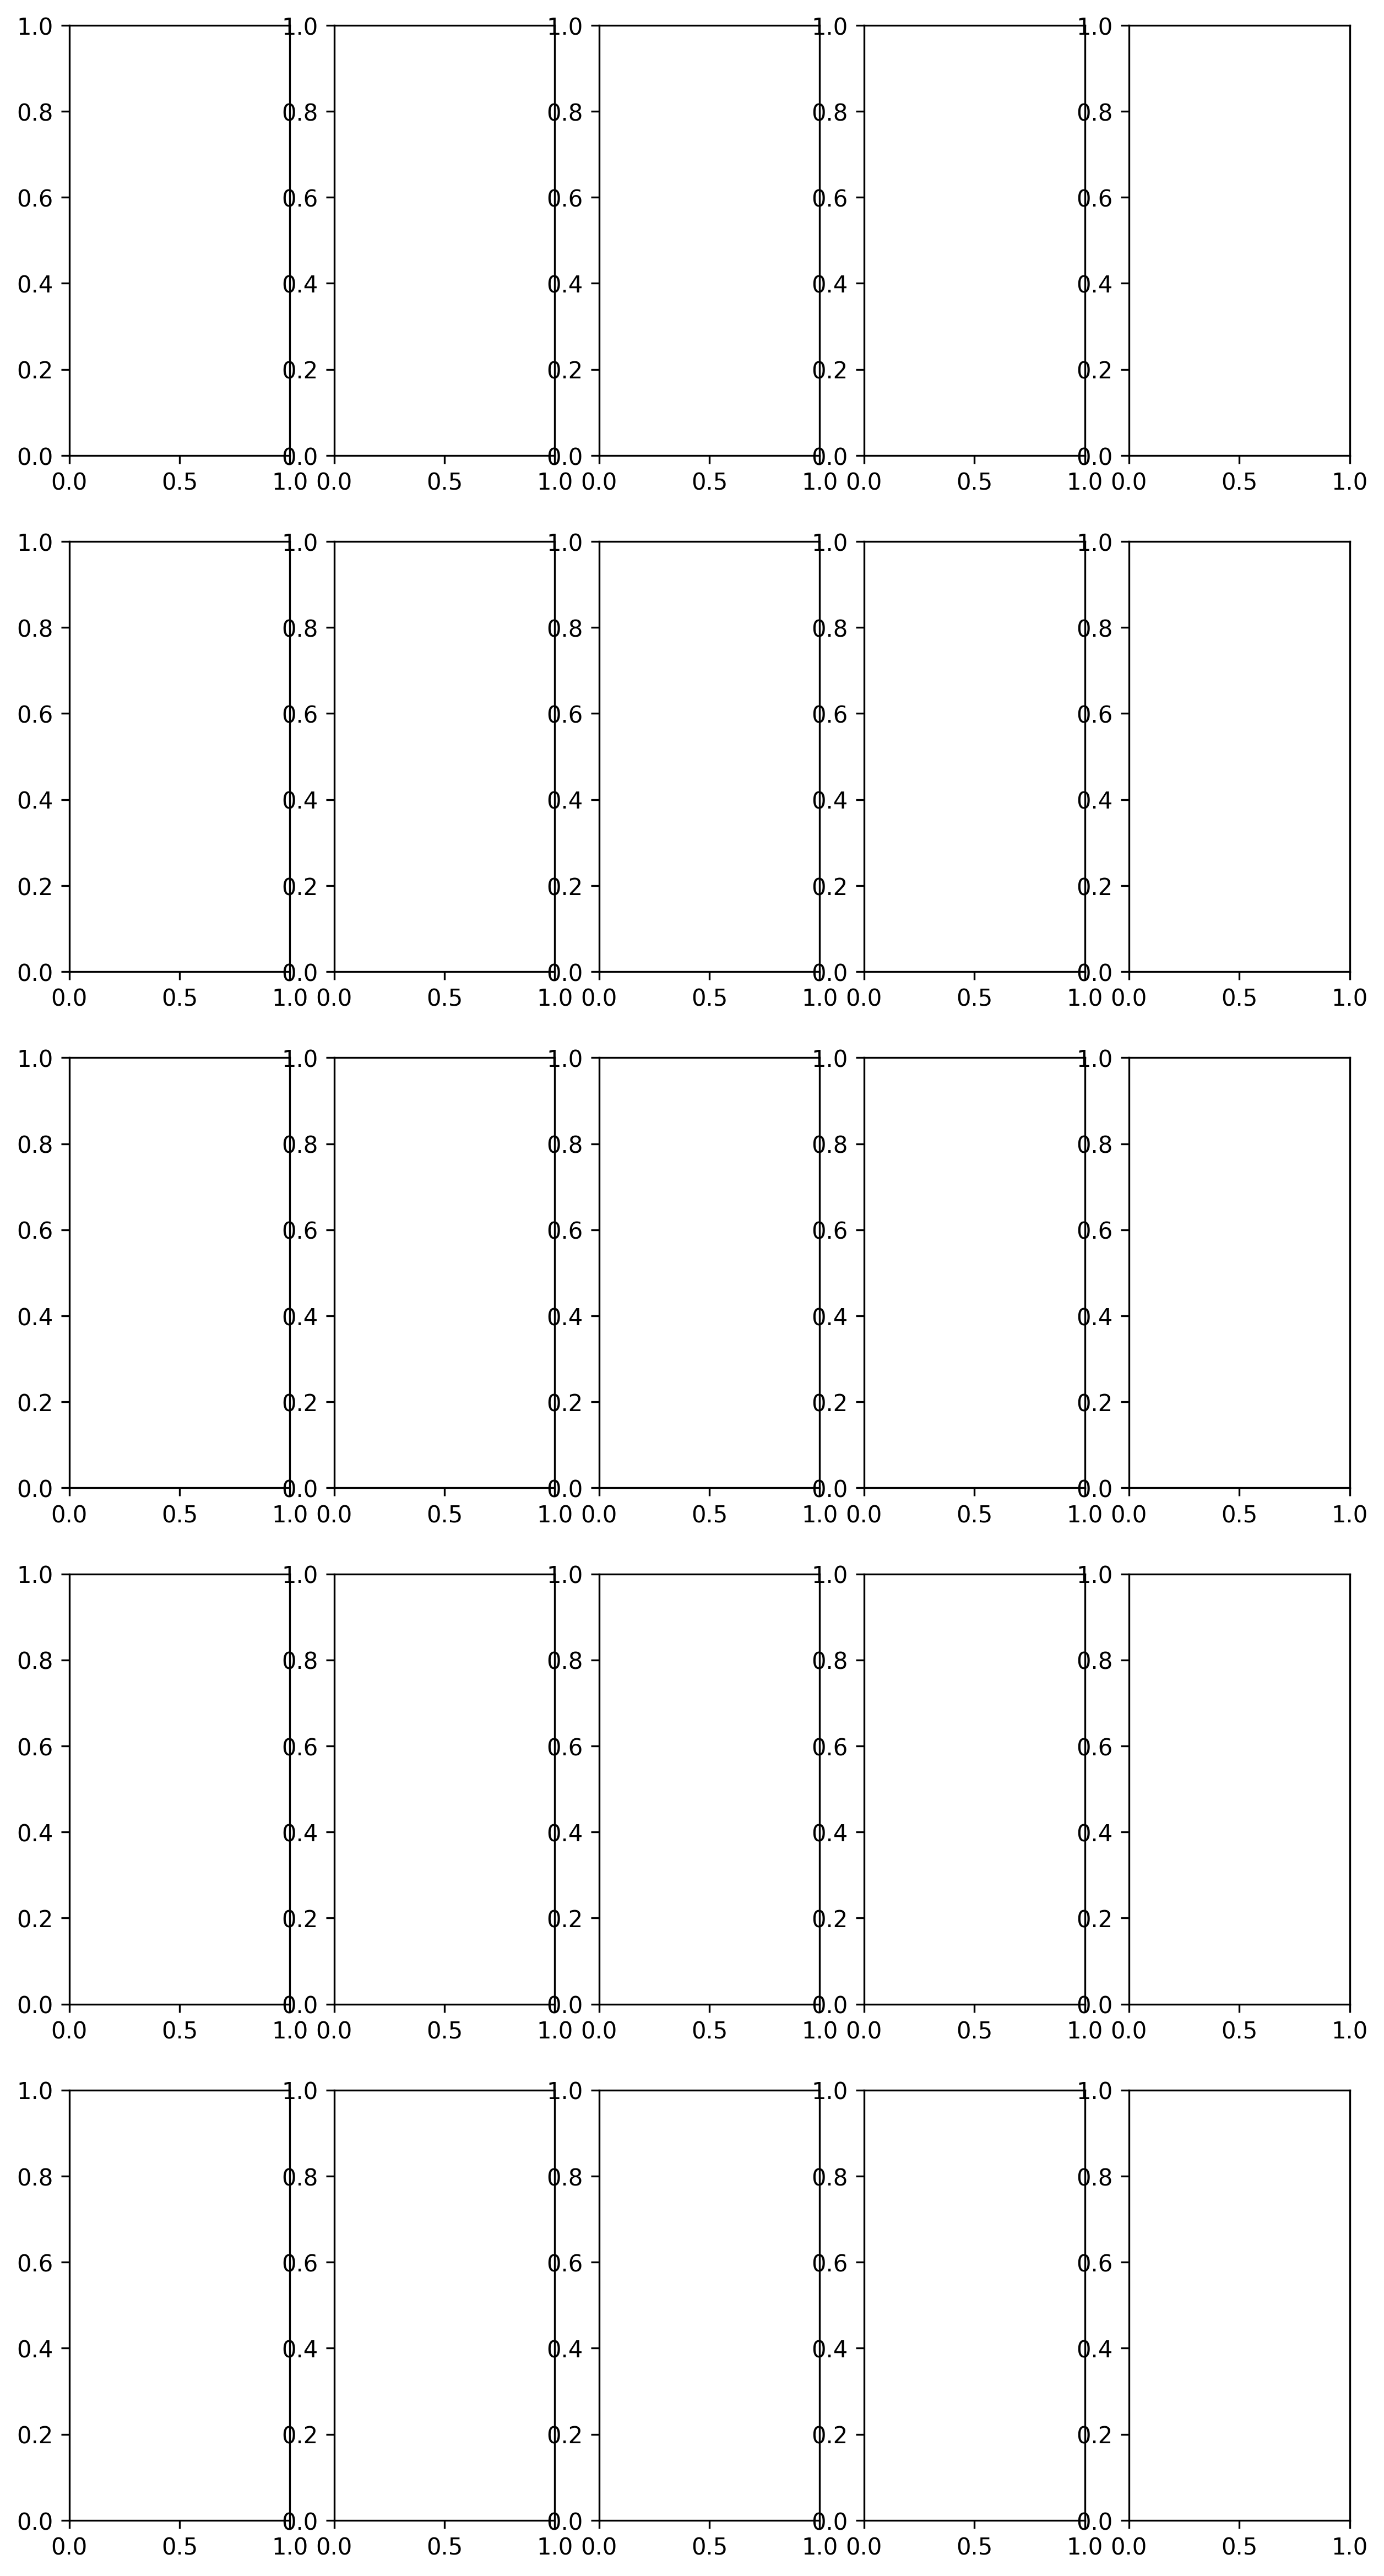

In [28]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in df_all.columns:
    sns.kdeplot(data=df_all, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 5: 
        break

plt.tight_layout()

plt.show()



## Seaborn Pairplot / Density plot

In [24]:
sns.pairplot(df_all, hue="bias")

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 10500x10500 with 196 Axes>